<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPEUR/GBPEUR_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "GBPEUR=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  1.0157  1.0551  1.0157  1.0503     1.0503       0
2009-01-02  1.0513  1.0591  1.0355  1.0429     1.0429       0
2009-01-05  1.0398  1.0827  1.0374  1.0787     1.0787       0
2009-01-06  1.0785  1.1076  1.0752  1.1038     1.1038       0
2009-01-07  1.1039  1.1139  1.0901  1.1065     1.1065       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.1115  1.1150  1.1099  1.1113     1.1113       0
2018-12-27  1.1130  1.1134  1.1061  1.1132     1.1132       0
2018-12-28  1.1062  1.1094  1.1036  1.1059     1.1059       0
2018-12-31  1.1092  1.1199  1.1081  1.1090     1.1090       0
2019-01-01  1.1100  1.1124  1.0974  1.1079     1.1079       0

[2606 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.000000  2606.0
mean      1.196573     1.200819     1.192234     1.196673     1.196673     0.0
std       0.079849     0.080065     0.079444     0.079742     0.079742     0.0
min       1.015700     1.055100     1.015700     1.042900     1.042900     0.0
25%       1.137900     1.141525     1.133625     1.138000     1.138000     0.0
50%       1.175550     1.179600     1.171100     1.175600     1.175600     0.0
75%       1.239500     1.242975     1.235675     1.239475     1.239475     0.0
max       1.440600     1.441200     1.432800     1.440300     1.440300     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  1.0805  1.0852  1.0731  1.0794     1.0794   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  1.085767  1.098185 -1.123065  1.082875  1.096584  1.098192     1.10245     1.10075  1.121355  1.101812  1.076501  1.102520  1.093089  1.101812  1.081200  1.117625                1.138838                 1.101812                1.064787                1.157351                 1.101812                1.046274                1.175864                 1.101812                1.027761                1.194377                 1.101812                1.009248  1.096584  1.083373  1.116743                1.133609                 1.096584                1.059558                1.152122                 1.096584                1.041045                1.170635                 1.096584                1.022532                1.189148                 1.096584                1.004019   
2009-03-13  1.0788  1.0895  1.0756  1.0827     1.0827   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  1.085514  1.097664 -1.116070  1.080437  1.093498  1.095027     1.10245     1.10075  1.117494  1.097300  1.075982  1.094900  1.088842  1.097300  1.081050  1.115166                1.133739                 1.097300                1.060861                1.151959                 1.097300                1.042641                1.170179                 1.097300                1.024421                1.188398                 1.097300                1.006202  1.093498  1.082026  1.113875                1.129938                 1.093498                1.057059                1.148157                 1.093498                1.038839                1.166377                 1.093498                1.020620                1.184596                 1.093498                1.002400   
2009-03-16  1.0830  1.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000    2556.000000   2556.000000     2556.000000     2556.000000       2556.000000  2556.000000  2556.000000  2556.000000  2556.000000   2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000   
mean      1.198360     1.202475     1.194115     1.198434     1.198434    15.758607     1.999218   185.926448      30.467919      0.033255        0.966745        0.010955          0.989045     6.615806     2.537167    27.008998     1.999218      2.000000    27.008998     1.198595     1.198664     0.011037     1.198419     1.198423     1.198134     1.198350     1.198106     1.197878     1.198417     1.198424     1.198414     1.198419     1.198417     1.198426     1.198436                1.211142                 1.198417                1.185692                1.217505                 1.198417                1.179329                1.223868                 1.198417                1.172967                1.230230                 1.198417                1.166604     1.198423     1.198427     1.198434                1.211148                 1.198423                1.185698                1.217511                 1.198423                1.179335                1.223873   
std       0.079490     0.079878     0.078968     0.079431     0.079431     8.806999     1.414767   104.411507       0.781481      0.179337        0.179337        0.104110          0.104110     3.414756     1.108139    14.931190     1.414767      1.414214    14.931190     0.078923     0.078198     1.201046     0.079548     0.078964     0.079012     0.079054     0.078986     0.079602     0.079117     0.079513     0.079192     0.079167     0.079117     0.079386     0.078557                0.081025                 0.079117                0.077834                0.082201                 0.079117                0.077437                0.083516                 0.079117                0.077208                0.084965                 0.079117                0.077146     0.078964     0.079325     0.078637                0.080862                 0.078964                0.077693                0.082033                 0.078964                0.077303                0.083344   
min       1.058400     1.064800     1.054600     1.058300     1.058300     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.057823  0.054198  0.048916  0.055236   0.055236   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.029930  0.035939  0.111125  0.062016  0.067999  0.075110    0.087606    0.078746  0.172671  0.089856  0.049373  0.094674  0.069252  0.089856  0.057116  0.107565                0.136018                 0.089856                0.040500                0.165192                 0.089856                0.020364                0.196842                 0.089856                0.008635                0.226208                 0.089856                0.007577  0.067999  0.057849  0.109076                0.113775                 0.067999                0.019088                0.145137                 0.067999                0.005888                0.176854                 0.067999                0.004905                0.206062                 0.067999   
2009-03-13  0.053375  0.065622  0.055526  0.063874   0.063874   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.029210  0.034363  0.113568  0.055537  0.059251  0.066043    0.087606    0.078746  0.162685  0.077264  0.048018  0.073691  0.057521  0.077264  0.056721  0.100307                0.122116                 0.077264                0.029806                0.150980                 0.077264                0.010689                0.182417                 0.077264                0.000000                0.211586                 0.077264                0.000000  0.059251  0.054260  0.100663                0.103849                 0.059251                0.012218                0.134793                 0.059251                0.000000                0.166179                 0.059251                0.000000                0.195087                 0.059251   
2009-03-16  0.064364  0.074655  0.069276  0.068325   0.068325   16          0         75

137975

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 48 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_d4f348
H2O cluster total nodes:    1
H2O cluster free memory:    8.39 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.840944  0.548067              0.250199  0.432899  0.187401
1  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.831591  0.554894              0.238707  0.436326  0.190381
2  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.830735  0.522477              0.222141  0.414483  0.171796
3  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.825631  0.554731              0.265542  0.422621  0.178608
4  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.816187  0.547203              0.260254  0.424014  0.179788
5  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.811724  0.554880              0.248670  0.434693  0.188958
6  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.806406  0.616527              0.306192  0.453129  0.205326
7  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.785011  0.788863              0.355584  0.499710  0.249710
8              DeepLearning_1_AutoML_20190822_151059  0.754508  0.840977              0.331897  0.529642  0.280521
9  DeepLearning_grid_1_AutoML_20190822_151059_mod...  0.723333  1.390711              0.348463  0.542804  0.294637

variable  relative_importance  scaled_importance  percentage
0            CDLGRAVESTONEDOJI             1.000000           1.000000    0.006451
1             CDLDRAGONFLYDOJI             0.949467           0.949467    0.006125
2                    CDLTAKURI             0.941088           0.941088    0.006071
3                       ULTOSC             0.658840           0.658840    0.004250
4                 STOCHF_fastk             0.567417           0.567417    0.003660
...                        ...                  ...                ...         ...
1016               CDL3OUTSIDE             0.119254           0.119254    0.000769
1017  BBANDS_middleband_24_7_4             0.118986           0.118986    0.000768
1018               CDLMARUBOZU             0.115731           0.115731    0.000747
1019              CDLENGULFING             0.112904           0.112904    0.000728
1020                 CDLHARAMI             0.101532           0.101532    0.000655

[1021 rows x 4 columns]

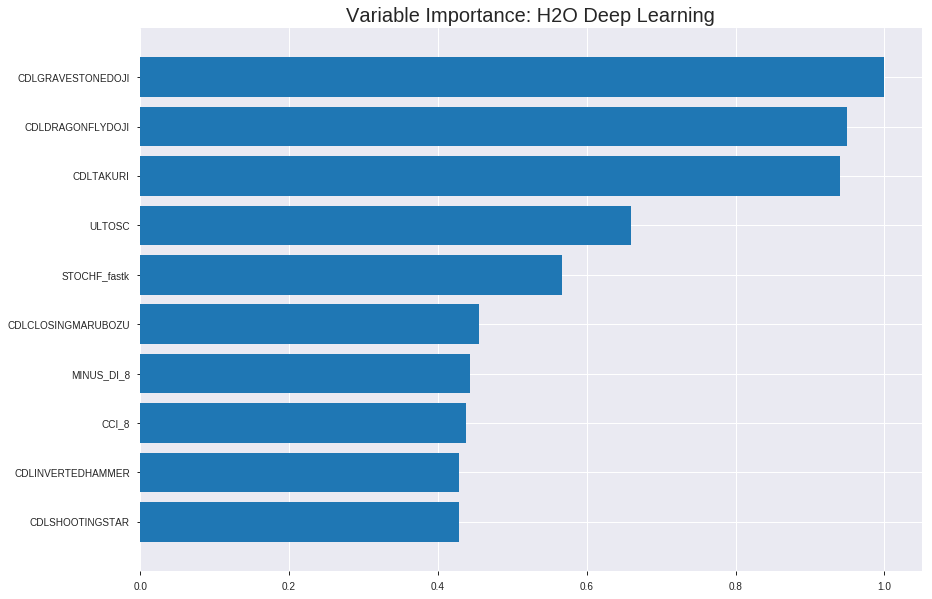

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_151059_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1777330007170032
RMSE: 0.42158391894971897
LogLoss: 0.5261109326488881
Mean Per-Class Error: 0.26508185972481524
AUC: 0.8138692296526906
pr_auc: 0.8052261808870307
Gini: 0.6277384593053812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4320730292085033: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      463  423   0.4774   (423.0/886.0)
1      95   807   0.1053   (95.0/902.0)
Total  558  1230  0.2897   (518.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432073     0.757036  254
max f2                       0.269861     0.863394  314
max f0point5                 0.550173     0.738969  179
max accuracy                 0.517909     0.734899  201
max precision                0.999518     1         0
max recall                   0.00274755   1         396
max specificity              0.999518     1         0
max absolute_mcc             0.517909     0.469817  201
max min_per_class_accuracy   0.517909     0.732816  201
max mean_per_class_accuracy  0.517909     0.734918  201

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.994508           1.98226    1.98226            1                0.998184  1                           0.998184            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.985975           1.98226    1.98226            1                0.991141  1                           0.994663            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.975572           1.87214    1.94555            0.944444         0.979907  0.981481                    0.989744            0.018847        0.0587583                  87.2136   94.5553
    4        0.0402685                   0.959071           1.76201    1.89967            0.888889         0.969022  0.958333                    0.984564            0.0177384       0.0764967                  76.201    89.9667
    5        0.0503356                   0.94294            1.87214    1.89416            0.944444         0.950877  0.955556                    0.977826            0.018847        0.0953437                  87.2136   89.4161
    6        0.100112                    0.843571           1.8709     1.88259            0.94382          0.902069  0.949721                    0.940159            0.0931264       0.18847                    87.0899   88.2595
    7        0.150447                    0.76957            1.71796    1.82751            0.866667         0.808234  0.921933                    0.896021            0.0864745       0.274945                   71.796    82.7513
    8        0.200224                    0.688843           1.58135    1.76632            0.797753         0.723247  0.891061                    0.853069            0.078714        0.353659                   58.1355   76.6317
    9        0.300336                    0.608435           1.35104    1.62789            0.681564         0.644809  0.821229                    0.783649            0.135255        0.488914                   35.1039   62.7891
    10       0.399888                    0.549252           1.28067    1.54145            0.646067         0.573918  0.777622                    0.731436            0.127494        0.616408                   28.0675   54.1451
    11       0.5                         0.517094           1.16278    1.46563            0.586592         0.532757  0.739374                    0.691656            0.116408        0.732816                   16.2779   46.5632
    12       0.600112                    0.481898           0.897001   1.37077            0.452514         0.499642  0.691519                    0.659624            0.0898004       0.822616                   -10.2999  37.0772
    13       0.699664                    0.42286            0.768405   1.28506            0.38764          0.455629  0.648281                    0.630598            0.0764967       0.899113                   -23.1595  28.5063
    14       0.799776                    0.300627           0.598001   1.19906            0.301676         0.368517  0.604895                    0.597792            0.059867        0.95898                    -40.1999  19.906
    15       0.899888                    0.0696422          0.343297   1.10386            0.173184         0.198167  0.556868                    0.553334            0.0343681       0.993348                   -65.6703  10.3857
    16       1                           1.90808e-06        0.0664445  1                  0.0335196        0.011314  0.504474                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17939801808182337
RMSE: 0.4235540320689007
LogLoss: 0.5278892394141882
Mean Per-Class Error: 0.2808344058344059
AUC: 0.8018324446895875
pr_auc: 0.7843131779072411
Gini: 0.603664889379175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40333316919681567: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  142  0.5483   (142.0/259.0)
1      12   240  0.0476   (12.0/252.0)
Total  129  382  0.3014   (154.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403333     0.757098  295
max f2                       0.305509     0.866808  321
max f0point5                 0.615336     0.719538  144
max accuracy                 0.504064     0.7182    228
max precision                0.999206     1         0
max recall                   0.034464     1         365
max specificity              0.999206     1         0
max absolute_mcc             0.403333     0.465085  295
max min_per_class_accuracy   0.527781     0.702381  201
max mean_per_class_accuracy  0.504064     0.719166  228

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.991738           2.02778   2.02778            1                0.996277    1                           0.996277            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.982572           2.02778   2.02778            1                0.984686    1                           0.991009            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.975301           1.62222   1.90104            0.8              0.978951    0.9375                      0.987241            0.015873        0.0595238                  62.2222   90.1042
    4        0.0410959                   0.967464           2.02778   1.93122            1                0.970946    0.952381                    0.983361            0.0198413       0.0793651                  102.778   93.1217
    5        0.0508806                   0.946753           1.62222   1.87179            0.8              0.955432    0.923077                    0.97799             0.015873        0.0952381                  62.2222   87.1795
    6        0.101761                    0.871615           1.7938    1.8328             0.884615         0.909579    0.903846                    0.943785            0.0912698       0.186508                   79.3803   83.2799
    7        0.150685                    0.786972           1.86556   1.84343            0.92             0.830756    0.909091                    0.907087            0.0912698       0.277778                   86.5556   84.3434
    8        0.201566                    0.719702           1.32585   1.71278            0.653846         0.751139    0.84466                     0.867722            0.0674603       0.345238                   32.5855   71.2783
    9        0.30137                     0.641944           1.35185   1.59325            0.666667         0.676466    0.785714                    0.804384            0.134921        0.480159                   35.1852   59.3254
    10       0.401174                    0.57798            1.15305   1.48374            0.568627         0.609517    0.731707                    0.755905            0.115079        0.595238                   15.305    48.374
    11       0.500978                    0.525736           1.11329   1.40994            0.54902          0.546549    0.695312                    0.714197            0.111111        0.706349                   11.329    40.9939
    12       0.600783                    0.491936           1.07353   1.35405            0.529412         0.510138    0.667752                    0.680298            0.107143        0.813492                   7.35294   35.4054
    13       0.700587                    0.456209           0.954248  1.2971             0.470588         0.474055    0.639665                    0.650917            0.0952381       0.90873                    -4.57516  29.7098
    14       0.800391                    0.31328            0.636166  1.21468            0.313725         0.39919     0.599022                    0.619528            0.0634921       0.972222                   -36.3834  21.4684
    15       0.900196                    0.0302044          0.278322  1.11087            0.137255         0.138216    0.547826                    0.566165            0.0277778       1                          -72.1678  11.087
    16       1                           4.11381e-05        0         1                  0                0.00965545  0.493151   


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:31:47  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:31:49  11 min 54.875 sec  306 obs/sec       0.368568  1             659        0.613849         1.59845             -0.507365      0.605738        0.585085           1.54176          0.445749                         0.567571           1.28343               -0.28879         0.620595          0.633748             2.02778            0.489237
    2019-08-22 15:32:19  12 min 24.221 sec  403 obs/sec       6.43568   17            11507      0.479192         0.649301            0.081426       0.729018        0.733211           1.98226          0.374161                         0.488945           0.671029              0.0435517        0.722306          0.684041             1.68981            0.363992
    2019-08-22 15:32:48  12 min 53.881 sec  428 obs/sec       13.2645   35            23717      0.47852          0.645756            0.0839997      0.721564        0.739255           1.98226          0.415548                         0.496514           0.686087              0.0137116        0.652234          0.63649              1.35185            0.412916
    2019-08-22 15:33:17  13 min 22.976 sec  441 obs/sec       20.1342   53            36000      0.44317          0.573631            0.214337       0.785648        0.79216            1.98226          0.319911                         0.45214            0.595601              0.182126         0.800974          0.791484             2.02778            0.285714
    2019-08-22 15:33:47  13 min 52.403 sec  447 obs/sec       27.0157   71            48304      0.445233         0.575487            0.207006       0.765933        0.766262           1.98226          0.308725                         0.452693           0.591952              0.180121         0.757998          0.752172             2.02778            0.344423
    2019-08-22 15:34:17  14 min 23.964 sec  451 obs/sec       34.2824   90            61297      0.434471         0.548709            0.24488        0.7841          0.780033           1.98226          0.317114                         0.436361           0.558641              0.238214         0.784565          0.750821             1.68981            0.311155
    2019-08-22 15:34:57  15 min  2.951 sec  457 obs/sec       43.9262   115           78540      0.426087         0.536402            0.273743       0.808634        0.800106           1.98226          0.301454                         0.426888           0.537879              0.27093          0.807923          0.784021             2.02778            0.295499
    2019-08-22 15:35:27  15 min 32.897 sec  460 obs/sec       51.2287   134           91597      0.421584         0.526111            0.289011       0.813869        0.805226           1.98226          0.289709                         0.423554           0.527889              0.282273         0.801832          0.784313             2.02778            0.30137
    2019-08-2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI         1.0                    1.0                  0.006450694419437721
CDLDRAGONFLYDOJI          0.9494674801826477     0.9494674801826477   0.006124724575851801
CDLTAKURI                 0.9410876631736755     0.9410876631736755   0.006070668937036115
ULTOSC                    0.6588403582572937     0.6588403582572937   0.004249977822310674
STOCHF_fastk              0.5674172043800354     0.5674172043800354   0.0036602349937872474
---                       ---                    ---                  ---
CDL3OUTSIDE               0.11925356835126877    0.11925356835126877  0.0007692683278615643
BBANDS_middleband_24_7_4  0.11898559331893921    0.11898559331893921  0.0007675397028159673
CDLMARUBOZU               0.11573141068220139    0.11573141068220139  0.0007465479650413315
CDLENGULFING              0.1129043847322464     0.1129043847322464   0.0007283116845223513
CDLHARAMI                 0.1015324667096138     0.1015324667096138   0.0006549549163954519


See the whole table with table.as_data_frame()


('accuracy', 0.77734375)

('F1', 0.8037974683544303)

('auc', 0.8409438229720644)

('logloss', 0.5480668853280515)

('mean_per_class_error', 0.22467754752735503)

('rmse', 0.43289866750916695)

('mse', 0.1874012563312123)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


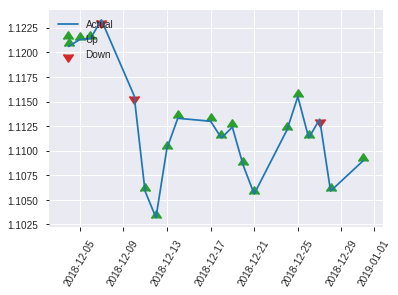


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1874012563312123
RMSE: 0.43289866750916695
LogLoss: 0.5480668853280515
Mean Per-Class Error: 0.22467754752735503
AUC: 0.8409438229720644
pr_auc: 0.8338195096641137
Gini: 0.6818876459441288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6160916666495988: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   56   0.4553   (56.0/123.0)
1      6    127  0.0451   (6.0/133.0)
Total  73   183  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.616092     0.803797  182
max f2                       0.514218     0.888738  204
max f0point5                 0.674983     0.77574   143
max accuracy                 0.674983     0.777344  143
max precision                0.996154     1         0
max recall                   0.0343943    1         240
max specificity              0.996154     1         0
max absolute_mcc             0.674983     0.554574  143
max min_per_class_accuracy   0.696181     0.739837  130
max mean_per_class_accuracy  0.674983     0.775322  143

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 63.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.991886           1.92481   1.92481            1                0.995534   1                           0.995534            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.986453           1.92481   1.92481            1                0.987736   1                           0.991635            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.979628           1.92481   1.92481            1                0.981979   1                           0.989221            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.976235           1.28321   1.74983            0.666667         0.977562   0.909091                    0.986041            0.0150376       0.075188                   28.3208   74.9829
    5        0.0507812                   0.962787           1.92481   1.77675            1                0.970278   0.923077                    0.983616            0.0150376       0.0902256                  92.4812   77.675
    6        0.101562                    0.928945           1.92481   1.85078            1                0.947825   0.961538                    0.965721            0.0977444       0.18797                    92.4812   85.0781
    7        0.152344                    0.87927            1.77675   1.8261             0.923077         0.903085   0.948718                    0.944842            0.0902256       0.278195                   77.675    82.6104
    8        0.203125                    0.830727           1.1845    1.6657             0.615385         0.852278   0.865385                    0.921701            0.0601504       0.338346                   18.45     66.5703
    9        0.300781                    0.790201           1.69383   1.67484            0.88             0.812526   0.87013                     0.886255            0.165414        0.503759                   69.3835   67.4836
    10       0.402344                    0.740455           1.1845    1.55106            0.615385         0.764036   0.805825                    0.855403            0.120301        0.62406                    18.45     55.1062
    11       0.5                         0.701608           1.15489   1.47368            0.6              0.718923   0.765625                    0.828747            0.112782        0.736842                   15.4887   47.3684
    12       0.601562                    0.666543           1.11047   1.41236            0.576923         0.681584   0.733766                    0.803901            0.112782        0.849624                   11.0468   41.2362
    13       0.699219                    0.624498           0.846917  1.33339            0.44             0.647077   0.692737                    0.781998            0.0827068       0.932331                   -15.3083  33.3389
    14       0.800781                    0.514218           0.518219  1.23               0.269231         0.582245   0.639024                    0.756664            0.0526316       0.984962                   -48.1781  23.0002
    15       0.898438                    0.0755631          0         1.09631            0                0.291529   0.569565                    0.706106            0               0.984962                   -100      9.6306
    16       1                           0.000600702        0.148062  1                  0.0769231        0.0322839  0.519531                    0

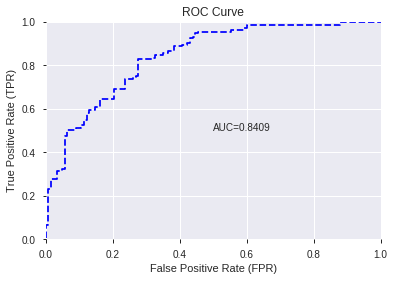

This function is available for GLM models only


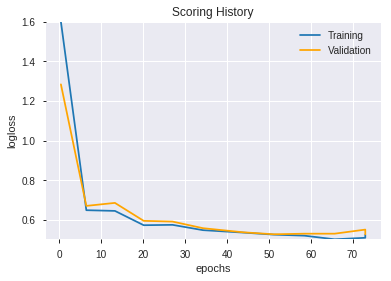

--2019-08-22 16:01:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_151059_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_151059_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_160137_model_8  0.861238  0.474349              0.249282  0.392782  0.154278
1  DeepLearning_grid_1_AutoML_20190822_160137_model_9  0.854575  0.472956              0.232410  0.394781  0.155852
2  DeepLearning_grid_1_AutoML_20190822_160137_model_5  0.849624  0.468267              0.248976  0.395880  0.156721
3               DeepLearning_1_AutoML_20190822_160137  0.842594  0.513448              0.268996  0.406725  0.165425
4  DeepLearning_grid_1_AutoML_20190822_160137_model_6  0.834831  0.491063              0.268384  0.406790  0.165478
5  DeepLearning_grid_1_AutoML_20190822_160137_model_4  0.803839  0.644917              0.306192  0.456704  0.208579
6  DeepLearning_grid_1_AutoML_20190822_160137_model_3  0.801455  0.618290              0.275903  0.444297  0.197400
7  DeepLearning_grid_1_AutoML_20190822_160137_model_7  0.799132  0.560812              0.299285  0.425256  0.180842
8  DeepLearning_grid_1_AutoML_20190822_160137_model_2  0.786784  0.633549              0.298674  0.450919  0.203328
9  DeepLearning_grid_1_AutoML_20190822_160137_model_1  0.772113  0.672239              0.317471  0.465561  0.216747

variable  relative_importance  scaled_importance  percentage
0       CDLRICKSHAWMAN             1.000000           1.000000    0.042274
1         STOCHF_fastk             0.800767           0.800767    0.033851
2    CDLLONGLEGGEDDOJI             0.720393           0.720393    0.030454
3              CDLDOJI             0.714187           0.714187    0.030191
4               TRANGE             0.698982           0.698982    0.029548
5               ULTOSC             0.641508           0.641508    0.027119
6                CCI_8             0.589200           0.589200    0.024908
7           MINUS_DI_8             0.586257           0.586257    0.024783
8              BETA_30             0.556646           0.556646    0.023531
9             WILLR_12             0.523159           0.523159    0.022116
10          PLUS_DI_30             0.506167           0.506167    0.021398
11         MINUS_DI_30             0.498991           0.498991    0.021094
12   CDLGRAVESTONEDOJI             0.498362           0.498362    0.021068
13           CORREL_24             0.495385           0.495385    0.020942
14    CDLDRAGONFLYDOJI             0.492982           0.492982    0.020840
15  CDLCLOSINGMARUBOZU             0.488666           0.488666    0.020658
16           CDLTAKURI             0.481602           0.481602    0.020359
17              SAREXT             0.479394           0.479394    0.020266
18         CDLBELTHOLD             0.470533           0.470533    0.019891
19           CORREL_30             0.456389           0.456389    0.019293
20         MINUS_DI_20             0.456088           0.456088    0.019280
21         MINUS_DI_12             0.446191           0.446191    0.018862
22           PLUS_DI_8             0.442110           0.442110    0.018690
23             WILLR_8             0.441857           0.441857    0.018679
24              CCI_14             0.436742           0.436742    0.018463
25   CDLINVERTEDHAMMER             0.436718           0.436718    0.018462
26            WILLR_24             0.433281           0.433281    0.018316
27           CDLHAMMER             0.432966           0.432966    0.018303
28          MINUS_DM_8             0.432096           0.432096    0.018266
29        STOCHF_fastd             0.426404           0.426404    0.018026
30         MINUS_DI_24             0.425258           0.425258    0.017977
31            WILLR_20             0.421561           0.421561    0.017821
32              CCI_12             0.420186           0.420186    0.017763
33         STOCH_slowk             0.415675           0.415675    0.017572
34          aroonup_14             0.411994           0.411994    0.017416
35            WILLR_30             0.410905           0.410905    0.017370
36           ROCR100_8             0.401067           0.401067    0.016955
37     CDLSHOOTINGSTAR             0.392558           0.392558    0.016595
38               ROC_8             0.390222           0.390222    0.016496
39              CCI_24             0.389570           0.389570    0.016469
40              ROCP_8             0.379560           0.379560    0.016045
41           PLUS_DM_8             0.367982           0.367982    0.015556
42         MINUS_DI_14             0.366919           0.366919    0.015511
43          PLUS_DI_14             0.356970           0.356970    0.015090
44          PLUS_DI_12             0.354726           0.354726    0.014996
45          PLUS_DM_12             0.352700           0.352700    0.014910
46              CCI_20             0.352039           0.352039    0.014882
47         MINUS_DM_14             0.332519           0.332519    0.014057
48       CDLHANGINGMAN             0.328465           0.328465    0.013885
49         MINUS_DM_12             0.300524           0.300524    0.012704

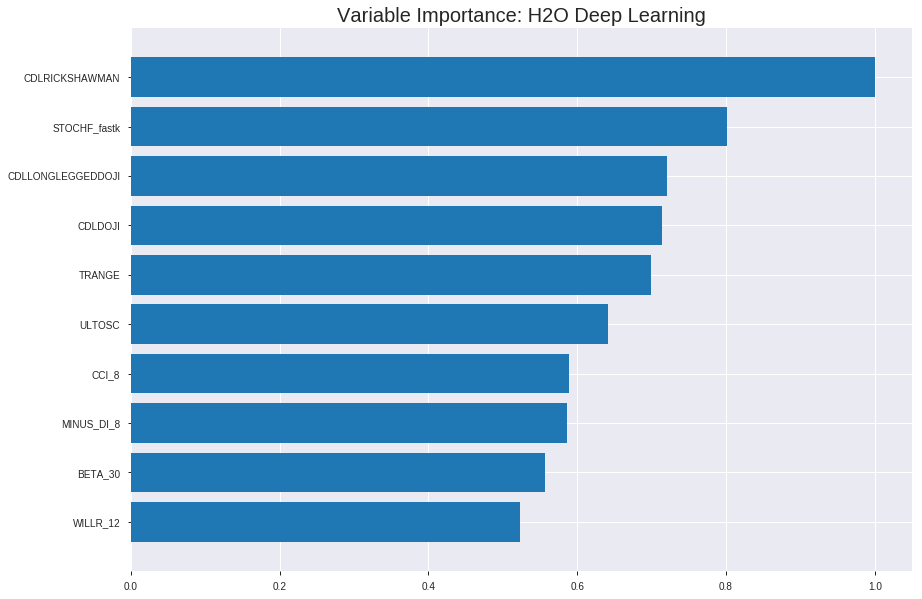

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_160137_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16013337457365096
RMSE: 0.4001666834878323
LogLoss: 0.46476547219661124
Mean Per-Class Error: 0.26422096870260714
AUC: 0.8395677025721622
pr_auc: 0.8165342966693138
Gini: 0.6791354051443244
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4745003037883549: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      448  438   0.4944   (438.0/886.0)
1      66   836   0.0732   (66.0/902.0)
Total  514  1274  0.2819   (504.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4745       0.768382  227
max f2                       0.34905      0.877665  276
max f0point5                 0.518691     0.766726  184
max accuracy                 0.50422      0.734899  197
max precision                0.999873     1         0
max recall                   0.020365     1         380
max specificity              0.999873     1         0
max absolute_mcc             0.518691     0.483719  184
max min_per_class_accuracy   0.49631      0.709534  208
max mean_per_class_accuracy  0.50422      0.735779  197

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.999868           1.98226    1.98226            1                0.999925   1                           0.999925            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.999704           1.98226    1.98226            1                0.999813   1                           0.999869            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.999396           1.98226    1.98226            1                0.999569   1                           0.999769            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.998978           1.98226    1.98226            1                0.999195   1                           0.999626            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.998432           1.98226    1.98226            1                0.998754   1                           0.999451            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.987674           1.98226    1.98226            1                0.994809   1                           0.997143            0.0986696       0.198448                   98.2262   98.2262
    7        0.150447                    0.95316            1.87214    1.94542            0.944444         0.975054   0.981413                    0.989753            0.094235        0.292683                   87.2136   94.5417
    8        0.200224                    0.80647            1.82635    1.91582            0.921348         0.889408   0.96648                     0.964807            0.0909091       0.383592                   82.6353   91.5817
    9        0.300336                    0.542642           1.30674    1.71279            0.659218         0.639585   0.86406                     0.8564              0.13082         0.514412                   30.6742   71.2792
    10       0.399888                    0.504165           1.16931    1.57749            0.589888         0.518613   0.795804                    0.772307            0.116408        0.63082                    16.9312   57.7492
    11       0.633669                    0.495765           0.981646   1.35767            0.495215         0.496976   0.684907                    0.670729            0.22949         0.86031                    -1.83537  35.7666
    12       0.699664                    0.478899           0.823143   1.30725            0.415254         0.48947    0.659472                    0.653631            0.0543237       0.914634                   -17.6857  30.7247
    13       0.799776                    0.308559           0.631223   1.22263            0.318436         0.422194   0.616783                    0.624661            0.0631929       0.977827                   -36.8777  22.2626
    14       0.899888                    0.0344668          0.199334   1.10879            0.100559         0.135904   0.559354                    0.570287            0.0199557       0.997783                   -80.0666  10.8785
    15       1                           0.000112678        0.0221482  1                  0.0111732        0.0105998  0.504474                    0.514256            0.00221729      1                          -97.7852  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1566631035037896
RMSE: 0.39580690178897787
LogLoss: 0.4796597159713318
Mean Per-Class Error: 0.2394358644358645
AUC: 0.8515352086780658
pr_auc: 0.8331782871047066
Gini: 0.7030704173561315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.485808245544929: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      164  95   0.3668   (95.0/259.0)
1      30   222  0.119    (30.0/252.0)
Total  194  317  0.2446   (125.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485808     0.780316  225
max f2                       0.358146     0.875543  278
max f0point5                 0.651424     0.780516  116
max accuracy                 0.492887     0.759295  214
max precision                0.999922     1         0
max recall                   0.0106554    1         369
max specificity              0.999922     1         0
max absolute_mcc             0.486844     0.530898  222
max min_per_class_accuracy   0.496443     0.745174  201
max mean_per_class_accuracy  0.492887     0.760564  214

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.999654           2.02778    2.02778            1                0.99985     1                           0.99985             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.999545           2.02778    2.02778            1                0.999563    1                           0.99972             0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.999255           2.02778    2.02778            1                0.999383    1                           0.999614            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.999117           2.02778    2.02778            1                0.999215    1                           0.999519            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.998562           1.62222    1.94979            0.8              0.998806    0.961538                    0.999382            0.015873        0.0992063                  62.2222   94.9786
    6        0.101761                    0.992511           1.94979    1.94979            0.961538         0.996268    0.961538                    0.997825            0.0992063       0.198413                   94.9786   94.9786
    7        0.150685                    0.96773            1.78444    1.8961             0.88             0.983087    0.935065                    0.99304             0.0873016       0.285714                   78.4444   89.6104
    8        0.201566                    0.895246           2.02778    1.92934            1                0.936569    0.951456                    0.978785            0.103175        0.388889                   102.778   92.9342
    9        0.30137                     0.635617           1.43137    1.76443            0.705882         0.781777    0.87013                     0.913542            0.142857        0.531746                   43.1373   76.443
    10       0.401174                    0.510453           1.23257    1.63211            0.607843         0.558099    0.804878                    0.825115            0.123016        0.654762                   23.2571   63.2114
    11       0.500978                    0.496341           0.914488   1.48915            0.45098          0.499983    0.734375                    0.760343            0.0912698       0.746032                   -8.5512   48.9149
    12       0.600783                    0.490918           1.15305    1.43332            0.568627         0.494984    0.70684                     0.71626             0.115079        0.861111                   15.305    43.3315
    13       0.700587                    0.441708           0.675926   1.32542            0.333333         0.470481    0.653631                    0.681247            0.0674603       0.928571                   -32.4074  32.5419
    14       0.800391                    0.13785            0.477124   1.21964            0.235294         0.285606    0.601467                    0.631913            0.047619        0.97619                    -52.2876  21.9641
    15       0.900196                    0.0147029          0.198802   1.10646            0.0980392        0.0567308   0.545652                    0.568143            0.0198413       0.996032                   -80.1198  10.6461
    16       1                           0.000203838        0.0397603  1                  0.0196078        0.00


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:08:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:08:46  1 min 50.478 sec  645 obs/sec       0.733781  1             1312       0.479479         0.657575            0.0803272      0.730789        0.736226           1.98226          0.369687                         0.439411           0.568252              0.227529         0.787124          0.763143             2.02778            0.315068
    2019-08-22 16:09:00  2 min  4.467 sec  976 obs/sec       8.02852   11            14355      0.430408         0.53631             0.258935       0.816551        0.826091           1.98226          0.307047                         0.416697           0.506024              0.305323         0.845353          0.840747             2.02778            0.260274
    2019-08-22 16:09:13  2 min 17.678 sec  1081 obs/sec      16.0945   22            28777      0.419235         0.511783            0.296911       0.824082        0.832121           1.98226          0.294183                         0.406445           0.486825              0.339087         0.857311          0.851586             2.02778            0.273973
    2019-08-22 16:09:26  2 min 30.855 sec  1159 obs/sec      24.9105   34            44540      0.414911         0.499879            0.311341       0.815432        0.831544           1.98226          0.297539                         0.40732            0.488402              0.336236         0.843093          0.838014             2.02778            0.246575
    2019-08-22 16:09:40  2 min 44.751 sec  1180 obs/sec      33.7025   46            60260      0.41512          0.498374            0.310647       0.824483        0.838809           1.98226          0.304251                         0.40797            0.487871              0.334118         0.847598          0.840979             2.02778            0.268102
    2019-08-22 16:09:54  2 min 58.563 sec  1217 obs/sec      43.2293   59            77294      0.400167         0.464765            0.359415       0.839568        0.816534           1.98226          0.281879                         0.395807           0.47966               0.37323          0.851535          0.833178             2.02778            0.244618
    2019-08-22 16:10:07  3 min 12.074 sec  1246 obs/sec      52.7578   72            94331      0.394874         0.451287            0.376249       0.845773        0.833163           1.98226          0.263982                         0.39589            0.482103              0.372968         0.849091          0.831816             2.02778            0.258317
    2019-08-22 16:10:09  3 min 13.408 sec  1245 obs/sec      52.7578   72            94331      0.400167         0.464765            0.359415       0.839568        0.816534           1.98226          0.281879                         0.395807           0.47966               0.37323          0.851535          0.833178             2.02778            0.244618

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN     1.0                    1.0                  0.042273602716645084
STOCHF_fastk       0.8007667660713196     0.8007667660713196   0.03385129613759163
CDLLONGLEGGEDDOJI  0.720393180847168      0.720393180847168    0.03045361512691343
CDLDOJI            0.7141872644424438     0.7141872644424438   0.030191268682327414
TRANGE             0.6989817023277283     0.6989817023277283   0.02954847479040666
---                ---                    ---                  ---
PLUS_DM_12         0.35269978642463684    0.35269978642463684  0.014909890649560668
CCI_20             0.35203927755355835    0.35203927755355835  0.014881968559953876
MINUS_DM_14        0.33251893520355225    0.33251893520355225  0.014056773362556816
CDLHANGINGMAN      0.32846537232398987    0.32846537232398987  0.013885414655799256
MINUS_DM_12        0.30052438378334045    0.30052438378334045  0.01270424840672151


See the whole table with table.as_data_frame()


('accuracy', 0.77734375)

('F1', 0.7999999999999999)

('auc', 0.8612384620086803)

('logloss', 0.47434855858347946)

('mean_per_class_error', 0.22284369460235953)

('rmse', 0.3927820945922248)

('mse', 0.15427777383225544)

deeplearning prediction progress: |███████████████████████████████████████| 100%


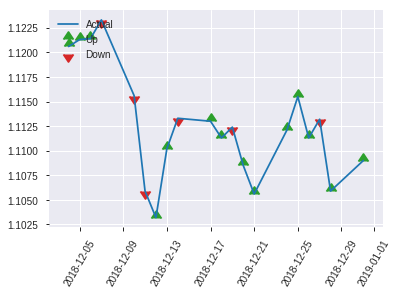


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.15427777383225544
RMSE: 0.3927820945922248
LogLoss: 0.47434855858347946
Mean Per-Class Error: 0.22284369460235953
AUC: 0.8612384620086803
pr_auc: 0.8682872510801023
Gini: 0.7224769240173605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46923293050858045: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   53   0.4309   (53.0/123.0)
1      9    124  0.0677   (9.0/133.0)
Total  79   177  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469233     0.8       151
max f2                       0.331975     0.894809  174
max f0point5                 0.571858     0.801217  89
max accuracy                 0.495895     0.777344  131
max precision                0.999916     1         0
max recall                   0.0051323    1         220
max specificity              0.999916     1         0
max absolute_mcc             0.495895     0.55416   131
max min_per_class_accuracy   0.495977     0.772358  130
max mean_per_class_accuracy  0.495895     0.777156  131

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 53.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.999794           1.92481   1.92481            1                0.99988    1                           0.99988             0.0225564       0.0225564                  92.4812    92.4812
    2        0.0234375                   0.999647           1.92481   1.92481            1                0.999728   1                           0.999804            0.0225564       0.0451128                  92.4812    92.4812
    3        0.03125                     0.999311           1.92481   1.92481            1                0.999431   1                           0.999711            0.0150376       0.0601504                  92.4812    92.4812
    4        0.0429688                   0.99852            1.92481   1.92481            1                0.998877   1                           0.999484            0.0225564       0.0827068                  92.4812    92.4812
    5        0.0507812                   0.998343           1.92481   1.92481            1                0.998433   1                           0.999322            0.0150376       0.0977444                  92.4812    92.4812
    6        0.101562                    0.993962           1.92481   1.92481            1                0.996726   1                           0.998024            0.0977444       0.195489                   92.4812    92.4812
    7        0.152344                    0.978079           1.77675   1.87546            0.923077         0.987946   0.974359                    0.994665            0.0902256       0.285714                   77.675     87.5458
    8        0.203125                    0.921754           1.92481   1.8878             1                0.947457   0.980769                    0.982863            0.0977444       0.383459                   92.4812    88.7796
    9        0.300781                    0.665049           1.30887   1.69983            0.68             0.802971   0.883117                    0.924456            0.12782         0.511278                   30.8872    69.9834
    10       0.402344                    0.520283           1.40659   1.62581            0.730769         0.577519   0.84466                     0.83688             0.142857        0.654135                   40.6593    62.5812
    11       0.5                         0.496575           1.0009    1.50376            0.52             0.502961   0.78125                     0.771661            0.0977444       0.75188                    0.0902256  50.3759
    12       0.617188                    0.495765           0.898246  1.38879            0.466667         0.495809   0.721519                    0.719284            0.105263        0.857143                   -10.1754   38.8788
    13       0.699219                    0.462199           0.916577  1.33339            0.47619          0.481942   0.692737                    0.69144             0.075188        0.932331                   -8.34228   33.3389
    14       0.800781                    0.255189           0.518219  1.23               0.269231         0.388468   0.639024                    0.653014            0.0526316       0.984962                   -48.1781   23.0002
    15       0.898438                    0.0205583          0         1.09631            0                0.0938162  0.569565                    0.592232            0               0.984962                   -100       9.6306
    16       1                           0.000839465        0.148062  1                  0.0769231        0.0083101  0.519531   

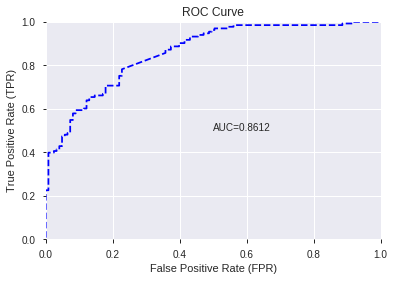

This function is available for GLM models only


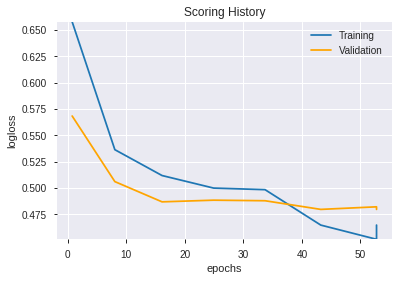

--2019-08-22 16:11:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_160137_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_160137_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'TRANGE',
 'ULTOSC',
 'CCI_8',
 'MINUS_DI_8',
 'BETA_30',
 'WILLR_12',
 'PLUS_DI_30',
 'MINUS_DI_30',
 'CDLGRAVESTONEDOJI',
 'CORREL_24',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'SAREXT',
 'CDLBELTHOLD',
 'CORREL_30',
 'MINUS_DI_20',
 'MINUS_DI_12',
 'PLUS_DI_8',
 'WILLR_8',
 'CCI_14',
 'CDLINVERTEDHAMMER',
 'WILLR_24',
 'CDLHAMMER',
 'MINUS_DM_8',
 'STOCHF_fastd',
 'MINUS_DI_24',
 'WILLR_20',
 'CCI_12',
 'STOCH_slowk',
 'aroonup_14',
 'WILLR_30',
 'ROCR100_8',
 'CDLSHOOTINGSTAR',
 'ROC_8',
 'CCI_24',
 'ROCP_8',
 'PLUS_DM_8',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'CCI_20',
 'MINUS_DM_14',
 'CDLHANGINGMAN',
 'MINUS_DM_12']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_161206_model_1  0.847851  0.485382              0.236781  0.400046  0.160037

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk             0.642609           1.000000    0.074897
1    CDLGRAVESTONEDOJI             0.636810           0.990976    0.074221
2           MINUS_DI_8             0.618328           0.962216    0.072067
3                CCI_8             0.561369           0.873578    0.065428
4     CDLDRAGONFLYDOJI             0.396229           0.616595    0.046181
5             WILLR_12             0.365305           0.568472    0.042577
6            CDLTAKURI             0.311339           0.484493    0.036287
7            PLUS_DI_8             0.305774           0.475833    0.035638
8             WILLR_30             0.301976           0.469922    0.035196
9            CORREL_24             0.276248           0.429885    0.032197
10          MINUS_DM_8             0.266799           0.415182    0.031096
11              CCI_14             0.226601           0.352627    0.026411
12              CCI_24             0.222024           0.345504    0.025877
13            WILLR_20             0.221897           0.345307    0.025862
14         MINUS_DI_12             0.210635           0.327781    0.024550
15               ROC_8             0.176211           0.274213    0.020538
16           ROCR100_8             0.175730           0.273464    0.020482
17              ROCP_8             0.175518           0.273134    0.020457
18         MINUS_DI_30             0.162437           0.252778    0.018932
19              CCI_20             0.148229           0.230668    0.017276
20         MINUS_DM_14             0.145230           0.226000    0.016927
21            WILLR_24             0.138034           0.214802    0.016088
22         MINUS_DI_24             0.138013           0.214770    0.016086
23   CDLINVERTEDHAMMER             0.127362           0.198195    0.014844
24           CORREL_30             0.125681           0.195580    0.014648
25              ULTOSC             0.124402           0.193589    0.014499
26  CDLCLOSINGMARUBOZU             0.113128           0.176044    0.013185
27           CDLHAMMER             0.110020           0.171209    0.012823
28          PLUS_DI_30             0.104089           0.161980    0.012132
29          PLUS_DM_12             0.094698           0.147365    0.011037
30           PLUS_DM_8             0.093817           0.145995    0.010935
31         MINUS_DI_14             0.093474           0.145461    0.010895
32     CDLSHOOTINGSTAR             0.089323           0.139001    0.010411
33              SAREXT             0.089016           0.138523    0.010375
34         MINUS_DI_20             0.084082           0.130845    0.009800
35          PLUS_DI_14             0.079385           0.123536    0.009252
36             BETA_30             0.060127           0.093566    0.007008
37         MINUS_DM_12             0.059436           0.092492    0.006927
38         CDLBELTHOLD             0.050130           0.078010    0.005843
39              TRANGE             0.041689           0.064875    0.004859
40          PLUS_DI_12             0.037989           0.059117    0.004428
41       CDLHANGINGMAN             0.034669           0.053951    0.004041
42         STOCH_slowk             0.028545           0.044421    0.003327
43        STOCHF_fastd             0.027425           0.042678    0.003196
44              CCI_12             0.026716           0.041574    0.003114
45             CDLDOJI             0.020254           0.031519    0.002361
46             WILLR_8             0.018387           0.028613    0.002143
47          aroonup_14             0.008948           0.013925    0.001043
48      CDLRICKSHAWMAN             0.007027           0.010934    0.000819
49   CDLLONGLEGGEDDOJI             0.006739           0.010487    0.000785

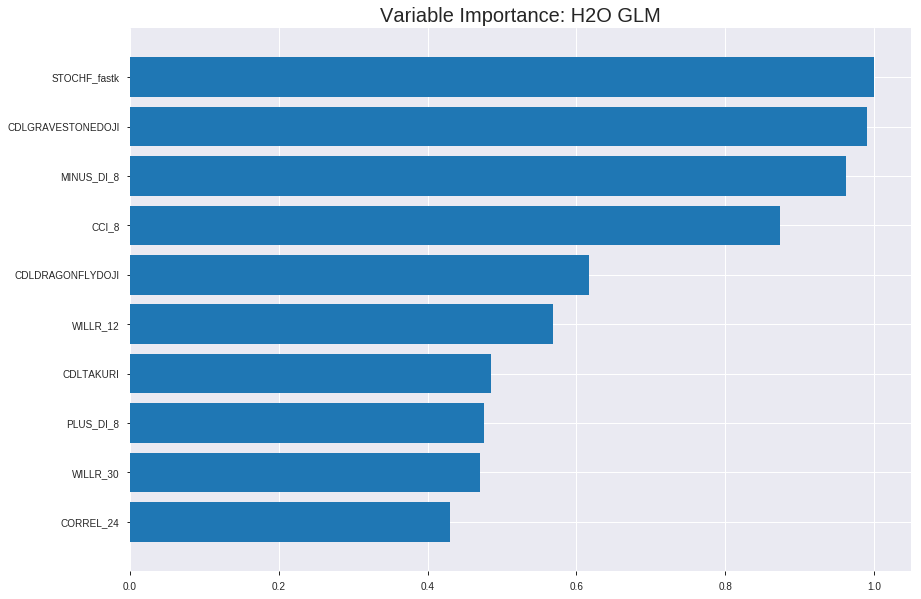

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161206_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17592168907760072
RMSE: 0.41943019571509244
LogLoss: 0.5216039097112193
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2478.551139037676
Residual deviance: 1865.25558112732
AIC: 1967.25558112732
AUC: 0.8143991531234828
pr_auc: 0.8109186645886924
Gini: 0.6287983062469655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41254500332175986: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      512  374   0.4221   (374.0/886.0)
1      127  775   0.1408   (127.0/902.0)
Total  639  1149  0.2802   (501.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412545     0.755729  249
max f2                       0.242009     0.862171  319
max f0point5                 0.589402     0.743576  166
max accuracy                 0.464849     0.735459  225
max precision                0.993934     1         0
max recall                   0.0438952    1         380
max specificity              0.993934     1         0
max absolute_mcc             0.464849     0.474612  225
max min_per_class_accuracy   0.515163     0.727273  203
max mean_per_class_accuracy  0.464849     0.734832  225

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.972647           1.98226    1.98226            1                0.981232  1                           0.981232            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.965174           1.87214    1.9272             0.944444         0.969302  0.972222                    0.975267            0.018847        0.0388027                  87.2136   92.7199
    3        0.0302013                   0.952548           1.87214    1.90884            0.944444         0.959404  0.962963                    0.969979            0.018847        0.0576497                  87.2136   90.8845
    4        0.0402685                   0.941702           1.87214    1.89967            0.944444         0.947879  0.958333                    0.964454            0.018847        0.0764967                  87.2136   89.9667
    5        0.0503356                   0.932161           1.98226    1.91619            1                0.936312  0.966667                    0.958826            0.0199557       0.0964523                  98.2262   91.6186
    6        0.100112                    0.884126           1.80408    1.86045            0.910112         0.909978  0.938547                    0.934538            0.0898004       0.186253                   80.4081   86.0447
    7        0.150447                    0.811818           1.58581    1.76856            0.8              0.849369  0.892193                    0.906043            0.0798226       0.266075                   58.5809   76.8561
    8        0.200224                    0.744463           1.67045    1.74417            0.842697         0.774106  0.879888                    0.873243            0.0831486       0.349224                   67.0445   74.4169
    9        0.300336                    0.645155           1.41748    1.63527            0.715084         0.691218  0.824953                    0.812568            0.141907        0.491131                   41.7483   63.5274
    10       0.399888                    0.573423           1.2584     1.54145            0.634831         0.609321  0.777622                    0.761969            0.125277        0.616408                   25.8402   54.1451
    11       0.5                         0.514328           1.10741    1.45455            0.558659         0.542306  0.733781                    0.717988            0.110865        0.727273                   10.7409   45.4545
    12       0.600112                    0.442427           0.952372   1.37077            0.480447         0.480153  0.691519                    0.678312            0.0953437       0.822616                   -4.76285  37.0772
    13       0.699664                    0.367028           0.746132   1.28189            0.376404         0.40517   0.646683                    0.639447            0.0742794       0.896896                   -25.3868  28.1894
    14       0.799776                    0.274258           0.598001   1.19629            0.301676         0.325387  0.603497                    0.600135            0.059867        0.956763                   -40.1999  19.6288
    15       0.899888                    0.0993948          0.332223   1.10016            0.167598         0.198856  0.555003                    0.555493            0.0332594       0.990022                   -66.7777  10.0161
    16       1                           0.00210538         0.0996668  1                  0.0502793        0.045877  0.504474                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16755311183476096
RMSE: 0.4093325198842146
LogLoss: 0.5033640714633921
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.5626222346018
Residual deviance: 514.4380810355867
AIC: 616.4380810355867
AUC: 0.8310044738616167
pr_auc: 0.8107621386282188
Gini: 0.6620089477232334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41171102641699964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      160  99   0.3822   (99.0/259.0)
1      31   221  0.123    (31.0/252.0)
Total  191  320  0.2544   (130.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411711     0.772727  243
max f2                       0.121857     0.866388  333
max f0point5                 0.629891     0.760638  132
max accuracy                 0.482559     0.753425  208
max precision                0.995293     1         0
max recall                   0.0505818    1         366
max specificity              0.995293     1         0
max absolute_mcc             0.411711     0.511257  243
max min_per_class_accuracy   0.51606      0.741313  191
max mean_per_class_accuracy  0.478646     0.754129  211

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.987247           2.02778    2.02778            1                0.99128    1                           0.99128             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.980835           1.62222    1.84343            0.8              0.983264   0.909091                    0.987636            0.015873        0.0396825                  62.2222   84.3434
    3        0.0313112                   0.960935           1.62222    1.77431            0.8              0.973795   0.875                       0.983311            0.015873        0.0555556                  62.2222   77.4306
    4        0.0410959                   0.955321           2.02778    1.83466            1                0.957283   0.904762                    0.977114            0.0198413       0.0753968                  102.778   83.4656
    5        0.0508806                   0.946874           2.02778    1.87179            1                0.951713   0.923077                    0.972229            0.0198413       0.0952381                  102.778   87.1795
    6        0.101761                    0.891842           1.71581    1.7938             0.846154         0.925521   0.884615                    0.948875            0.0873016       0.18254                    71.5812   79.3803
    7        0.150685                    0.832527           1.94667    1.84343            0.96             0.862669   0.909091                    0.920886            0.0952381       0.277778                   94.6667   84.3434
    8        0.201566                    0.760811           1.7938     1.83091            0.884615         0.793291   0.902913                    0.888678            0.0912698       0.369048                   79.3803   83.0906
    9        0.30137                     0.650244           1.35185    1.67226            0.666667         0.69821    0.824675                    0.825601            0.134921        0.503968                   35.1852   67.2258
    10       0.401174                    0.588215           1.27233    1.57276            0.627451         0.617118   0.77561                     0.773734            0.126984        0.630952                   27.2331   57.2764
    11       0.500978                    0.512539           1.11329    1.48123            0.54902          0.549541   0.730469                    0.729071            0.111111        0.742063                   11.329    48.1228
    12       0.600783                    0.435564           1.07353    1.4135             0.529412         0.472055   0.697068                    0.686374            0.107143        0.849206                   7.35294   41.35
    13       0.700587                    0.351517           0.596405   1.2971             0.294118         0.3893     0.639665                    0.644054            0.0595238       0.90873                    -40.3595  29.7098
    14       0.800391                    0.209891           0.636166   1.21468            0.313725         0.287677   0.599022                    0.599615            0.0634921       0.972222                   -36.3834  21.4684
    15       0.900196                    0.0616729          0.198802   1.10205            0.0980392        0.12272    0.543478                    0.546742            0.0198413       0.992063                   -80.1198  10.2053
    16       1                           0.00421857         0.0795207  1                  0.0392157        0.0349458  0.493151   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:12:06  0.000 sec   2            .15E2     51            1.3669329129956895  1.3628816216450592
     2019-08-22 16:12:06  0.011 sec   4            .96E1     51            1.3564169093868013  1.350003176851457
     2019-08-22 16:12:06  0.024 sec   6            .6E1      51            1.341143342288849   1.331358511795656
     2019-08-22 16:12:06  0.046 sec   8            .37E1     51            1.3200714167335696  1.3057435355056033
     2019-08-22 16:12:06  0.068 sec   10           .23E1     51            1.2929242777219312  1.2729068137737543
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:12:06  0.313 sec   38           .29E-2    51            1.0413591541767937  1.007382495011199
     2019-08-22 16:12:06  0.328 sec   40           .18E-2    51            1.04009132678824    1.008445241910381
     2019-08-22 16:12:06  0.341 sec   42           .11E-2    51            1.039173733012607   1.0093057984391405
     2019-08-22 16:12:06  0.359 sec   44           .7E-3     51            1.0385208367165037  1.00996522839541
     2019-08-22 16:12:06  0.368 sec   45           .43E-3    51            1.038063444669602   1.0104099260487969


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.8065573770491803)

('auc', 0.8478513356562137)

('logloss', 0.48538236475444774)

('mean_per_class_error', 0.23179900971942047)

('rmse', 0.4000458060462478)

('mse', 0.1600366469351921)

glm prediction progress: |████████████████████████████████████████████████| 100%


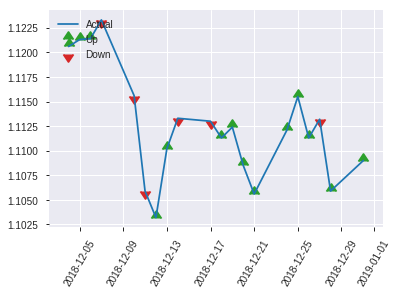


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1600366469351921
RMSE: 0.4000458060462478
LogLoss: 0.48538236475444774
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.73288115002356
Residual deviance: 248.5157707542772
AIC: 350.51577075427724
AUC: 0.8478513356562137
pr_auc: 0.8437695151732456
Gini: 0.6957026713124275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43759456966657256: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   49   0.3984   (49.0/123.0)
1      10   123  0.0752   (10.0/133.0)
Total  84   172  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437595     0.806557  171
max f2                       0.243705     0.886333  206
max f0point5                 0.569453     0.780031  126
max accuracy                 0.456581     0.773438  164
max precision                0.992513     1         0
max recall                   0.0293286    1         243
max specificity              0.992513     1         0
max absolute_mcc             0.437595     0.560172  171
max min_per_class_accuracy   0.564666     0.759398  129
max mean_per_class_accuracy  0.456581     0.768201  164

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 53.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.979002           1.92481   1.92481            1                0.986036   1                           0.986036            0.0225564       0.0225564                  92.4812    92.4812
    2        0.0234375                   0.966939           1.92481   1.92481            1                0.970504   1                           0.97827             0.0225564       0.0451128                  92.4812    92.4812
    3        0.03125                     0.961507           1.92481   1.92481            1                0.964825   1                           0.974909            0.0150376       0.0601504                  92.4812    92.4812
    4        0.0429688                   0.949121           1.92481   1.92481            1                0.954334   1                           0.969298            0.0225564       0.0827068                  92.4812    92.4812
    5        0.0507812                   0.935388           0.962406  1.77675            0.5              0.942805   0.923077                    0.965222            0.0075188       0.0902256                  -3.7594    77.675
    6        0.101562                    0.882787           1.92481   1.85078            1                0.915394   0.961538                    0.940308            0.0977444       0.18797                    92.4812    85.0781
    7        0.152344                    0.848684           1.92481   1.87546            1                0.866539   0.974359                    0.915718            0.0977444       0.285714                   92.4812    87.5458
    8        0.203125                    0.798862           1.1845    1.70272            0.615385         0.820209   0.884615                    0.891841            0.0601504       0.345865                   18.45      70.2718
    9        0.300781                    0.723438           1.61684   1.67484            0.84             0.758298   0.87013                     0.848483            0.157895        0.503759                   61.6842    67.4836
    10       0.402344                    0.624053           1.1845    1.55106            0.615385         0.677033   0.805825                    0.805204            0.120301        0.62406                    18.45      55.1062
    11       0.5                         0.56747            1.30887   1.50376            0.68             0.597412   0.78125                     0.76462             0.12782         0.75188                    30.8872    50.3759
    12       0.601562                    0.49341            0.888375  1.39986            0.461538         0.530867   0.727273                    0.725155            0.0902256       0.842105                   -11.1625   39.9863
    13       0.699219                    0.412918           1.0009    1.34414            0.52             0.449535   0.698324                    0.686661            0.0977444       0.93985                    0.0902256  34.4142
    14       0.800781                    0.251823           0.296125  1.21122            0.153846         0.34433    0.629268                    0.643243            0.0300752       0.969925                   -70.3875   21.1223
    15       0.898438                    0.0852542          0.153985  1.09631            0.08             0.169733   0.569565                    0.591775            0.0150376       0.984962                   -84.6015   9.6306
    16       1                           0.00392618         0.148062  1                  0.0769231        0.0366021  0.519531    

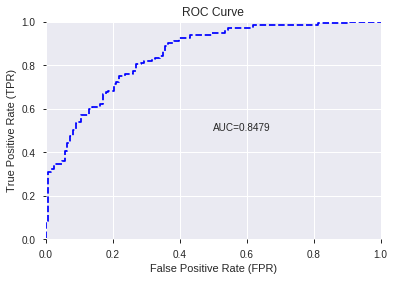

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


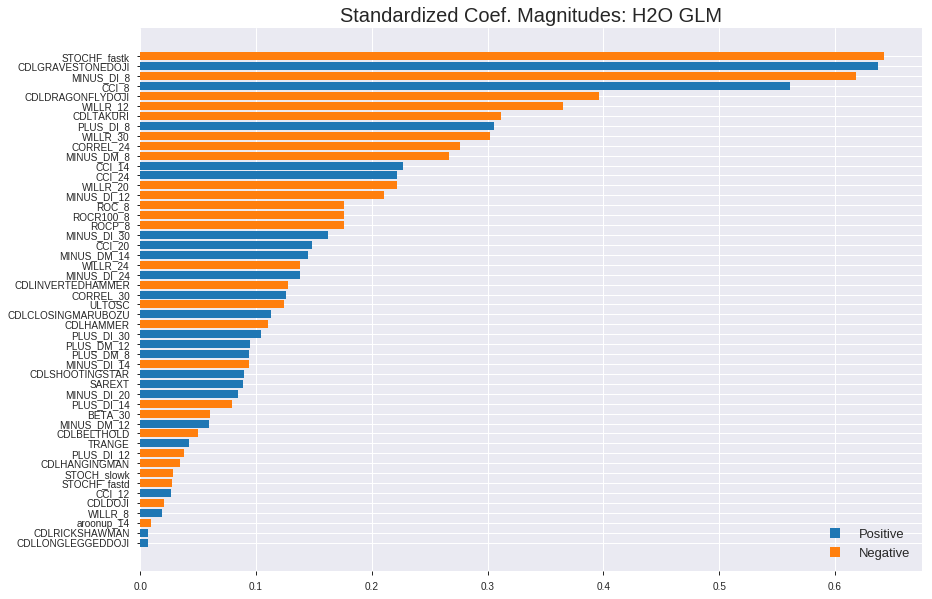

'log_likelihood'
--2019-08-22 16:12:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161206_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161206_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'CCI_8',
 'CDLDRAGONFLYDOJI',
 'WILLR_12',
 'CDLTAKURI',
 'PLUS_DI_8',
 'WILLR_30',
 'CORREL_24',
 'MINUS_DM_8',
 'CCI_14',
 'CCI_24',
 'WILLR_20',
 'MINUS_DI_12',
 'ROC_8',
 'ROCR100_8',
 'ROCP_8',
 'MINUS_DI_30',
 'CCI_20',
 'MINUS_DM_14',
 'WILLR_24',
 'MINUS_DI_24',
 'CDLINVERTEDHAMMER',
 'CORREL_30',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'PLUS_DI_30',
 'PLUS_DM_12',
 'PLUS_DM_8',
 'MINUS_DI_14',
 'CDLSHOOTINGSTAR',
 'SAREXT',
 'MINUS_DI_20',
 'PLUS_DI_14',
 'BETA_30',
 'MINUS_DM_12',
 'CDLBELTHOLD',
 'TRANGE',
 'PLUS_DI_12',
 'CDLHANGINGMAN',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_12',
 'CDLDOJI',
 'WILLR_8',
 'aroonup_14',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI']

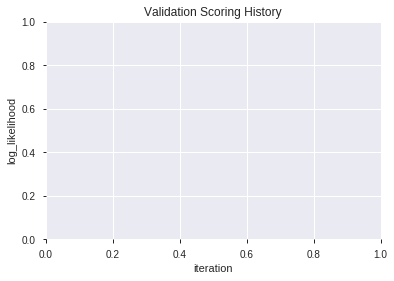

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190822_161216  0.850174  0.485031              0.215936  0.398797  0.159039
1  XGBoost_grid_1_AutoML_20190822_161216_model_4  0.843756  0.500292              0.248670  0.405276  0.164249
2  XGBoost_grid_1_AutoML_20190822_161216_model_6  0.843328  0.493645              0.222538  0.405131  0.164131
3  XGBoost_grid_1_AutoML_20190822_161216_model_5  0.841738  0.505909              0.216242  0.408448  0.166830
4               XGBoost_1_AutoML_20190822_161216  0.839844  0.505183              0.246531  0.409124  0.167383
5               XGBoost_3_AutoML_20190822_161216  0.836848  0.501486              0.246225  0.408974  0.167260
6  XGBoost_grid_1_AutoML_20190822_161216_model_3  0.836481  0.502735              0.240938  0.409002  0.167282
7  XGBoost_grid_1_AutoML_20190822_161216_model_2  0.830246  0.507436              0.280579  0.411955  0.169707
8  XGBoost_grid_1_AutoML_20190822_161216_model_7  0.829696  0.512074              0.250290  0.412838  0.170435
9  XGBoost_grid_1_AutoML_20190822_161216_model_1  0.828718  0.508624              0.248762  0.412537  0.170187

variable  relative_importance  scaled_importance  percentage
0    CDLDRAGONFLYDOJI          1024.981079           1.000000    0.116946
1   CDLGRAVESTONEDOJI           776.788696           0.757857    0.088628
2        STOCHF_fastk           429.538544           0.419070    0.049009
3            WILLR_12           385.314575           0.375924    0.043963
4              ULTOSC           379.157471           0.369917    0.043260
5               CCI_8           359.945770           0.351173    0.041068
6          MINUS_DI_8           357.097260           0.348394    0.040743
7           CORREL_24           269.632324           0.263061    0.030764
8            WILLR_24           241.369186           0.235486    0.027539
9            WILLR_20           240.692108           0.234826    0.027462
10             TRANGE           236.564255           0.230799    0.026991
11            WILLR_8           217.976898           0.212664    0.024870
12           WILLR_30           213.936249           0.208722    0.024409
13             CCI_12           209.120148           0.204023    0.023860
14          PLUS_DM_8           208.625046           0.203540    0.023803
15          CDLTAKURI           197.266510           0.192459    0.022507
16         PLUS_DI_30           189.957306           0.185328    0.021673
17              ROC_8           188.333725           0.183744    0.021488
18             SAREXT           183.542633           0.179069    0.020941
19             CCI_24           180.445526           0.176048    0.020588
20          CORREL_30           177.996994           0.173659    0.020309
21        MINUS_DI_24           156.755219           0.152935    0.017885
22        MINUS_DI_12           136.090149           0.132773    0.015527
23            BETA_30           135.560562           0.132257    0.015467
24        MINUS_DI_14           133.504837           0.130251    0.015232
25        STOCH_slowk           123.045471           0.120047    0.014039
26          PLUS_DI_8           120.950493           0.118003    0.013800
27        MINUS_DI_30           119.598991           0.116684    0.013646
28             CCI_14           118.655693           0.115764    0.013538
29         MINUS_DM_8           105.914978           0.103334    0.012084
30       STOCHF_fastd           105.178215           0.102615    0.012000
31     CDLRICKSHAWMAN            97.558228           0.095181    0.011131
32         PLUS_DM_12            94.819641           0.092509    0.010819
33         PLUS_DI_12            92.859207           0.090596    0.010595
34        MINUS_DM_14            91.766129           0.089530    0.010470
35        MINUS_DI_20            83.029404           0.081006    0.009473
36         PLUS_DI_14            82.321434           0.080315    0.009393
37             CCI_20            68.498398           0.066829    0.007815
38             ROCP_8            67.871048           0.066217    0.007744
39        MINUS_DM_12            52.394279           0.051117    0.005978
40         aroonup_14            47.928074           0.046760    0.005468
41  CDLLONGLEGGEDDOJI            31.184177           0.030424    0.003558
42            CDLDOJI            22.811787           0.022256    0.002603
43          ROCR100_8             7.992397           0.007798    0.000912

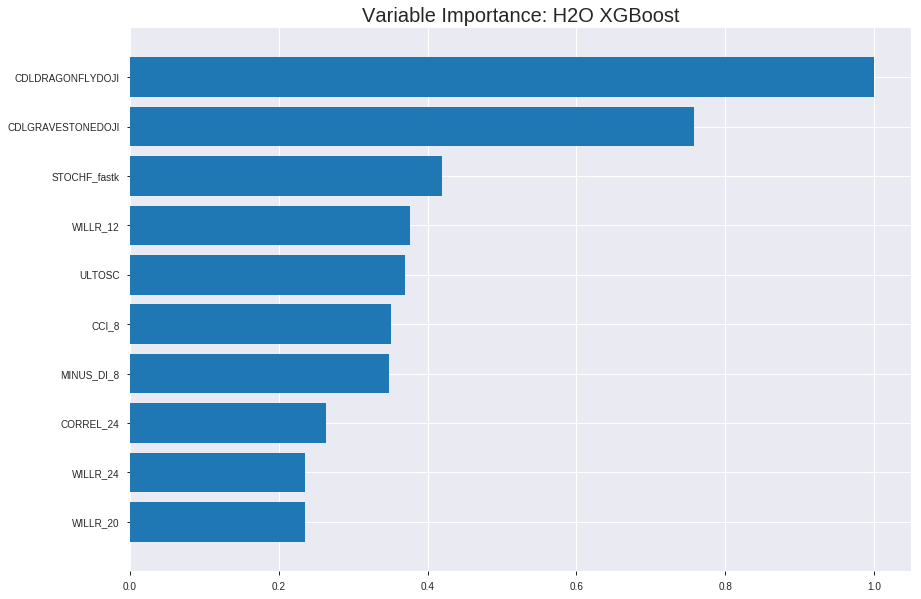

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190822_161216


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.125116674438674
RMSE: 0.3537183546816224
LogLoss: 0.40671040918692114
Mean Per-Class Error: 0.1483072480016817
AUC: 0.925645543137147
pr_auc: 0.9265263723611635
Gini: 0.851291086274294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49295856803655624: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      745  141  0.1591   (141.0/886.0)
1      124  778  0.1375   (124.0/902.0)
Total  869  919  0.1482   (265.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492959     0.854476  203
max f2                       0.343904     0.900351  271
max f0point5                 0.574447     0.880174  164
max accuracy                 0.492959     0.85179   203
max precision                0.955227     1         0
max recall                   0.0994984    1         372
max specificity              0.955227     1         0
max absolute_mcc             0.492959     0.703633  203
max min_per_class_accuracy   0.502092     0.848758  199
max mean_per_class_accuracy  0.492959     0.851693  203

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.937882           1.98226    1.98226            1                0.945696   1                           0.945696            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.926426           1.98226    1.98226            1                0.93023    1                           0.937963            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.915305           1.98226    1.98226            1                0.921601   1                           0.932509            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.909204           1.98226    1.98226            1                0.912684   1                           0.927553            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.904829           1.98226    1.98226            1                0.907104   1                           0.923463            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.874146           1.93772    1.96011            0.977528         0.889369   0.988827                    0.906511            0.0964523       0.196231                   93.7716   96.0113
    7        0.150447                    0.837489           1.93821    1.95279            0.977778         0.855781   0.98513                     0.889538            0.097561        0.293792                   93.8211   95.2786
    8        0.200224                    0.786654           1.8709     1.93243            0.94382          0.813079   0.97486                     0.87053             0.0931264       0.386918                   87.0899   93.2428
    9        0.300336                    0.68854            1.80508    1.88998            0.910615         0.734153   0.953445                    0.825071            0.18071         0.567627                   80.5076   88.9978
    10       0.399888                    0.600784           1.63704    1.82701            0.825843         0.645259   0.921678                    0.780307            0.162971        0.730599                   63.7036   82.7008
    11       0.5                         0.504547           1.15171    1.6918             0.581006         0.549422   0.853468                    0.734078            0.115299        0.845898                   15.1705   69.1796
    12       0.600112                    0.409376           0.73089    1.5315             0.368715         0.459416   0.7726                      0.688258            0.0731707       0.919069                   -26.911   53.1496
    13       0.699664                    0.331387           0.467725   1.38014            0.235955         0.371162   0.696243                    0.64314             0.0465632       0.965632                   -53.2275  38.0136
    14       0.799776                    0.241808           0.199334   1.23233            0.100559         0.285996   0.621678                    0.598435            0.0199557       0.985588                   -80.0666  23.2329
    15       0.899888                    0.117309           0.121815   1.10879            0.0614525        0.181994   0.559354                    0.552106            0.0121951       0.997783                   -87.8185  10.8785
    16       1                           0.038379           0.0221482  1                  0.0111732        0.0798652  0.504474 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1628020698423787
RMSE: 0.40348738498542763
LogLoss: 0.4896236044417057
Mean Per-Class Error: 0.24699699699699695
AUC: 0.8407489121774836
pr_auc: 0.8348331863787071
Gini: 0.6814978243549672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3363668918609619: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  109  0.4208   (109.0/259.0)
1      23   229  0.0913   (23.0/252.0)
Total  173  338  0.2583   (132.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336367     0.776271  270
max f2                       0.189273     0.876325  331
max f0point5                 0.638777     0.768398  136
max accuracy                 0.543634     0.753425  177
max precision                0.95242      1         0
max recall                   0.0761532    1         382
max specificity              0.95242      1         0
max absolute_mcc             0.336367     0.515445  270
max min_per_class_accuracy   0.491934     0.741313  203
max mean_per_class_accuracy  0.518581     0.753003  189

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 48.09 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.940703           2.02778    2.02778            1                0.946434   1                           0.946434            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.925551           2.02778    2.02778            1                0.931661   1                           0.939719            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.917444           2.02778    2.02778            1                0.919557   1                           0.933418            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.901902           2.02778    2.02778            1                0.910549   1                           0.927973            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.897402           1.62222    1.94979            0.8              0.899222   0.961538                    0.922444            0.015873        0.0992063                  62.2222   94.9786
    6        0.101761                    0.864689           1.94979    1.94979            0.961538         0.883314   0.961538                    0.902879            0.0992063       0.198413                   94.9786   94.9786
    7        0.150685                    0.80863            1.78444    1.8961             0.88             0.834688   0.935065                    0.880739            0.0873016       0.285714                   78.4444   89.6104
    8        0.201566                    0.755415           1.71581    1.85059            0.846154         0.77784    0.912621                    0.854765            0.0873016       0.373016                   71.5812   85.0593
    9        0.30137                     0.674433           1.47113    1.72493            0.72549          0.718869   0.850649                    0.80976             0.146825        0.519841                   47.1133   72.4928
    10       0.401174                    0.567924           1.19281    1.59255            0.588235         0.617529   0.785366                    0.761937            0.119048        0.638889                   19.281    59.2547
    11       0.500978                    0.4877             1.07353    1.48915            0.529412         0.528717   0.734375                    0.715475            0.107143        0.746032                   7.35294   48.9149
    12       0.600783                    0.404118           0.954248   1.40029            0.470588         0.441601   0.690554                    0.669978            0.0952381       0.84127                    -4.57516  40.029
    13       0.700587                    0.299827           0.874728   1.32542            0.431373         0.344934   0.653631                    0.623673            0.0873016       0.928571                   -12.5272  32.5419
    14       0.800391                    0.184423           0.556645   1.22956            0.27451          0.236887   0.606357                    0.575443            0.0555556       0.984127                   -44.3355  22.9557
    15       0.900196                    0.093048           0.0397603  1.09764            0.0196078        0.128174   0.541304                    0.525854            0.00396825      0.988095                   -96.024   9.76449
    16       1                           0.0479976          0.119281   1                  0.0588235        0.0753424  0.493151  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:12:19  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.495526                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-08-22 16:12:19  0.063 sec   5                  0.470464         0.635358            0.842655        0.805557           1.98226          0.249441                         0.468815           0.632174              0.832782          0.806256             2.02778            0.268102
    2019-08-22 16:12:19  0.110 sec   10                 0.449257         0.594533            0.862446        0.856451           1.98226          0.215884                         0.448459           0.59266               0.835563          0.828495             2.02778            0.264188
    2019-08-22 16:12:19  0.164 sec   15                 0.433681         0.564187            0.870311        0.865808           1.98226          0.213087                         0.43508            0.565709              0.837485          0.83515              2.02778            0.242661
    2019-08-22 16:12:19  0.216 sec   20                 0.42155          0.540191            0.87712         0.876541           1.98226          0.204139                         0.425698           0.545871              0.838795          0.839219             2.02778            0.244618
    2019-08-22 16:12:19  0.270 sec   25                 0.411406         0.520061            0.885512        0.883395           1.98226          0.204698                         0.418716           0.530644              0.839914          0.837202             2.02778            0.246575
    2019-08-22 16:12:19  0.323 sec   30                 0.40291          0.503096            0.890278        0.88969            1.98226          0.192953                         0.414506           0.520784              0.839952          0.834778             2.02778            0.264188
    2019-08-22 16:12:19  0.383 sec   35                 0.395538         0.488147            0.893561        0.894847           1.98226          0.193512                         0.410202           0.51075               0.842319          0.833271             2.02778            0.268102
    2019-08-22 16:12:19  0.440 sec   40                 0.389195         0.475298            0.896198        0.897981           1.98226          0.191275                         0.407649           0.504209              0.841921          0.837666             2.02778            0.264188
    2019-08-22 16:12:19  0.494 sec   45                 0.383076         0.463563            0.901691        0.901276           1.98226          0.18736                          0.406385           0.500986              0.84212           0.832597             2.02778            0.270059
    2019-08-22 16:12:19  0.550 sec   50                 0.377772         0.45306             0.905858        0.905345           1.98226          0.184564                         0.404909           0.497237              0.843691          0.838021             2.02778            0.268102
    2019-08-22 16:12:19  0.611 sec   55                 0.373378         0.444562            0.909851        0.91144            1.98226          0.1717                           0.404299           0.495137              0.843514          0

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLDRAGONFLYDOJI   1024.9810791015625     1.0                   0.11694594816721257
CDLGRAVESTONEDOJI  776.7886962890625      0.7578566201143433    0.0886282610140709
STOCHF_fastk       429.5385437011719      0.419069729636063     0.049008506880466804
WILLR_12           385.3145751953125      0.37592359805612835   0.04396274161310404
ULTOSC             379.157470703125       0.36991655595776646   0.04326024237923074
---                ---                    ---                   ---
MINUS_DM_12        52.39427947998047      0.05111731381998405   0.005977962732438994
aroonup_14         47.92807388305664      0.04675995963268663   0.0054683878155051225
CDLLONGLEGGEDDOJI  31.18417739868164      0.030424149317971643  0.0035579809891710472
CDLDOJI            22.811786651611328     0.022255812440564057  0.002602727088093409
ROCR100_8          7.992396831512451      0.007797604262625132  0.0009118982239253945


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7890625)

('F1', 0.7970479704797048)

('auc', 0.8501742160278746)

('logloss', 0.4850307609572537)

('mean_per_class_error', 0.21125985695947191)

('rmse', 0.3987967544781272)

('mse', 0.15903885138228765)

xgboost prediction progress: |████████████████████████████████████████████| 100%


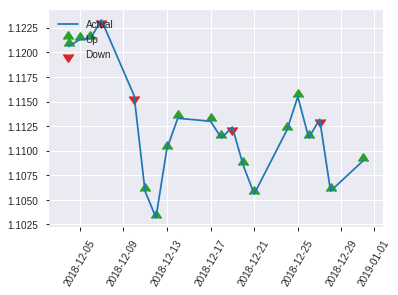


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15903885138228765
RMSE: 0.3987967544781272
LogLoss: 0.4850307609572537
Mean Per-Class Error: 0.21125985695947191
AUC: 0.8501742160278746
pr_auc: 0.8599218991693635
Gini: 0.7003484320557491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5164102911949158: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      93   30   0.2439   (30.0/123.0)
1      25   108  0.188    (25.0/133.0)
Total  118  138  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51641      0.797048  137
max f2                       0.167308     0.874832  210
max f0point5                 0.623908     0.813743  104
max accuracy                 0.539521     0.789062  132
max precision                0.956957     1         0
max recall                   0.0568543    1         253
max specificity              0.956957     1         0
max absolute_mcc             0.539521     0.57748   132
max min_per_class_accuracy   0.543713     0.780488  130
max mean_per_class_accuracy  0.539521     0.78874   132

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 52.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.944696           1.92481   1.92481            1                0.950938  1                           0.950938            0.0225564       0.0225564                  92.4812    92.4812
    2        0.0234375                   0.937335           1.92481   1.92481            1                0.940479  1                           0.945708            0.0225564       0.0451128                  92.4812    92.4812
    3        0.03125                     0.921636           1.92481   1.92481            1                0.925625  1                           0.940687            0.0150376       0.0601504                  92.4812    92.4812
    4        0.0429688                   0.918556           1.92481   1.92481            1                0.919126  1                           0.934807            0.0225564       0.0827068                  92.4812    92.4812
    5        0.0507812                   0.914482           1.92481   1.92481            1                0.916624  1                           0.93201             0.0150376       0.0977444                  92.4812    92.4812
    6        0.101562                    0.889021           1.77675   1.85078            0.923077         0.902627  0.961538                    0.917318            0.0902256       0.18797                    77.675     85.0781
    7        0.152344                    0.8567             1.92481   1.87546            1                0.871601  0.974359                    0.902079            0.0977444       0.285714                   92.4812    87.5458
    8        0.203125                    0.819461           1.48062   1.77675            0.769231         0.837371  0.923077                    0.885902            0.075188        0.360902                   48.0625    77.675
    9        0.300781                    0.731337           1.61684   1.72483            0.84             0.785942  0.896104                    0.853447            0.157895        0.518797                   61.6842    72.4832
    10       0.402344                    0.625917           1.40659   1.6445             0.730769         0.678954  0.854369                    0.8094              0.142857        0.661654                   40.6593    64.45
    11       0.5                         0.553548           1.0009    1.5188             0.52             0.58344   0.789062                    0.765268            0.0977444       0.759398                   0.0902256  51.8797
    12       0.601562                    0.465879           0.666281  1.37487            0.346154         0.510451  0.714286                    0.722247            0.0676692       0.827068                   -33.3719   37.4866
    13       0.699219                    0.363254           0.769925  1.29038            0.4              0.411298  0.670391                    0.678818            0.075188        0.902256                   -23.0075   29.0377
    14       0.800781                    0.221755           0.59225   1.20183            0.307692         0.294012  0.62439                     0.630013            0.0601504       0.962406                   -40.775    20.1834
    15       0.898438                    0.101061           0.230977  1.09631            0.12             0.141773  0.569565                    0.576944            0.0225564       0.984962                   -76.9023   9.6306
    16       1                           0.0482199          0.148062  1                  0.0769231        0.082455  0.519531                    0.52

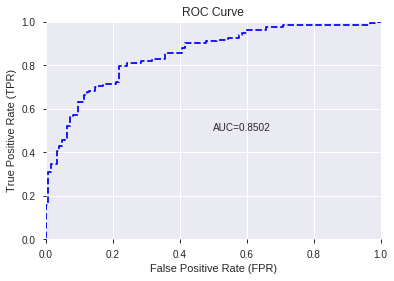

This function is available for GLM models only


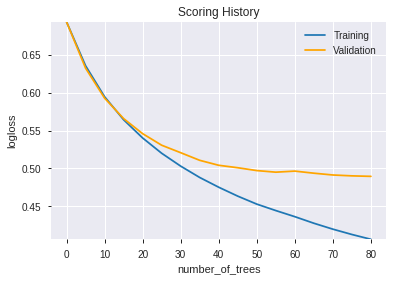

--2019-08-22 16:12:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


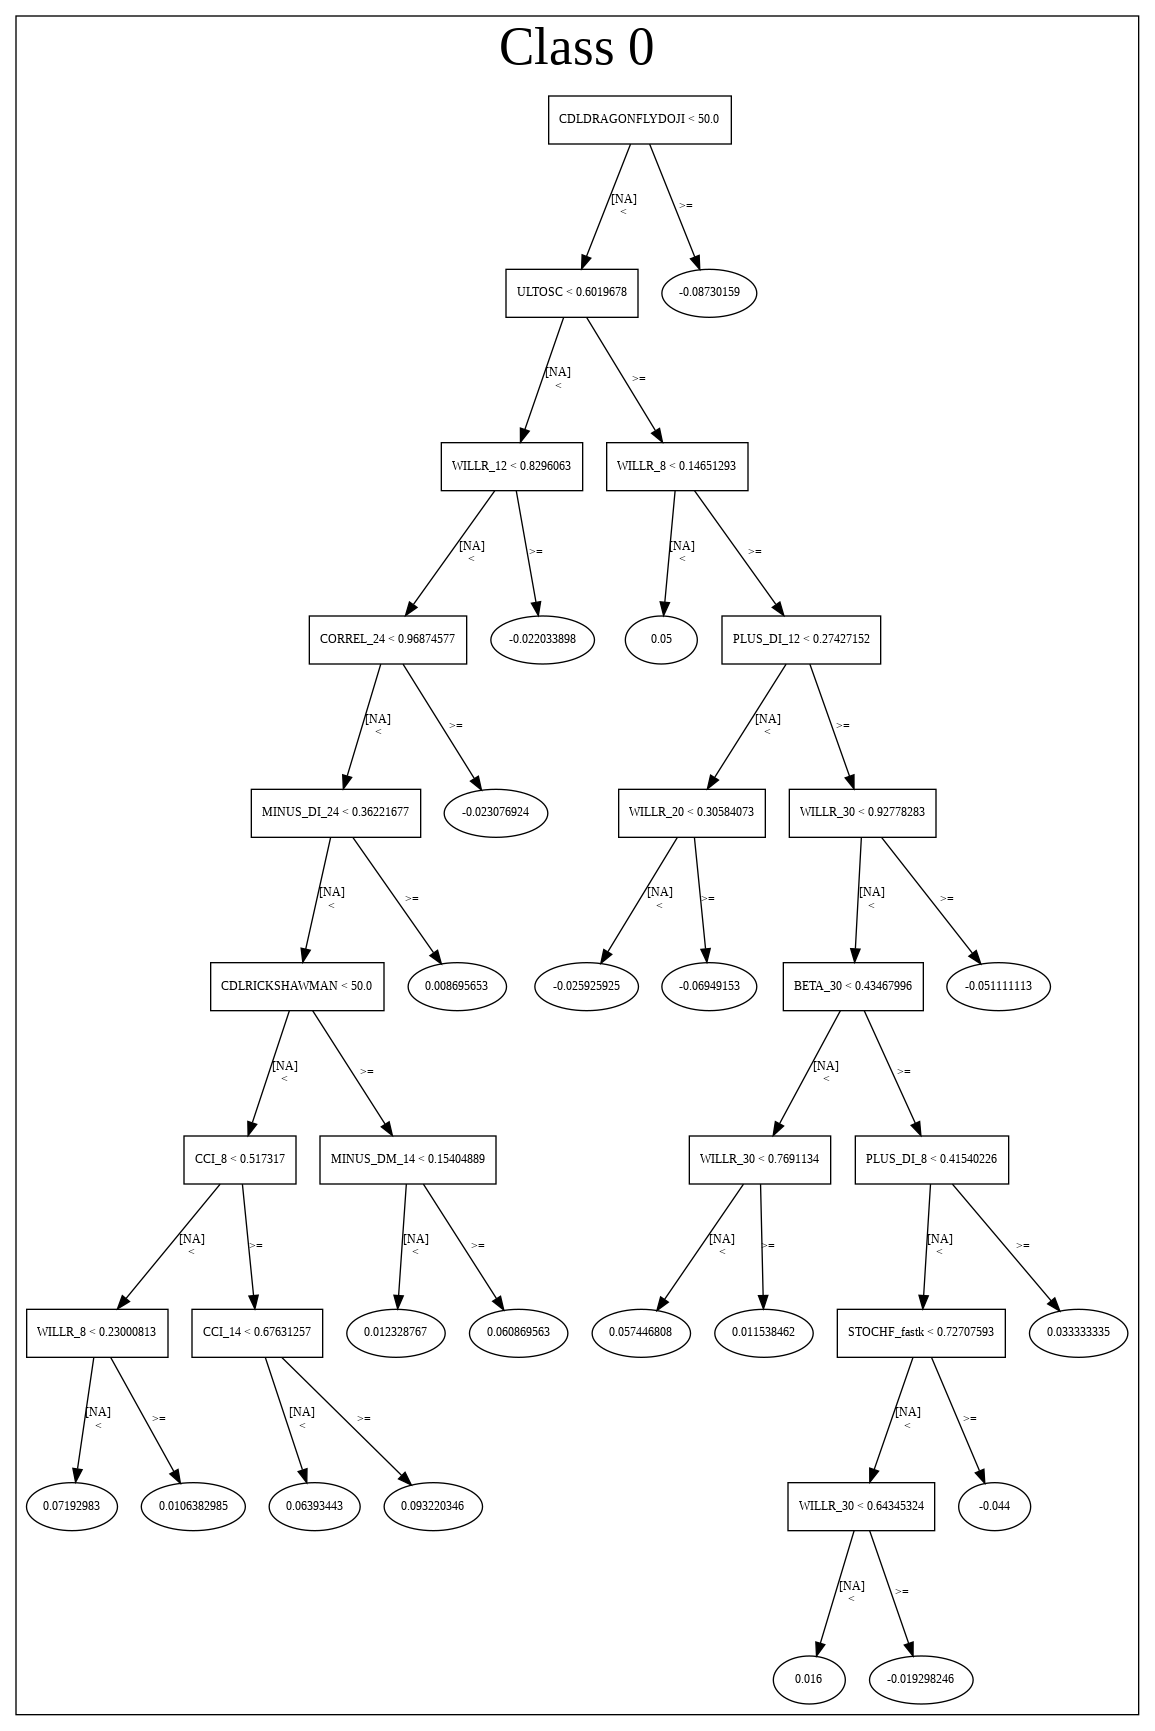

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190822_161216',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190822_161216',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_9e4e',
   'type

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'WILLR_12',
 'ULTOSC',
 'CCI_8',
 'MINUS_DI_8',
 'CORREL_24',
 'WILLR_24',
 'WILLR_20',
 'TRANGE',
 'WILLR_8',
 'WILLR_30',
 'CCI_12',
 'PLUS_DM_8',
 'CDLTAKURI',
 'PLUS_DI_30',
 'ROC_8',
 'SAREXT',
 'CCI_24',
 'CORREL_30',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'BETA_30',
 'MINUS_DI_14',
 'STOCH_slowk',
 'PLUS_DI_8',
 'MINUS_DI_30',
 'CCI_14',
 'MINUS_DM_8',
 'STOCHF_fastd',
 'CDLRICKSHAWMAN',
 'PLUS_DM_12',
 'PLUS_DI_12',
 'MINUS_DM_14',
 'MINUS_DI_20',
 'PLUS_DI_14',
 'CCI_20',
 'ROCP_8',
 'MINUS_DM_12',
 'aroonup_14',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'ROCR100_8']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_161244_model_1  0.845834  0.487927               0.21991  0.399936  0.159948

variable  relative_importance  scaled_importance    percentage
0                         MULT             0.843149           1.000000  1.200708e-02
1                          Low             0.794798           0.942653  1.131852e-02
2                         High             0.787274           0.933730  1.121138e-02
3                     WILLR_30             0.776971           0.921511  1.106466e-02
4                          ADD             0.765552           0.907967  1.090204e-02
...                        ...                  ...                ...           ...
1016  BBANDS_middleband_12_3_2             0.000156           0.000185  2.226386e-06
1017         MACDFIX_signal_14             0.000106           0.000126  1.511158e-06
1018                    TSF_14             0.000089           0.000105  1.263132e-06
1019   BBANDS_lowerband_12_5_3             0.000030           0.000035  4.209869e-07
1020  BBANDS_middleband_12_1_3             0.000023           0.000027  3.232010e-07

[1021 rows x 4 columns]

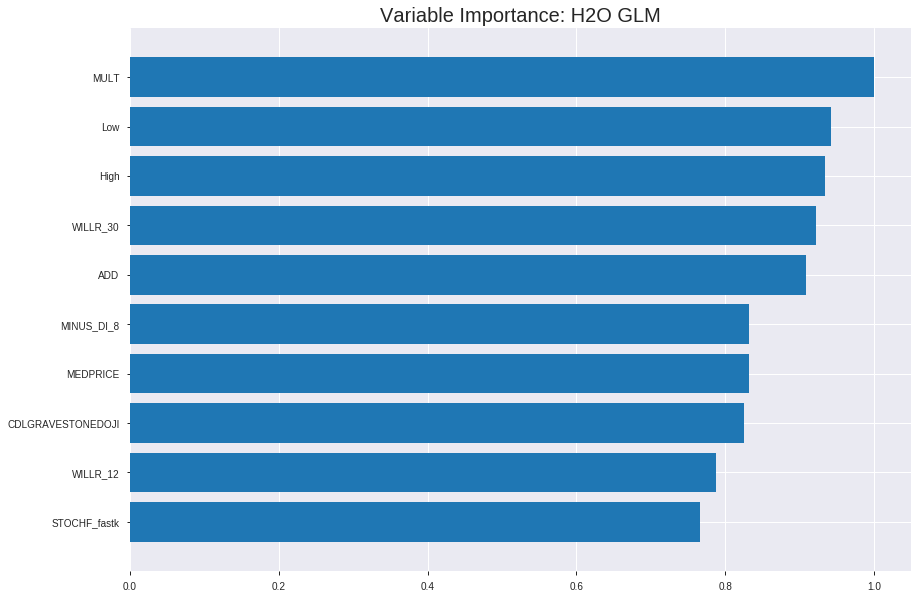

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161244_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15421427707446128
RMSE: 0.39270125677728773
LogLoss: 0.4690093866098249
Null degrees of freedom: 1787
Residual degrees of freedom: 766
Null deviance: 2478.551139037676
Residual deviance: 1677.1775665167338
AIC: 3721.177566516734
AUC: 0.8584397351258554
pr_auc: 0.8544524013831052
Gini: 0.7168794702517107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4214897360954536: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      600  286   0.3228   (286.0/886.0)
1      133  769   0.1475   (133.0/902.0)
Total  733  1055  0.2343   (419.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42149      0.785897  231
max f2                       0.211925     0.870127  315
max f0point5                 0.634724     0.79526   146
max accuracy                 0.521252     0.772371  192
max precision                0.998521     1         0
max recall                   0.020714     1         389
max specificity              0.998521     1         0
max absolute_mcc             0.571876     0.547705  171
max min_per_class_accuracy   0.518914     0.771619  193
max mean_per_class_accuracy  0.521252     0.772418  192

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.990469           1.87214    1.87214            0.944444         0.993995   0.944444                    0.993995            0.018847        0.018847                   87.2136   87.2136
    2        0.0201342                   0.982021           1.98226    1.9272             1                0.986439   0.972222                    0.990217            0.0199557       0.0388027                  98.2262   92.7199
    3        0.0302013                   0.974641           1.98226    1.94555            1                0.978431   0.981481                    0.986288            0.0199557       0.0587583                  98.2262   94.5553
    4        0.0402685                   0.963807           1.98226    1.95473            1                0.969571   0.986111                    0.982109            0.0199557       0.078714                   98.2262   95.473
    5        0.0503356                   0.957344           1.76201    1.91619            0.888889         0.960366   0.966667                    0.977761            0.0177384       0.0964523                  76.201    91.6186
    6        0.100112                    0.910596           1.8709     1.89367            0.94382          0.935702   0.955307                    0.956849            0.0931264       0.189579                   87.0899   89.3669
    7        0.150447                    0.85939            1.78404    1.85699            0.9              0.883703   0.936803                    0.932376            0.0898004       0.279379                   78.4035   85.6989
    8        0.200224                    0.80641            1.78181    1.8383             0.898876         0.834475   0.927374                    0.908038            0.0886918       0.368071                   78.1808   83.8299
    9        0.300336                    0.693817           1.60574    1.76078            0.810056         0.746859   0.888268                    0.854311            0.160754        0.528825                   60.5743   76.078
    10       0.399888                    0.601178           1.33636    1.65512            0.674157         0.646839   0.834965                    0.802661            0.133038        0.661863                   33.6356   65.5119
    11       0.5                         0.518727           1.07419    1.5388             0.541899         0.559562   0.776286                    0.753987            0.107539        0.769401                   7.41865   53.8803
    12       0.600112                    0.410191           0.897001   1.43174            0.452514         0.46513    0.722274                    0.705799            0.0898004       0.859202                   -10.2999  43.1736
    13       0.699664                    0.318939           0.701587   1.32785            0.353933         0.368299   0.669864                    0.657778            0.0698448       0.929047                   -29.8413  32.7846
    14       0.799776                    0.206734           0.420815   1.21431            0.212291         0.26382    0.612587                    0.608464            0.0421286       0.971175                   -57.9185  21.4309
    15       0.899888                    0.077205           0.24363    1.10632            0.122905         0.14522    0.558111                    0.556929            0.0243902       0.995565                   -75.637   10.6321
    16       1                           0.000246876        0.0442963  1                  0.0223464        0.0329721  0.504474   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16081371039123787
RMSE: 0.4010158480549589
LogLoss: 0.47963144314344325
Null degrees of freedom: 510
Residual degrees of freedom: -511
Null deviance: 708.5626222346018
Residual deviance: 490.183334892599
AIC: 2534.183334892599
AUC: 0.8465710608567751
pr_auc: 0.8374290217440283
Gini: 0.6931421217135503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3819136264178266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      159  100  0.3861   (100.0/259.0)
1      27   225  0.1071   (27.0/252.0)
Total  186  325  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381914     0.779896  254
max f2                       0.108594     0.874912  331
max f0point5                 0.678411     0.782563  138
max accuracy                 0.539306     0.763209  193
max precision                0.998598     1         0
max recall                   0.0324144    1         375
max specificity              0.998598     1         0
max absolute_mcc             0.381914     0.526564  254
max min_per_class_accuracy   0.526437     0.756757  200
max mean_per_class_accuracy  0.535208     0.763085  196

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 49.73 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.995078           2.02778    2.02778            1                0.997293   1                           0.997293            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.987491           2.02778    2.02778            1                0.991424   1                           0.994625            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.982385           2.02778    2.02778            1                0.98573    1                           0.991846            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.976653           2.02778    2.02778            1                0.979386   1                           0.988879            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.963582           1.62222    1.94979            0.8              0.967878   0.961538                    0.98484             0.015873        0.0992063                  62.2222   94.9786
    6        0.101761                    0.923315           1.94979    1.94979            0.961538         0.945828   0.961538                    0.965334            0.0992063       0.198413                   94.9786   94.9786
    7        0.150685                    0.869658           1.78444    1.8961             0.88             0.888899   0.935065                    0.940518            0.0873016       0.285714                   78.4444   89.6104
    8        0.201566                    0.803855           1.71581    1.85059            0.846154         0.83688    0.912621                    0.914357            0.0873016       0.373016                   71.5812   85.0593
    9        0.30137                     0.723488           1.55065    1.75126            0.764706         0.764588   0.863636                    0.864758            0.154762        0.527778                   55.0654   75.1263
    10       0.401174                    0.610878           1.15305    1.60244            0.568627         0.664334   0.790244                    0.814896            0.115079        0.642857                   15.305    60.2439
    11       0.500978                    0.520897           1.19281    1.52083            0.588235         0.563205   0.75                        0.764755            0.119048        0.761905                   19.281    52.0833
    12       0.600783                    0.419888           0.954248   1.42671            0.470588         0.472438   0.703583                    0.716194            0.0952381       0.857143                   -4.57516  42.671
    13       0.700587                    0.283741           0.556645   1.30276            0.27451          0.356934   0.642458                    0.665014            0.0555556       0.912698                   -44.3355  30.2762
    14       0.800391                    0.124202           0.636166   1.21964            0.313725         0.219804   0.601467                    0.609499            0.0634921       0.97619                    -36.3834  21.9641
    15       0.900196                    0.0455213          0.198802   1.10646            0.0980392        0.0743419  0.545652                    0.550167            0.0198413       0.996032                   -80.1198  10.6461
    16       1                           3.67827e-05        0.0397603  1                  0.0196078        0.0207863  0.493151  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:12:47  0.000 sec   2            .15E2     1008          1.3614574796962429  1.3602741449222842
     2019-08-22 16:12:49  1.972 sec   4            .11E2     1017          1.3533080350708664  1.3515876750621105
     2019-08-22 16:12:51  3.934 sec   6            .82E1     1017          1.3428925819093889  1.3404975723063162
     2019-08-22 16:12:53  5.900 sec   8            .6E1      1019          1.3298480386227212  1.3265723021706262
     2019-08-22 16:12:55  7.828 sec   10           .43E1     1020          1.3139343895174433  1.3096312191666641
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:13:37  49.318 sec  52           .55E-2    1022          0.9659833784482446  0.9692100505260998
     2019-08-22 16:13:39  51.491 sec  54           .4E-2     1022          0.9588562771953424  0.9650653973499361
     2019-08-22 16:13:41  53.585 sec  56           .29E-2    1022          0.9518880210194607  0.9621494995636157
     2019-08-22 16:13:43  55.635 sec  58           .21E-2    1022          0.944962009148014   0.9602828945773308
     2019-08-22 16:13:45  57.661 sec  60           .15E-2    1022          0.9380187732196492  0.9592628862868865


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78515625)

('F1', 0.8148148148148148)

('auc', 0.8458340974387187)

('logloss', 0.48792663251665314)

('mean_per_class_error', 0.2199095299223669)

('rmse', 0.3999355840372311)

('mse', 0.15994847137920115)

glm prediction progress: |████████████████████████████████████████████████| 100%


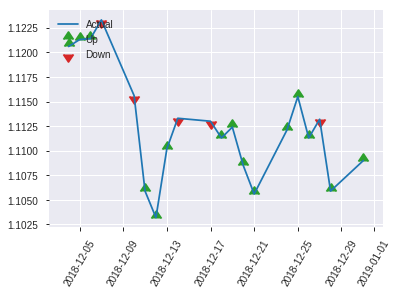


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15994847137920115
RMSE: 0.3999355840372311
LogLoss: 0.48792663251665314
Null degrees of freedom: 255
Residual degrees of freedom: -766
Null deviance: 354.73288115002356
Residual deviance: 249.81843584852643
AIC: 2293.8184358485264
AUC: 0.8458340974387187
pr_auc: 0.8385589588208501
Gini: 0.6916681948774375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4343416996734848: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   43   0.3496   (43.0/123.0)
1      12   121  0.0902   (12.0/133.0)
Total  92   164  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434342     0.814815  163
max f2                       0.191593     0.880759  205
max f0point5                 0.648144     0.783133  111
max accuracy                 0.434342     0.785156  163
max precision                0.995571     1         0
max recall                   0.0155422    1         248
max specificity              0.995571     1         0
max absolute_mcc             0.434342     0.583299  163
max min_per_class_accuracy   0.570701     0.764228  130
max mean_per_class_accuracy  0.434342     0.78009   163

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 53.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.991411           1.92481    1.92481            1                0.994109   1                           0.994109            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.983762           1.92481    1.92481            1                0.98759    1                           0.99085             0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.978746           0.962406   1.68421            0.5              0.980203   0.875                       0.988188            0.0075188       0.0526316                  -3.7594   68.4211
    4        0.0429688                   0.972153           1.92481    1.74983            1                0.976274   0.909091                    0.984939            0.0225564       0.075188                   92.4812   74.9829
    5        0.0507812                   0.967708           1.92481    1.77675            1                0.969009   0.923077                    0.982488            0.0150376       0.0902256                  92.4812   77.675
    6        0.101562                    0.934614           1.92481    1.85078            1                0.949519   0.961538                    0.966004            0.0977444       0.18797                    92.4812   85.0781
    7        0.152344                    0.901623           1.77675    1.8261             0.923077         0.917488   0.948718                    0.949832            0.0902256       0.278195                   77.675    82.6104
    8        0.203125                    0.859303           1.62869    1.77675            0.846154         0.880732   0.923077                    0.932557            0.0827068       0.360902                   62.8687   77.675
    9        0.300781                    0.75664            1.38586    1.64984            0.72             0.802298   0.857143                    0.890265            0.135338        0.496241                   38.5865   64.9839
    10       0.402344                    0.676803           1.25853    1.55106            0.653846         0.715452   0.805825                    0.846137            0.12782         0.62406                    25.8531   55.1062
    11       0.5                         0.586577           1.23188    1.48872            0.64             0.634461   0.773438                    0.804794            0.120301        0.744361                   23.188    48.8722
    12       0.601562                    0.459244           1.11047    1.42486            0.576923         0.525762   0.74026                     0.757685            0.112782        0.857143                   11.0468   42.4861
    13       0.699219                    0.373646           0.769925   1.33339            0.4              0.420589   0.692737                    0.710604            0.075188        0.932331                   -23.0075  33.3389
    14       0.800781                    0.194616           0.370156   1.21122            0.192308         0.280633   0.629268                    0.656071            0.037594        0.969925                   -62.9844  21.1223
    15       0.898438                    0.0483611          0.230977   1.10467            0.12             0.120985   0.573913                    0.59791             0.0225564       0.992481                   -76.9023  10.4675
    16       1                           0.000738413        0.0740312  1                  0.0384615        0.0247444  0.519531   

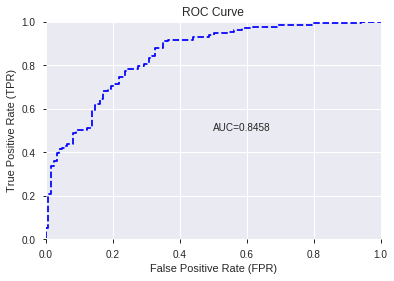

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


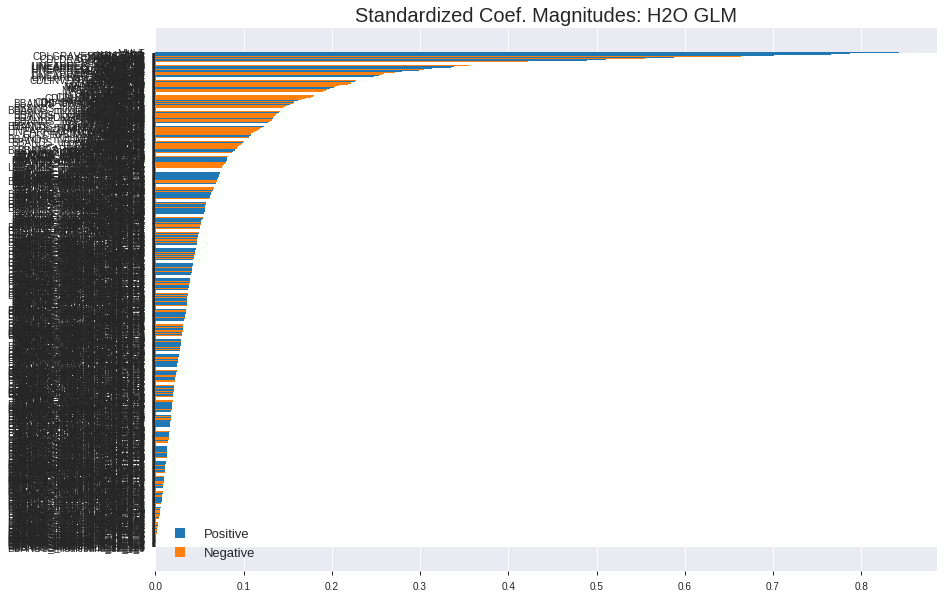

'log_likelihood'
--2019-08-22 16:14:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


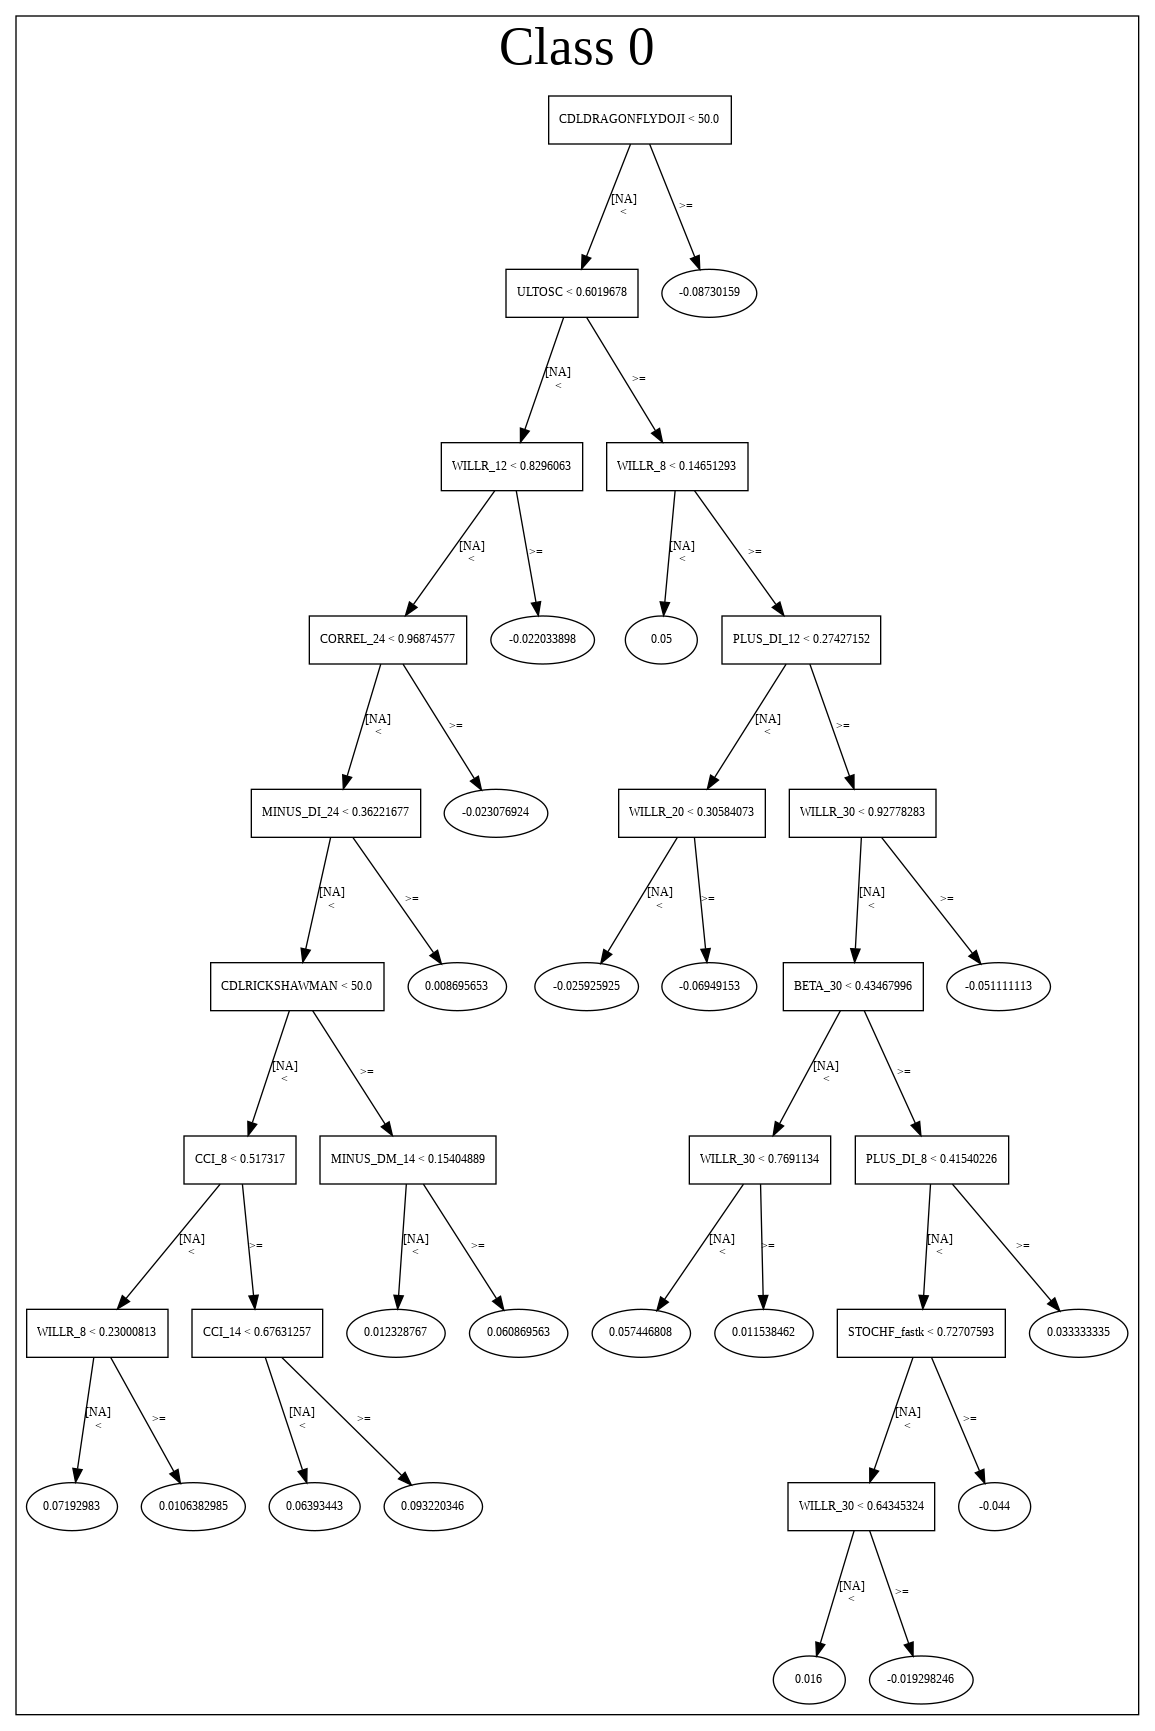

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161244_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161244_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

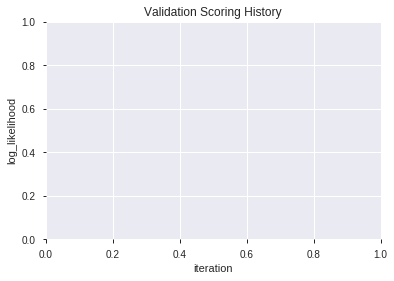

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_161413_model_4  0.848585  0.513825              0.228437  0.412373  0.170052
1               XGBoost_1_AutoML_20190822_161413  0.840760  0.518089              0.222752  0.415473  0.172618
2  XGBoost_grid_1_AutoML_20190822_161413_model_3  0.836970  0.520569              0.239104  0.418523  0.175162
3               XGBoost_2_AutoML_20190822_161413  0.835565  0.518996              0.265236  0.416602  0.173558
4  XGBoost_grid_1_AutoML_20190822_161413_model_6  0.830919  0.526635              0.227214  0.419752  0.176192
5  XGBoost_grid_1_AutoML_20190822_161413_model_2  0.829635  0.526262              0.225992  0.418466  0.175113
6  XGBoost_grid_1_AutoML_20190822_161413_model_7  0.829329  0.524645              0.260254  0.418980  0.175544
7               XGBoost_3_AutoML_20190822_161413  0.824684  0.518518              0.212574  0.416110  0.173147
8  XGBoost_grid_1_AutoML_20190822_161413_model_1  0.820282  0.525996              0.240326  0.422277  0.178317
9  XGBoost_grid_1_AutoML_20190822_161413_model_5  0.819488  0.526096              0.281191  0.420432  0.176763

variable  relative_importance  scaled_importance  percentage
0           CDLDRAGONFLYDOJI           939.861084           1.000000    0.129837
1          CDLGRAVESTONEDOJI           855.621277           0.910370    0.118200
2               STOCHF_fastk           436.282837           0.464199    0.060270
3                     ULTOSC           337.461273           0.359054    0.046619
4                      CCI_8           258.291870           0.274819    0.035682
..                       ...                  ...                ...         ...
167  BBANDS_lowerband_12_6_3             5.628119           0.005988    0.000777
168                      day             5.377324           0.005721    0.000743
169                  TRIX_12             5.233040           0.005568    0.000723
170   BBANDS_lowerband_8_0_5             4.637479           0.004934    0.000641
171   BBANDS_lowerband_8_5_5             2.513471           0.002674    0.000347

[172 rows x 4 columns]

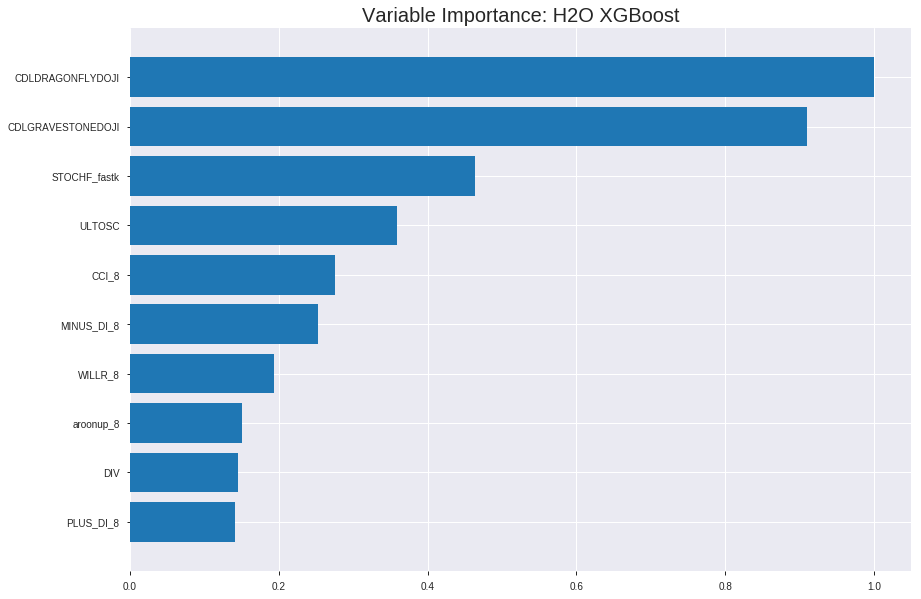

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_161413_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14867501771165353
RMSE: 0.3855839956632712
LogLoss: 0.4661366249393772
Mean Per-Class Error: 0.18400419434114312
AUC: 0.8930361674332935
pr_auc: 0.8903136681198098
Gini: 0.786072334866587
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.462299108505249: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      670  216  0.2438   (216.0/886.0)
1      121  781  0.1341   (121.0/902.0)
Total  791  997  0.1885   (337.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462299     0.822538  220
max f2                       0.346264     0.885819  279
max f0point5                 0.570318     0.832     163
max accuracy                 0.495604     0.815996  200
max precision                0.933891     1         0
max recall                   0.127234     1         376
max specificity              0.933891     1         0
max absolute_mcc             0.495604     0.631976  200
max min_per_class_accuracy   0.495604     0.815965  200
max mean_per_class_accuracy  0.495604     0.815996  200

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.39 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.91336            1.98226    1.98226            1                0.922908  1                           0.922908            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.896589           1.98226    1.98226            1                0.905185  1                           0.914047            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.889187           1.98226    1.98226            1                0.892713  1                           0.906935            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.877023           1.98226    1.98226            1                0.883649  1                           0.901114            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.863781           1.98226    1.98226            1                0.870747  1                           0.89504             0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.828136           1.91544    1.94904            0.966292         0.846592  0.98324                     0.870952            0.0953437       0.195122                   91.5444   94.9039
    7        0.150447                    0.783391           1.80606    1.9012             0.911111         0.807753  0.959108                    0.849807            0.0909091       0.286031                   80.6061   90.1203
    8        0.200224                    0.738257           1.82635    1.88259            0.921348         0.757812  0.949721                    0.826937            0.0909091       0.37694                    82.6353   88.2595
    9        0.300336                    0.638424           1.65004    1.80508            0.832402         0.684778  0.910615                    0.77955             0.165188        0.542129                   65.0039   80.5076
    10       0.399888                    0.567101           1.51454    1.73275            0.764045         0.602818  0.874126                    0.735553            0.150776        0.692905                   51.4537   73.2746
    11       0.5                         0.495926           1.18493    1.62306            0.597765         0.530894  0.818792                    0.694575            0.118625        0.81153                    18.4927   62.306
    12       0.600112                    0.434522           0.808408   1.48716            0.407821         0.465631  0.750233                    0.656382            0.0809313       0.892461                   -19.1592  48.7158
    13       0.699664                    0.371853           0.545679   1.3532             0.275281         0.403927  0.682654                    0.620461            0.0543237       0.946785                   -45.4321  35.3199
    14       0.799776                    0.28836            0.354371   1.22817            0.178771         0.332027  0.61958                     0.584357            0.0354767       0.982262                   -64.5629  22.817
    15       0.899888                    0.177185           0.143963   1.10755            0.0726257        0.23905   0.558732                    0.545942            0.0144124       0.996674                   -85.6037  10.7553
    16       1                           0.0671404          0.0332223  1                  0.0167598        0.125922  0.504474                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16472118224292925
RMSE: 0.4058585741892479
LogLoss: 0.5002130921830888
Mean Per-Class Error: 0.24898112398112393
AUC: 0.845391309677024
pr_auc: 0.8398803012138211
Gini: 0.690782619354048
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42361295223236084: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      161  98   0.3784   (98.0/259.0)
1      33   219  0.131    (33.0/252.0)
Total  194  317  0.2564   (131.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423613     0.769772  245
max f2                       0.272178     0.877754  310
max f0point5                 0.613045     0.78125   130
max accuracy                 0.535341     0.751468  180
max precision                0.939857     1         0
max recall                   0.152043     1         365
max specificity              0.939857     1         0
max absolute_mcc             0.613045     0.510641  130
max min_per_class_accuracy   0.507158     0.738095  198
max mean_per_class_accuracy  0.519081     0.751019  187

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 49.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.912681           2.02778    2.02778            1                0.925565  1                           0.925565            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.901168           1.62222    1.84343            0.8              0.905131  0.909091                    0.916277            0.015873        0.0396825                  62.2222   84.3434
    3        0.0313112                   0.887756           2.02778    1.90104            1                0.894743  0.9375                      0.909547            0.0198413       0.0595238                  102.778   90.1042
    4        0.0410959                   0.880585           2.02778    1.93122            1                0.883519  0.952381                    0.90335             0.0198413       0.0793651                  102.778   93.1217
    5        0.0508806                   0.865776           2.02778    1.94979            1                0.872635  0.961538                    0.897443            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.811673           1.87179    1.91079            0.923077         0.841729  0.942308                    0.869586            0.0952381       0.194444                   87.1795   91.0791
    7        0.150685                    0.760062           2.02778    1.94877            1                0.783955  0.961039                    0.841784            0.0992063       0.293651                   102.778   94.8773
    8        0.201566                    0.7105             1.7938     1.90965            0.884615         0.731742  0.941748                    0.814006            0.0912698       0.384921                   79.3803   90.9655
    9        0.30137                     0.629778           1.47113    1.76443            0.72549          0.668611  0.87013                     0.765856            0.146825        0.531746                   47.1133   76.443
    10       0.401174                    0.560014           1.19281    1.62222            0.588235         0.585895  0.8                         0.721085            0.119048        0.650794                   19.281    62.2222
    11       0.500978                    0.502491           0.914488   1.48123            0.45098          0.530383  0.730469                    0.683094            0.0912698       0.742063                   -8.5512   48.1228
    12       0.600783                    0.447235           1.03377    1.40689            0.509804         0.472628  0.693811                    0.64813             0.103175        0.845238                   3.37691   40.6895
    13       0.700587                    0.36543            0.675926   1.30276            0.333333         0.404996  0.642458                    0.613494            0.0674603       0.912698                   -32.4074  30.2762
    14       0.800391                    0.244676           0.675926   1.2246             0.333333         0.309897  0.603912                    0.575637            0.0674603       0.980159                   -32.4074  22.4599
    15       0.900196                    0.156999           0.119281   1.10205            0.0588235        0.195814  0.543478                    0.533526            0.0119048       0.992063                   -88.0719  10.2053
    16       1                           0.0716971          0.0795207  1                  0.0392157        0.124716  0.493151                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:14:51  17.382 sec  0                  0.5              0.693147            0.5             0                  1                0.495526                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-08-22 16:14:52  18.099 sec  5                  0.476245         0.646374            0.816176        0.611814           1.80461          0.314318                         0.472919           0.639926              0.803357          0.572889             1.93273            0.305284
    2019-08-22 16:14:52  18.407 sec  10                 0.459883         0.614173            0.821893        0.789688           1.98226          0.295861                         0.453456           0.601708              0.82113           0.792022             2.02778            0.273973
    2019-08-22 16:14:53  18.728 sec  15                 0.448779         0.591874            0.830675        0.817773           1.98226          0.272931                         0.441738           0.577889              0.829227          0.820085             2.02778            0.287671
    2019-08-22 16:14:53  19.024 sec  20                 0.439801         0.573421            0.835818        0.822247           1.98226          0.261745                         0.432319           0.558204              0.838458          0.826777             2.02778            0.273973
    2019-08-22 16:14:53  19.325 sec  25                 0.432444         0.558371            0.842549        0.832803           1.98226          0.267338                         0.426023           0.544795              0.839186          0.823496             2.02778            0.277886
    2019-08-22 16:14:54  19.687 sec  30                 0.425288         0.544171            0.850522        0.843011           1.98226          0.228747                         0.420815           0.534025              0.841898          0.830109             2.02778            0.270059
    2019-08-22 16:14:54  20.008 sec  35                 0.420202         0.533781            0.854304        0.847959           1.98226          0.239374                         0.417837           0.527358              0.840933          0.834775             2.02778            0.27593
    2019-08-22 16:14:54  20.364 sec  40                 0.415258         0.523689            0.857599        0.852617           1.98226          0.231544                         0.415078           0.521381              0.841944          0.835118             2.02778            0.273973
    2019-08-22 16:14:55  20.707 sec  45                 0.411302         0.515706            0.860688        0.858322           1.98226          0.217002                         0.412135           0.515499              0.845054          0.838906             2.02778            0.25636
    2019-08-22 16:14:55  21.041 sec  50                 0.407323         0.507706            0.863661        0.860574           1.98226          0.21868                          0.410071           0.510985              0.845782          0.839846             2.02778            0.252446
    2019-08-22 16:14:55  21.382 sec  55                 0.404201         0.501626            0.867725        0.865455           1.98226          0.214206                         0.408685           0.507894              0.846793          0.8

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
CDLDRAGONFLYDOJI         939.861083984375       1.0                    0.12983700427167782
CDLGRAVESTONEDOJI        855.6212768554688      0.9103699381063992     0.11819970554272763
STOCHF_fastk             436.2828369140625      0.4641992783279402     0.06027024368317454
ULTOSC                   337.4612731933594      0.3590544165981976     0.04661854982162497
CCI_8                    258.2918701171875      0.27481919883543293    0.03568170149313518
---                      ---                    ---                    ---
BBANDS_lowerband_12_6_3  5.628118515014648      0.005988245083151262   0.000777495802440964
day                      5.377324104309082      0.005721403083860933   0.0007428498366392425
TRIX_12                  5.2330403327941895     0.005567887022845589   0.0007229177711694222
BBANDS_lowerband_8_0_5   4.637478828430176      0.0049342173087648265  0.0006406439937954855
BBANDS_lowerband_8_5_5   2.5134706497192383     0.0026743001625983104  0.0003472231216350255


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78515625)

('F1', 0.7898550724637682)

('auc', 0.8485848768262119)

('logloss', 0.5138247093362746)

('mean_per_class_error', 0.21379668683904884)

('rmse', 0.412373394462304)

('mse', 0.17005181646036294)

xgboost prediction progress: |████████████████████████████████████████████| 100%


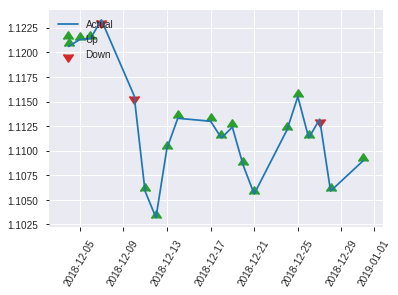


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17005181646036294
RMSE: 0.412373394462304
LogLoss: 0.5138247093362746
Mean Per-Class Error: 0.21379668683904884
AUC: 0.8485848768262119
pr_auc: 0.8482613979764388
Gini: 0.6971697536524237
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5724664330482483: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      89   34   0.2764   (34.0/123.0)
1      24   109  0.1805   (24.0/133.0)
Total  113  143  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.572466     0.789855  142
max f2                       0.235476     0.874172  222
max f0point5                 0.631787     0.80402   115
max accuracy                 0.616162     0.785156  123
max precision                0.932844     1         0
max recall                   0.149721     1         245
max specificity              0.932844     1         0
max absolute_mcc             0.616162     0.572249  123
max min_per_class_accuracy   0.604899     0.780488  130
max mean_per_class_accuracy  0.616162     0.786203  123

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 56.73 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.914108           1.92481    1.92481            1                0.92277   1                           0.92277             0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.904199           1.92481    1.92481            1                0.908975  1                           0.915872            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.892348           1.92481    1.92481            1                0.896975  1                           0.911148            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.884741           1.92481    1.92481            1                0.888994  1                           0.905106            0.0225564       0.0827068                  92.4812   92.4812
    5        0.0507812                   0.878125           1.92481    1.92481            1                0.883956  1                           0.901852            0.0150376       0.0977444                  92.4812   92.4812
    6        0.101562                    0.831717           1.62869    1.77675            0.846154         0.854443  0.923077                    0.878148            0.0827068       0.180451                   62.8687   77.675
    7        0.152344                    0.793231           1.92481    1.8261             1                0.813481  0.948718                    0.856592            0.0977444       0.278195                   92.4812   82.6104
    8        0.203125                    0.774865           1.48062    1.73973            0.769231         0.782701  0.903846                    0.838119            0.075188        0.353383                   48.0625   73.9734
    9        0.300781                    0.713559           1.61684    1.69983            0.84             0.748361  0.883117                    0.808977            0.157895        0.511278                   61.6842   69.9834
    10       0.402344                    0.649232           1.33256    1.60712            0.692308         0.68132   0.834951                    0.776753            0.135338        0.646617                   33.2562   60.7125
    11       0.5                         0.609181           1.23188    1.53383            0.64             0.630011  0.796875                    0.748092            0.120301        0.766917                   23.188    53.3835
    12       0.601562                    0.556669           0.740312   1.39986            0.384615         0.578675  0.727273                    0.719489            0.075188        0.842105                   -25.9688  39.9863
    13       0.699219                    0.480378           0.692932   1.30113            0.36             0.517869  0.675978                    0.69133             0.0676692       0.909774                   -30.7068  30.113
    14       0.800781                    0.34034            0.518219   1.20183            0.269231         0.418945  0.62439                     0.656784            0.0526316       0.962406                   -48.1781  20.1834
    15       0.898438                    0.19657            0.30797    1.10467            0.16             0.264214  0.573913                    0.614113            0.0300752       0.992481                   -69.203   10.4675
    16       1                           0.107129           0.0740312  1                  0.0384615        0.153391  0.519531                    0

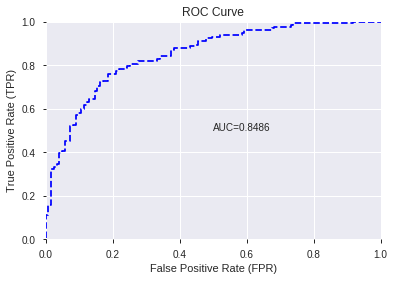

This function is available for GLM models only


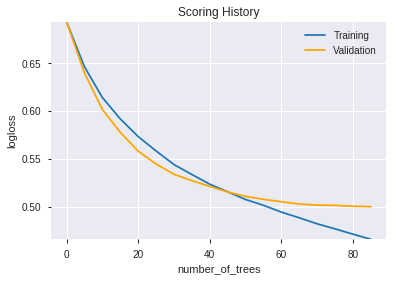

--2019-08-22 16:15:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

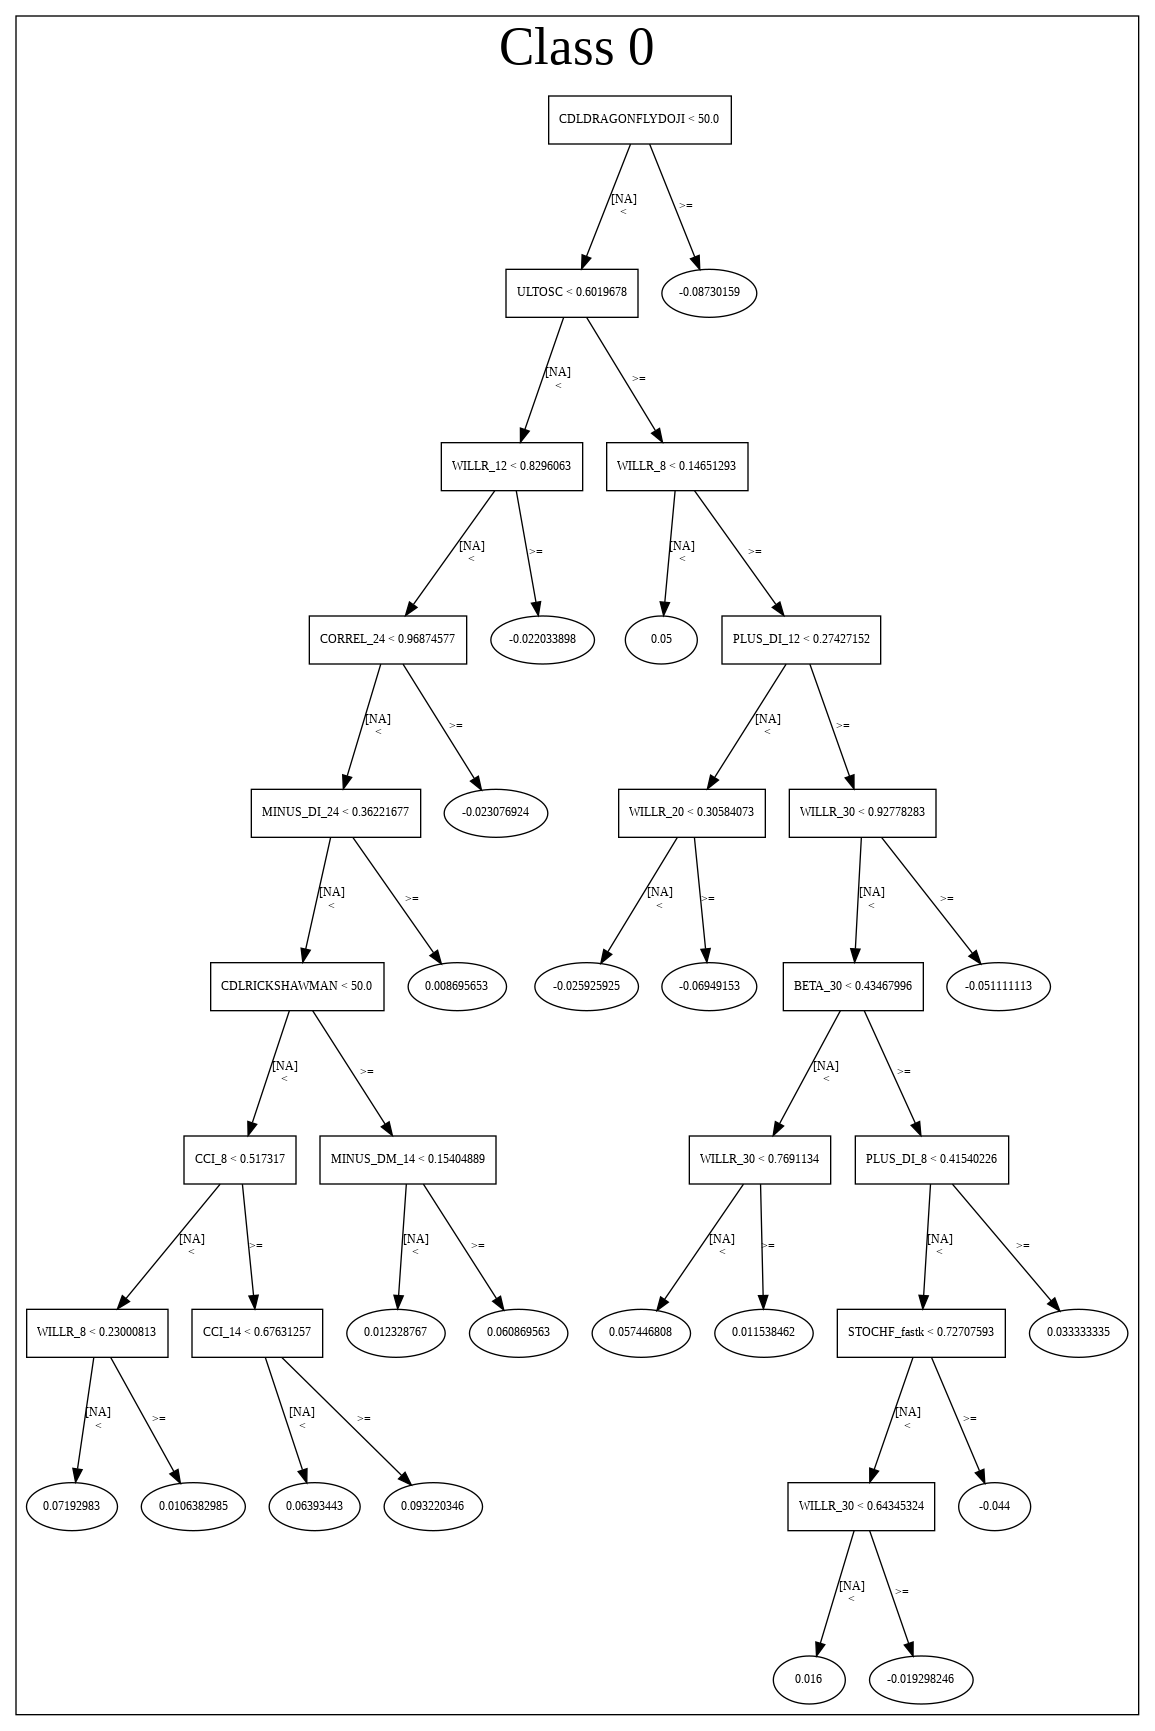

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_161413_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_161413_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_161530_model_8  0.853720  0.474720              0.226206  0.395272  0.156240
1  DeepLearning_grid_1_AutoML_20190822_161530_model_6  0.850541  0.487680              0.240235  0.398973  0.159180
2  DeepLearning_grid_1_AutoML_20190822_161530_model_9  0.848585  0.476827              0.240846  0.397015  0.157621
3               DeepLearning_1_AutoML_20190822_161530  0.844061  0.506905              0.269913  0.405817  0.164687
4  DeepLearning_grid_1_AutoML_20190822_161530_model_5  0.836298  0.493254              0.287395  0.402863  0.162298
5  DeepLearning_grid_1_AutoML_20190822_161530_model_7  0.832019  0.525396              0.248059  0.407442  0.166009
6  DeepLearning_grid_1_AutoML_20190822_161530_model_3  0.803533  0.614167              0.294608  0.439990  0.193591
7  DeepLearning_grid_1_AutoML_20190822_161530_model_4  0.801577  0.669956              0.310563  0.456509  0.208400
8  DeepLearning_grid_1_AutoML_20190822_161530_model_2  0.796442  0.588167              0.285867  0.436703  0.190709
9  DeepLearning_grid_1_AutoML_20190822_161530_model_1  0.779754  0.689554              0.279968  0.459863  0.211474

variable  relative_importance  scaled_importance  percentage
0       CDLRICKSHAWMAN             1.000000           1.000000    0.043515
1    CDLLONGLEGGEDDOJI             0.766015           0.766015    0.033333
2         STOCHF_fastk             0.761928           0.761928    0.033155
3               TRANGE             0.713007           0.713007    0.031026
4              CDLDOJI             0.699005           0.699005    0.030417
5           MINUS_DI_8             0.594932           0.594932    0.025888
6               ULTOSC             0.571181           0.571181    0.024855
7                CCI_8             0.534266           0.534266    0.023249
8     CDLDRAGONFLYDOJI             0.534078           0.534078    0.023240
9            CDLTAKURI             0.515239           0.515239    0.022421
10   CDLGRAVESTONEDOJI             0.513371           0.513371    0.022339
11          PLUS_DI_30             0.510321           0.510321    0.022207
12             BETA_30             0.502276           0.502276    0.021857
13         MINUS_DI_30             0.493856           0.493856    0.021490
14           CORREL_24             0.485596           0.485596    0.021131
15            WILLR_12             0.471235           0.471235    0.020506
16  CDLCLOSINGMARUBOZU             0.470381           0.470381    0.020469
17   CDLINVERTEDHAMMER             0.469646           0.469646    0.020437
18         CDLBELTHOLD             0.458059           0.458059    0.019932
19           CDLHAMMER             0.440174           0.440174    0.019154
20              SAREXT             0.439693           0.439693    0.019133
21           PLUS_DI_8             0.428429           0.428429    0.018643
22         MINUS_DI_24             0.422784           0.422784    0.018397
23         MINUS_DI_12             0.422466           0.422466    0.018384
24            WILLR_30             0.408269           0.408269    0.017766
25           CORREL_30             0.408188           0.408188    0.017762
26            WILLR_20             0.401577           0.401577    0.017475
27         STOCH_slowk             0.401249           0.401249    0.017460
28              CCI_20             0.400020           0.400020    0.017407
29        STOCHF_fastd             0.399949           0.399949    0.017404
30             WILLR_8             0.398860           0.398860    0.017356
31          aroonup_14             0.398706           0.398706    0.017350
32            WILLR_24             0.394371           0.394371    0.017161
33              CCI_14             0.394120           0.394120    0.017150
34              CCI_24             0.387559           0.387559    0.016865
35              CCI_12             0.382865           0.382865    0.016660
36              ROCP_8             0.379359           0.379359    0.016508
37               ROC_8             0.377975           0.377975    0.016448
38         MINUS_DI_20             0.375900           0.375900    0.016357
39           ROCR100_8             0.374505           0.374505    0.016297
40         MINUS_DI_14             0.370648           0.370648    0.016129
41           PLUS_DM_8             0.369429           0.369429    0.016076
42          MINUS_DM_8             0.360806           0.360806    0.015700
43     CDLSHOOTINGSTAR             0.356431           0.356431    0.015510
44          PLUS_DI_12             0.352421           0.352421    0.015336
45       CDLHANGINGMAN             0.352027           0.352027    0.015318
46          PLUS_DM_12             0.344021           0.344021    0.014970
47          PLUS_DI_14             0.333309           0.333309    0.014504
48         MINUS_DM_14             0.326535           0.326535    0.014209
49         MINUS_DM_12             0.313580           0.313580    0.013645

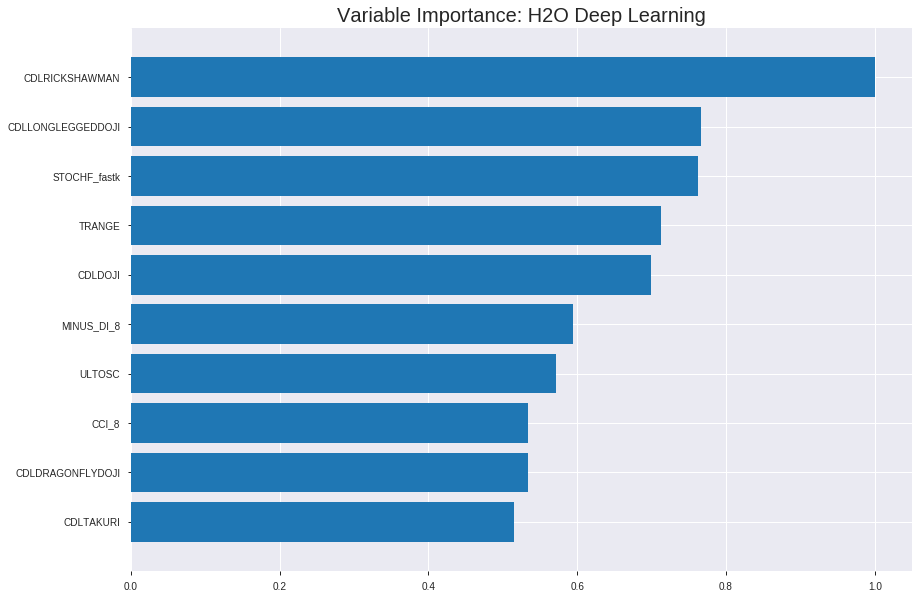

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_161530_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16686355415680135
RMSE: 0.40848935623440835
LogLoss: 0.48642000006832015
Mean Per-Class Error: 0.2789762404088232
AUC: 0.8268251390188847
pr_auc: 0.8339592734525324
Gini: 0.6536502780377693
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4298979430909462: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      450  436   0.4921   (436.0/886.0)
1      76   826   0.0843   (76.0/902.0)
Total  526  1262  0.2864   (512.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429898     0.763401  236
max f2                       0.154489     0.87579   326
max f0point5                 0.522591     0.752768  172
max accuracy                 0.452855     0.722036  223
max precision                0.996542     1         0
max recall                   0.00562558   1         392
max specificity              0.996542     1         0
max absolute_mcc             0.452855     0.468803  223
max min_per_class_accuracy   0.486098     0.674944  192
max mean_per_class_accuracy  0.485458     0.721024  193

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 46.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.995128           1.98226    1.98226            1                0.996163   1                           0.996163            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.992137           1.98226    1.98226            1                0.993621   1                           0.994892            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.989303           1.98226    1.98226            1                0.990908   1                           0.993564            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.983595           1.98226    1.98226            1                0.986686   1                           0.991844            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.978658           1.98226    1.98226            1                0.980858   1                           0.989647            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.92733            1.98226    1.98226            1                0.954828   1                           0.972335            0.0986696       0.198448                   98.2262   98.2262
    7        0.150447                    0.819845           1.89416    1.95279            0.955556         0.879132   0.98513                     0.941152            0.0953437       0.293792                   89.4161   95.2786
    8        0.200224                    0.660965           1.64817    1.87706            0.831461         0.751868   0.946927                    0.894095            0.0820399       0.375831                   64.8173   87.7058
    9        0.300336                    0.486383           1.31782    1.69064            0.664804         0.543936   0.852886                    0.777375            0.131929        0.507761                   31.7816   69.0644
    10       0.544183                    0.486099           1.03205    1.39553            0.520642         0.486101   0.704008                    0.646856            0.251663        0.759424                   3.20491   39.5528
    11       0.600112                    0.478466           1.01095    1.35969            0.51             0.482635   0.685927                    0.631551            0.056541        0.815965                   1.09534   35.9687
    12       0.699664                    0.434072           0.935449   1.29932            0.47191          0.459357   0.655476                    0.60705             0.0931264       0.909091                   -6.45507  29.9324
    13       0.799776                    0.203572           0.675519   1.22124            0.340782         0.358257   0.616084                    0.575907            0.0676275       0.976718                   -32.4481  22.124
    14       0.899888                    0.0172773          0.210408   1.10879            0.106145         0.0848029  0.559354                    0.521272            0.0210643       0.997783                   -78.9592  10.8785
    15       1                           9.24059e-05        0.0221482  1                  0.0111732        0.0056857  0.504474                    0.469656            0.00221729      1                          -97.7852  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.15803509358333018
RMSE: 0.39753627958128573
LogLoss: 0.47386281595549307
Mean Per-Class Error: 0.23208923208923204
AUC: 0.8529677636820494
pr_auc: 0.8502130258642094
Gini: 0.7059355273640988
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43131668063509027: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  101  0.39     (101.0/259.0)
1      26   226  0.1032   (26.0/252.0)
Total  184  327  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431317     0.780656  248
max f2                       0.18446      0.87833   301
max f0point5                 0.486384     0.767276  169
max accuracy                 0.458253     0.767123  211
max precision                0.997673     1         0
max recall                   0.00359395   1         384
max specificity              0.997673     1         0
max absolute_mcc             0.458253     0.538902  211
max min_per_class_accuracy   0.480988     0.746032  185
max mean_per_class_accuracy  0.458253     0.767911  211

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 45.81 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.996518           2.02778    2.02778            1                0.996961    1                           0.996961            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.995009           2.02778    2.02778            1                0.9958      1                           0.996433            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.993157           2.02778    2.02778            1                0.993864    1                           0.99563             0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.990218           2.02778    2.02778            1                0.991571    1                           0.994664            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.988745           2.02778    2.02778            1                0.989711    1                           0.993711            0.0198413       0.103175                   102.778   102.778
    6        0.101761                    0.945965           2.02778    2.02778            1                0.973159    1                           0.983435            0.103175        0.206349                   102.778   102.778
    7        0.150685                    0.874616           1.78444    1.94877            0.88             0.915239    0.961039                    0.961293            0.0873016       0.293651                   78.4444   94.8773
    8        0.201566                    0.789992           1.63782    1.87028            0.807692         0.836673    0.92233                     0.929836            0.0833333       0.376984                   63.7821   87.028
    9        0.30137                     0.52527            1.43137    1.72493            0.705882         0.666959    0.850649                    0.842779            0.142857        0.519841                   43.1373   72.4928
    10       0.455969                    0.486099           1.23207    1.55782            0.607595         0.490672    0.76824                     0.723395            0.190476        0.710317                   23.2068   55.7821
    11       0.500978                    0.479355           0.969807   1.50499            0.478261         0.482659    0.742188                    0.701766            0.0436508       0.753968                   -3.01932  50.4991
    12       0.600783                    0.444881           1.07353    1.43332            0.529412         0.461447    0.70684                     0.661844            0.107143        0.861111                   7.35294   43.3315
    13       0.700587                    0.337528           0.715686   1.33108            0.352941         0.408691    0.656425                    0.62578             0.0714286       0.93254                    -28.4314  33.1083
    14       0.800391                    0.0583373          0.357843   1.20973            0.176471         0.171901    0.596577                    0.569184            0.0357143       0.968254                   -64.2157  20.9726
    15       0.900196                    0.00713686         0.278322   1.10646            0.137255         0.0226894   0.545652                    0.508594            0.0277778       0.996032                   -72.1678  10.6461
    16       1                           0.000289017        0.0397603  1                  0.0196078        0.00


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:22:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:22:22  1 min 34.234 sec  635 obs/sec       0.711969  1             1273       0.534446         0.969992            -0.142623      0.700205        0.687823           1.98226          0.409955                         0.473037           0.714151              0.104776         0.757362          0.725573             1.68981            0.336595
    2019-08-22 16:22:36  1 min 47.607 sec  991 obs/sec       7.80481   11            13955      0.422803         0.524562            0.284893       0.814883        0.826955           1.98226          0.302573                         0.406995           0.488237              0.337297         0.836015          0.831804             2.02778            0.273973
    2019-08-22 16:22:50  2 min  1.549 sec  1097 obs/sec      16.3831   23            29293      0.415118         0.499431            0.310653       0.82171         0.833565           1.98226          0.295861                         0.401869           0.474518              0.353883         0.849858          0.847023             2.02778            0.266145
    2019-08-22 16:23:03  2 min 15.249 sec  1141 obs/sec      24.9457   35            44603      0.421756         0.51061             0.288429       0.829519        0.83175            1.98226          0.285794                         0.414003           0.501643              0.314277         0.850455          0.850069             2.02778            0.268102
    2019-08-22 16:23:17  2 min 28.807 sec  1169 obs/sec      33.5095   47            59915      0.408489         0.48642             0.332492       0.826825        0.833959           1.98226          0.286353                         0.397536           0.473863              0.367741         0.852968          0.850213             2.02778            0.248532
    2019-08-22 16:23:31  2 min 43.729 sec  1165 obs/sec      42.1147   59            75301      0.398851         0.462266            0.363622       0.84408         0.834429           1.98226          0.272931                         0.400212           0.483152              0.359201         0.849888          0.843225             2.02778            0.250489
    2019-08-22 16:23:47  2 min 59.402 sec  1166 obs/sec      51.4374   72            91970      0.394639         0.452946            0.376991       0.846427        0.845329           1.98226          0.275727                         0.398977           0.48272               0.363149         0.851068          0.836695             2.02778            0.262231
    2019-08-22 16:23:49  3 min  0.963 sec  1166 obs/sec      51.4374   72            91970      0.408489         0.48642             0.332492       0.826825        0.833959           1.98226          0.286353                         0.397536           0.473863              0.367741         0.852968          0.850213             2.02778            0.248532

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN     1.0                    1.0                  0.043514926705740246
CDLLONGLEGGEDDOJI  0.7660149335861206     0.7660149335861206   0.033333083690502516
STOCHF_fastk       0.7619284987449646     0.7619284987449646   0.03315526277790183
TRANGE             0.7130071520805359     0.7130071520805359   0.031026453963453108
CDLDOJI            0.6990046501159668     0.6990046501159668   0.0304171361167679
---                ---                    ---                  ---
CDLHANGINGMAN      0.352027028799057      0.352027028799057    0.015318430356630476
PLUS_DM_12         0.3440205156803131     0.3440205156803131   0.014970027525099787
PLUS_DI_14         0.3333088159561157     0.3333088159561157   0.01450390869670744
MINUS_DM_14        0.3265348970890045     0.3265348970890045   0.014209142113694465
MINUS_DM_12        0.31358036398887634    0.31358036398887634  0.0136454265553353


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.77734375)

('F1', 0.8013937282229966)

('auc', 0.8537196650161991)

('logloss', 0.47472034673320046)

('mean_per_class_error', 0.22620575829818446)

('rmse', 0.3952715942809214)

('mse', 0.15623963324538134)

deeplearning prediction progress: |███████████████████████████████████████| 100%


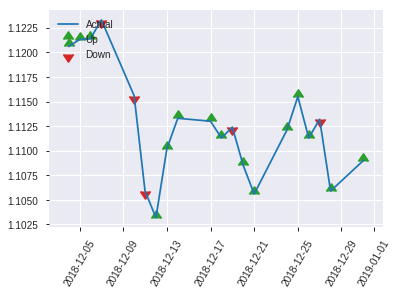


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.15623963324538134
RMSE: 0.3952715942809214
LogLoss: 0.47472034673320046
Mean Per-Class Error: 0.22620575829818446
AUC: 0.8537196650161991
pr_auc: 0.8617820542397733
Gini: 0.7074393300323982
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4794944880660621: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   39   0.3171   (39.0/123.0)
1      18   115  0.1353   (18.0/133.0)
Total  102  154  0.2227   (57.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479494     0.801394  113
max f2                       0.31039      0.896033  158
max f0point5                 0.496801     0.807128  85
max accuracy                 0.479494     0.777344  113
max precision                0.996714     1         0
max recall                   0.00548439   1         199
max specificity              0.996714     1         0
max absolute_mcc             0.479494     0.55882   113
max min_per_class_accuracy   0.486099     0.699187  98
max mean_per_class_accuracy  0.479494     0.773794  113

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 48.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.995768           1.92481   1.92481            1                0.996373    1                           0.996373            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.994586           1.92481   1.92481            1                0.99524     1                           0.995806            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.992397           1.92481   1.92481            1                0.993143    1                           0.995141            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.990183           1.92481   1.92481            1                0.99119     1                           0.994063            0.0225564       0.0827068                  92.4812   92.4812
    5        0.0507812                   0.986446           1.92481   1.92481            1                0.989424    1                           0.993349            0.0150376       0.0977444                  92.4812   92.4812
    6        0.101562                    0.961783           1.77675   1.85078            0.923077         0.974233    0.961538                    0.983791            0.0902256       0.18797                    77.675    85.0781
    7        0.152344                    0.893195           1.92481   1.87546            1                0.921776    0.974359                    0.963119            0.0977444       0.285714                   92.4812   87.5458
    8        0.203125                    0.762423           1.92481   1.8878             1                0.833824    0.980769                    0.930796            0.0977444       0.383459                   92.4812   88.7796
    9        0.300781                    0.509967           1.30887   1.69983            0.68             0.647505    0.883117                    0.838818            0.12782         0.511278                   30.8872   69.9834
    10       0.542969                    0.486099           1.05554   1.41245            0.548387         0.489229    0.733813                    0.682886            0.255639        0.766917                   5.55421   41.2452
    11       0.601562                    0.479494           1.66817   1.43736            0.866667         0.482699    0.746753                    0.663388            0.0977444       0.864662                   66.817    43.736
    12       0.699219                    0.43749            0.692932  1.33339            0.36             0.461156    0.692737                    0.635143            0.0676692       0.932331                   -30.7068  33.3389
    13       0.800781                    0.12086            0.518219  1.23               0.269231         0.346486    0.639024                    0.598533            0.0526316       0.984962                   -48.1781  23.0002
    14       0.898438                    0.0134942          0         1.09631            0                0.0590739   0.569565                    0.539896            0               0.984962                   -100      9.6306
    15       1                           0.00112829         0.148062  1                  0.0769231        0.00498984  0.519531                    0.48557             0.0150376       1                          -85.1938  0

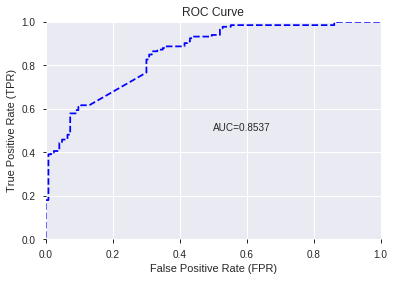

This function is available for GLM models only


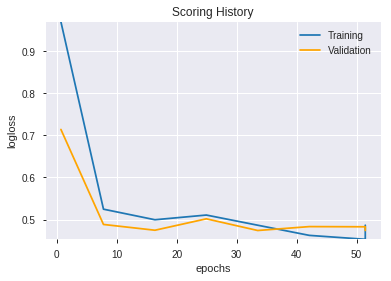

--2019-08-22 16:26:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.19.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.19.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


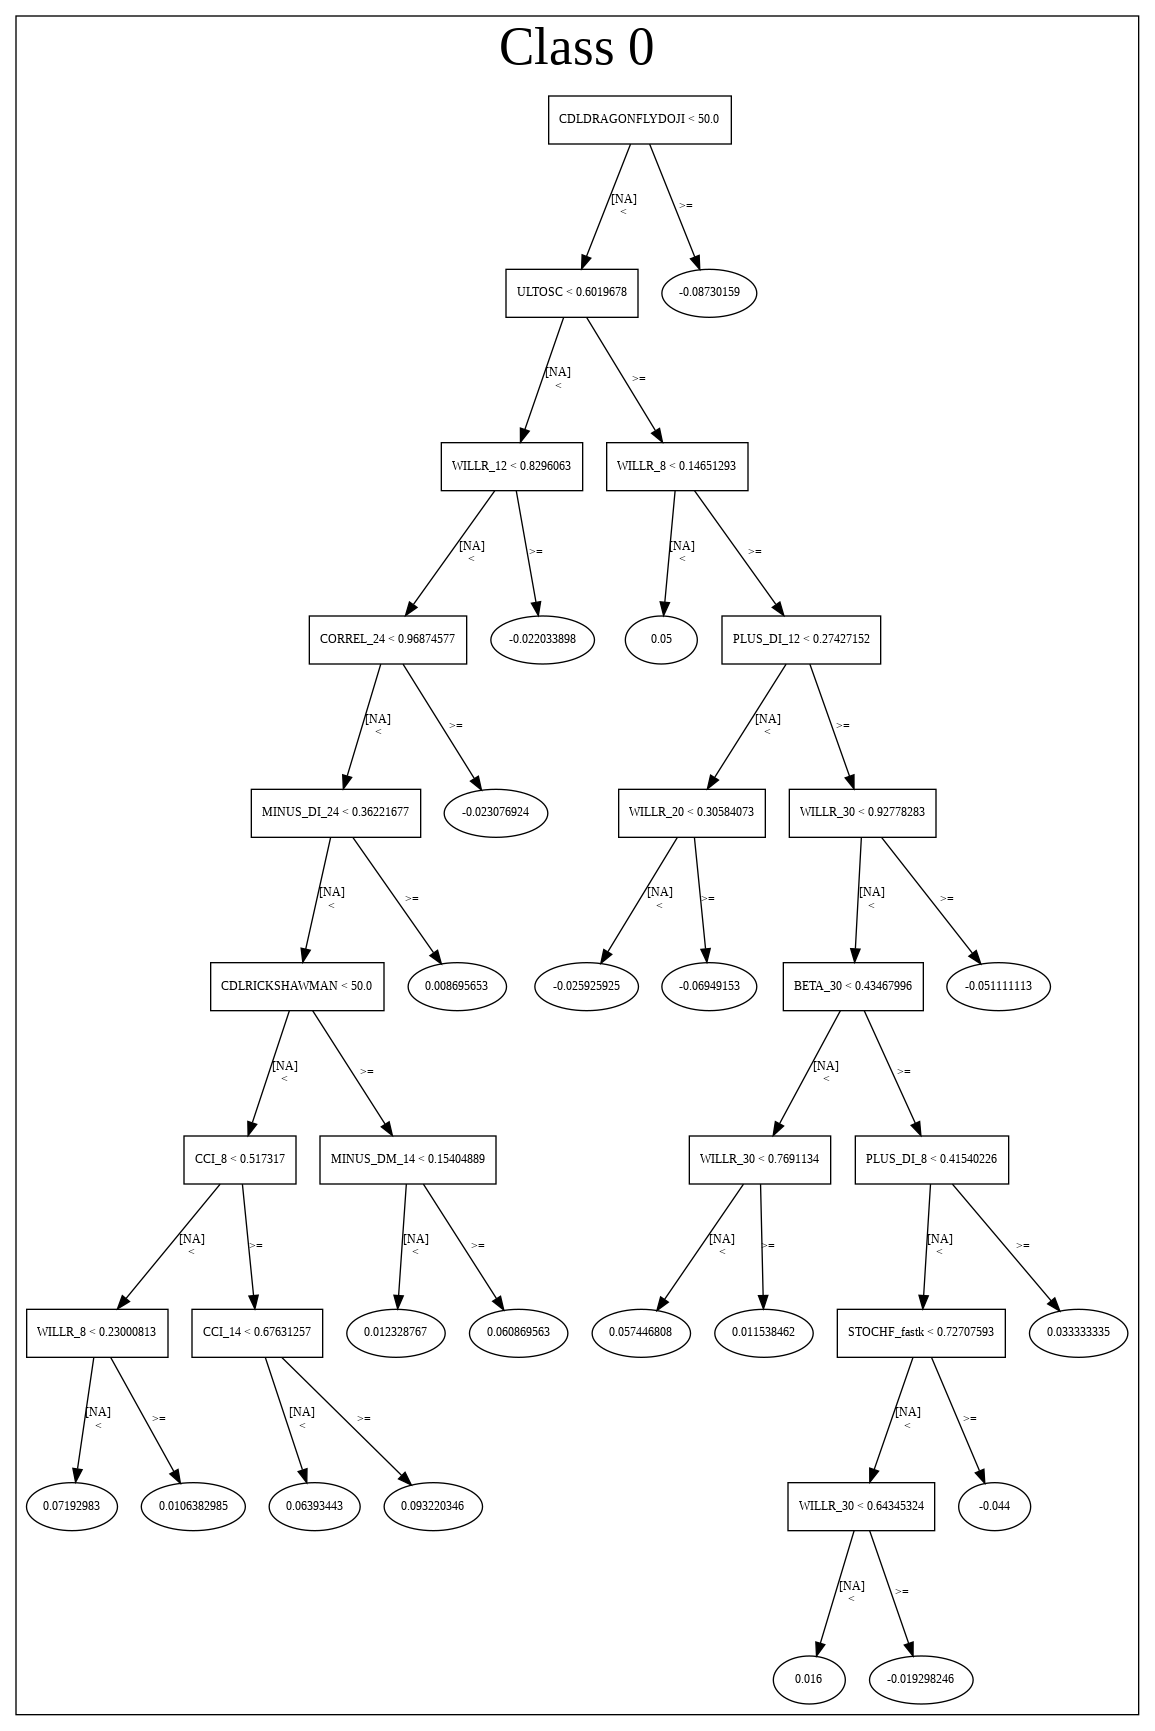

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_161530_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_161530_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'STOCHF_fastk',
 'TRANGE',
 'CDLDOJI',
 'MINUS_DI_8',
 'ULTOSC',
 'CCI_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'PLUS_DI_30',
 'BETA_30',
 'MINUS_DI_30',
 'CORREL_24',
 'WILLR_12',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'SAREXT',
 'PLUS_DI_8',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'WILLR_30',
 'CORREL_30',
 'WILLR_20',
 'STOCH_slowk',
 'CCI_20',
 'STOCHF_fastd',
 'WILLR_8',
 'aroonup_14',
 'WILLR_24',
 'CCI_14',
 'CCI_24',
 'CCI_12',
 'ROCP_8',
 'ROC_8',
 'MINUS_DI_20',
 'ROCR100_8',
 'MINUS_DI_14',
 'PLUS_DM_8',
 'MINUS_DM_8',
 'CDLSHOOTINGSTAR',
 'PLUS_DI_12',
 'CDLHANGINGMAN',
 'PLUS_DM_12',
 'PLUS_DI_14',
 'MINUS_DM_14',
 'MINUS_DM_12']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_162617_model_1  0.847851  0.485382              0.236781  0.400046  0.160037

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk             0.642609           1.000000    0.074897
1    CDLGRAVESTONEDOJI             0.636810           0.990976    0.074221
2           MINUS_DI_8             0.618328           0.962216    0.072067
3                CCI_8             0.561369           0.873578    0.065428
4     CDLDRAGONFLYDOJI             0.396229           0.616595    0.046181
5             WILLR_12             0.365305           0.568472    0.042577
6            CDLTAKURI             0.311339           0.484493    0.036287
7            PLUS_DI_8             0.305774           0.475833    0.035638
8             WILLR_30             0.301976           0.469922    0.035196
9            CORREL_24             0.276248           0.429885    0.032197
10          MINUS_DM_8             0.266799           0.415182    0.031096
11              CCI_14             0.226601           0.352627    0.026411
12              CCI_24             0.222024           0.345504    0.025877
13            WILLR_20             0.221897           0.345307    0.025862
14         MINUS_DI_12             0.210635           0.327781    0.024550
15               ROC_8             0.176211           0.274213    0.020538
16           ROCR100_8             0.175730           0.273464    0.020482
17              ROCP_8             0.175518           0.273134    0.020457
18         MINUS_DI_30             0.162437           0.252778    0.018932
19              CCI_20             0.148229           0.230668    0.017276
20         MINUS_DM_14             0.145230           0.226000    0.016927
21            WILLR_24             0.138034           0.214802    0.016088
22         MINUS_DI_24             0.138013           0.214770    0.016086
23   CDLINVERTEDHAMMER             0.127362           0.198195    0.014844
24           CORREL_30             0.125681           0.195580    0.014648
25              ULTOSC             0.124402           0.193589    0.014499
26  CDLCLOSINGMARUBOZU             0.113128           0.176044    0.013185
27           CDLHAMMER             0.110020           0.171209    0.012823
28          PLUS_DI_30             0.104089           0.161980    0.012132
29          PLUS_DM_12             0.094698           0.147365    0.011037
30           PLUS_DM_8             0.093817           0.145995    0.010935
31         MINUS_DI_14             0.093474           0.145461    0.010895
32     CDLSHOOTINGSTAR             0.089323           0.139001    0.010411
33              SAREXT             0.089016           0.138523    0.010375
34         MINUS_DI_20             0.084082           0.130845    0.009800
35          PLUS_DI_14             0.079385           0.123536    0.009252
36             BETA_30             0.060127           0.093566    0.007008
37         MINUS_DM_12             0.059436           0.092492    0.006927
38         CDLBELTHOLD             0.050130           0.078010    0.005843
39              TRANGE             0.041689           0.064875    0.004859
40          PLUS_DI_12             0.037989           0.059117    0.004428
41       CDLHANGINGMAN             0.034669           0.053951    0.004041
42         STOCH_slowk             0.028545           0.044421    0.003327
43        STOCHF_fastd             0.027425           0.042678    0.003196
44              CCI_12             0.026716           0.041574    0.003114
45             CDLDOJI             0.020254           0.031519    0.002361
46             WILLR_8             0.018387           0.028613    0.002143
47          aroonup_14             0.008948           0.013925    0.001043
48      CDLRICKSHAWMAN             0.007027           0.010934    0.000819
49   CDLLONGLEGGEDDOJI             0.006739           0.010487    0.000785

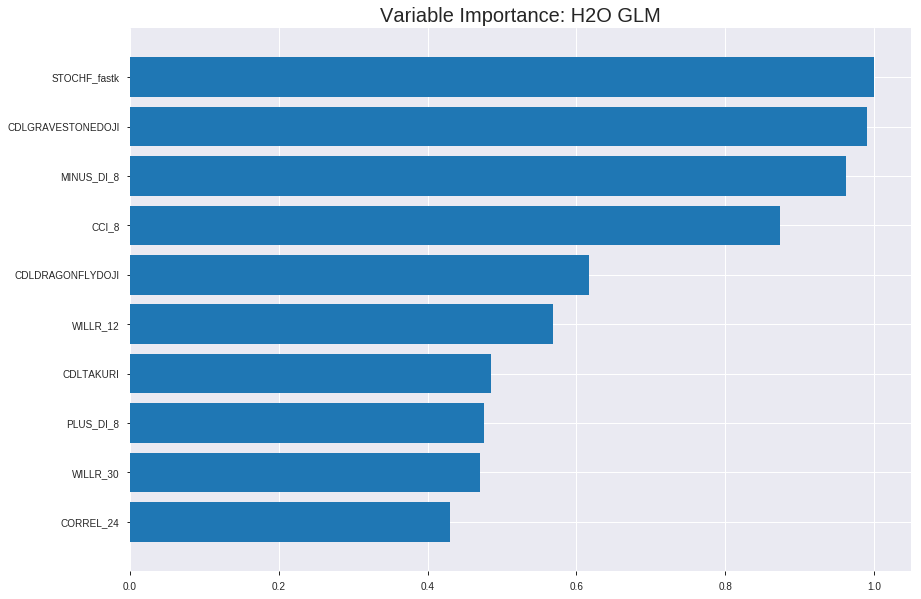

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_162617_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17592168907760072
RMSE: 0.41943019571509244
LogLoss: 0.5216039097112193
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2478.551139037676
Residual deviance: 1865.25558112732
AIC: 1967.25558112732
AUC: 0.8143991531234828
pr_auc: 0.8109186645886924
Gini: 0.6287983062469655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41254500332175986: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      512  374   0.4221   (374.0/886.0)
1      127  775   0.1408   (127.0/902.0)
Total  639  1149  0.2802   (501.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412545     0.755729  249
max f2                       0.242009     0.862171  319
max f0point5                 0.589402     0.743576  166
max accuracy                 0.464849     0.735459  225
max precision                0.993934     1         0
max recall                   0.0438952    1         380
max specificity              0.993934     1         0
max absolute_mcc             0.464849     0.474612  225
max min_per_class_accuracy   0.515163     0.727273  203
max mean_per_class_accuracy  0.464849     0.734832  225

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.972647           1.98226    1.98226            1                0.981232  1                           0.981232            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.965174           1.87214    1.9272             0.944444         0.969302  0.972222                    0.975267            0.018847        0.0388027                  87.2136   92.7199
    3        0.0302013                   0.952548           1.87214    1.90884            0.944444         0.959404  0.962963                    0.969979            0.018847        0.0576497                  87.2136   90.8845
    4        0.0402685                   0.941702           1.87214    1.89967            0.944444         0.947879  0.958333                    0.964454            0.018847        0.0764967                  87.2136   89.9667
    5        0.0503356                   0.932161           1.98226    1.91619            1                0.936312  0.966667                    0.958826            0.0199557       0.0964523                  98.2262   91.6186
    6        0.100112                    0.884126           1.80408    1.86045            0.910112         0.909978  0.938547                    0.934538            0.0898004       0.186253                   80.4081   86.0447
    7        0.150447                    0.811818           1.58581    1.76856            0.8              0.849369  0.892193                    0.906043            0.0798226       0.266075                   58.5809   76.8561
    8        0.200224                    0.744463           1.67045    1.74417            0.842697         0.774106  0.879888                    0.873243            0.0831486       0.349224                   67.0445   74.4169
    9        0.300336                    0.645155           1.41748    1.63527            0.715084         0.691218  0.824953                    0.812568            0.141907        0.491131                   41.7483   63.5274
    10       0.399888                    0.573423           1.2584     1.54145            0.634831         0.609321  0.777622                    0.761969            0.125277        0.616408                   25.8402   54.1451
    11       0.5                         0.514328           1.10741    1.45455            0.558659         0.542306  0.733781                    0.717988            0.110865        0.727273                   10.7409   45.4545
    12       0.600112                    0.442427           0.952372   1.37077            0.480447         0.480153  0.691519                    0.678312            0.0953437       0.822616                   -4.76285  37.0772
    13       0.699664                    0.367028           0.746132   1.28189            0.376404         0.40517   0.646683                    0.639447            0.0742794       0.896896                   -25.3868  28.1894
    14       0.799776                    0.274258           0.598001   1.19629            0.301676         0.325387  0.603497                    0.600135            0.059867        0.956763                   -40.1999  19.6288
    15       0.899888                    0.0993948          0.332223   1.10016            0.167598         0.198856  0.555003                    0.555493            0.0332594       0.990022                   -66.7777  10.0161
    16       1                           0.00210538         0.0996668  1                  0.0502793        0.045877  0.504474                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16755311183476096
RMSE: 0.4093325198842146
LogLoss: 0.5033640714633921
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.5626222346018
Residual deviance: 514.4380810355867
AIC: 616.4380810355867
AUC: 0.8310044738616167
pr_auc: 0.8107621386282188
Gini: 0.6620089477232334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41171102641699964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      160  99   0.3822   (99.0/259.0)
1      31   221  0.123    (31.0/252.0)
Total  191  320  0.2544   (130.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411711     0.772727  243
max f2                       0.121857     0.866388  333
max f0point5                 0.629891     0.760638  132
max accuracy                 0.482559     0.753425  208
max precision                0.995293     1         0
max recall                   0.0505818    1         366
max specificity              0.995293     1         0
max absolute_mcc             0.411711     0.511257  243
max min_per_class_accuracy   0.51606      0.741313  191
max mean_per_class_accuracy  0.478646     0.754129  211

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.987247           2.02778    2.02778            1                0.99128    1                           0.99128             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.980835           1.62222    1.84343            0.8              0.983264   0.909091                    0.987636            0.015873        0.0396825                  62.2222   84.3434
    3        0.0313112                   0.960935           1.62222    1.77431            0.8              0.973795   0.875                       0.983311            0.015873        0.0555556                  62.2222   77.4306
    4        0.0410959                   0.955321           2.02778    1.83466            1                0.957283   0.904762                    0.977114            0.0198413       0.0753968                  102.778   83.4656
    5        0.0508806                   0.946874           2.02778    1.87179            1                0.951713   0.923077                    0.972229            0.0198413       0.0952381                  102.778   87.1795
    6        0.101761                    0.891842           1.71581    1.7938             0.846154         0.925521   0.884615                    0.948875            0.0873016       0.18254                    71.5812   79.3803
    7        0.150685                    0.832527           1.94667    1.84343            0.96             0.862669   0.909091                    0.920886            0.0952381       0.277778                   94.6667   84.3434
    8        0.201566                    0.760811           1.7938     1.83091            0.884615         0.793291   0.902913                    0.888678            0.0912698       0.369048                   79.3803   83.0906
    9        0.30137                     0.650244           1.35185    1.67226            0.666667         0.69821    0.824675                    0.825601            0.134921        0.503968                   35.1852   67.2258
    10       0.401174                    0.588215           1.27233    1.57276            0.627451         0.617118   0.77561                     0.773734            0.126984        0.630952                   27.2331   57.2764
    11       0.500978                    0.512539           1.11329    1.48123            0.54902          0.549541   0.730469                    0.729071            0.111111        0.742063                   11.329    48.1228
    12       0.600783                    0.435564           1.07353    1.4135             0.529412         0.472055   0.697068                    0.686374            0.107143        0.849206                   7.35294   41.35
    13       0.700587                    0.351517           0.596405   1.2971             0.294118         0.3893     0.639665                    0.644054            0.0595238       0.90873                    -40.3595  29.7098
    14       0.800391                    0.209891           0.636166   1.21468            0.313725         0.287677   0.599022                    0.599615            0.0634921       0.972222                   -36.3834  21.4684
    15       0.900196                    0.0616729          0.198802   1.10205            0.0980392        0.12272    0.543478                    0.546742            0.0198413       0.992063                   -80.1198  10.2053
    16       1                           0.00421857         0.0795207  1                  0.0392157        0.0349458  0.493151   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:26:18  0.000 sec   2            .15E2     51            1.3669329129956895  1.3628816216450592
     2019-08-22 16:26:18  0.011 sec   4            .96E1     51            1.3564169093868013  1.350003176851457
     2019-08-22 16:26:18  0.024 sec   6            .6E1      51            1.341143342288849   1.331358511795656
     2019-08-22 16:26:18  0.035 sec   8            .37E1     51            1.3200714167335696  1.3057435355056033
     2019-08-22 16:26:18  0.047 sec   10           .23E1     51            1.2929242777219312  1.2729068137737543
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:26:18  0.214 sec   38           .29E-2    51            1.0413591541767937  1.007382495011199
     2019-08-22 16:26:18  0.239 sec   40           .18E-2    51            1.04009132678824    1.008445241910381
     2019-08-22 16:26:18  0.260 sec   42           .11E-2    51            1.039173733012607   1.0093057984391405
     2019-08-22 16:26:18  0.280 sec   44           .7E-3     51            1.0385208367165037  1.00996522839541
     2019-08-22 16:26:18  0.288 sec   45           .43E-3    51            1.038063444669602   1.0104099260487969


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.8065573770491803)

('auc', 0.8478513356562137)

('logloss', 0.48538236475444774)

('mean_per_class_error', 0.23179900971942047)

('rmse', 0.4000458060462478)

('mse', 0.1600366469351921)

glm prediction progress: |████████████████████████████████████████████████| 100%


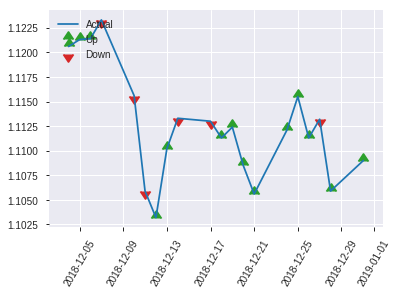


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1600366469351921
RMSE: 0.4000458060462478
LogLoss: 0.48538236475444774
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.73288115002356
Residual deviance: 248.5157707542772
AIC: 350.51577075427724
AUC: 0.8478513356562137
pr_auc: 0.8437695151732456
Gini: 0.6957026713124275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43759456966657256: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   49   0.3984   (49.0/123.0)
1      10   123  0.0752   (10.0/133.0)
Total  84   172  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437595     0.806557  171
max f2                       0.243705     0.886333  206
max f0point5                 0.569453     0.780031  126
max accuracy                 0.456581     0.773438  164
max precision                0.992513     1         0
max recall                   0.0293286    1         243
max specificity              0.992513     1         0
max absolute_mcc             0.437595     0.560172  171
max min_per_class_accuracy   0.564666     0.759398  129
max mean_per_class_accuracy  0.456581     0.768201  164

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 53.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.979002           1.92481   1.92481            1                0.986036   1                           0.986036            0.0225564       0.0225564                  92.4812    92.4812
    2        0.0234375                   0.966939           1.92481   1.92481            1                0.970504   1                           0.97827             0.0225564       0.0451128                  92.4812    92.4812
    3        0.03125                     0.961507           1.92481   1.92481            1                0.964825   1                           0.974909            0.0150376       0.0601504                  92.4812    92.4812
    4        0.0429688                   0.949121           1.92481   1.92481            1                0.954334   1                           0.969298            0.0225564       0.0827068                  92.4812    92.4812
    5        0.0507812                   0.935388           0.962406  1.77675            0.5              0.942805   0.923077                    0.965222            0.0075188       0.0902256                  -3.7594    77.675
    6        0.101562                    0.882787           1.92481   1.85078            1                0.915394   0.961538                    0.940308            0.0977444       0.18797                    92.4812    85.0781
    7        0.152344                    0.848684           1.92481   1.87546            1                0.866539   0.974359                    0.915718            0.0977444       0.285714                   92.4812    87.5458
    8        0.203125                    0.798862           1.1845    1.70272            0.615385         0.820209   0.884615                    0.891841            0.0601504       0.345865                   18.45      70.2718
    9        0.300781                    0.723438           1.61684   1.67484            0.84             0.758298   0.87013                     0.848483            0.157895        0.503759                   61.6842    67.4836
    10       0.402344                    0.624053           1.1845    1.55106            0.615385         0.677033   0.805825                    0.805204            0.120301        0.62406                    18.45      55.1062
    11       0.5                         0.56747            1.30887   1.50376            0.68             0.597412   0.78125                     0.76462             0.12782         0.75188                    30.8872    50.3759
    12       0.601562                    0.49341            0.888375  1.39986            0.461538         0.530867   0.727273                    0.725155            0.0902256       0.842105                   -11.1625   39.9863
    13       0.699219                    0.412918           1.0009    1.34414            0.52             0.449535   0.698324                    0.686661            0.0977444       0.93985                    0.0902256  34.4142
    14       0.800781                    0.251823           0.296125  1.21122            0.153846         0.34433    0.629268                    0.643243            0.0300752       0.969925                   -70.3875   21.1223
    15       0.898438                    0.0852542          0.153985  1.09631            0.08             0.169733   0.569565                    0.591775            0.0150376       0.984962                   -84.6015   9.6306
    16       1                           0.00392618         0.148062  1                  0.0769231        0.0366021  0.519531    

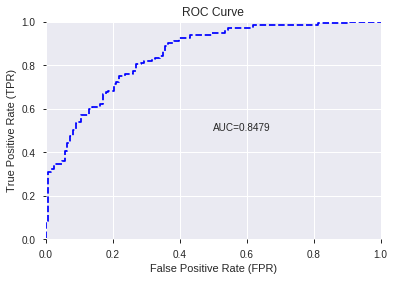

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


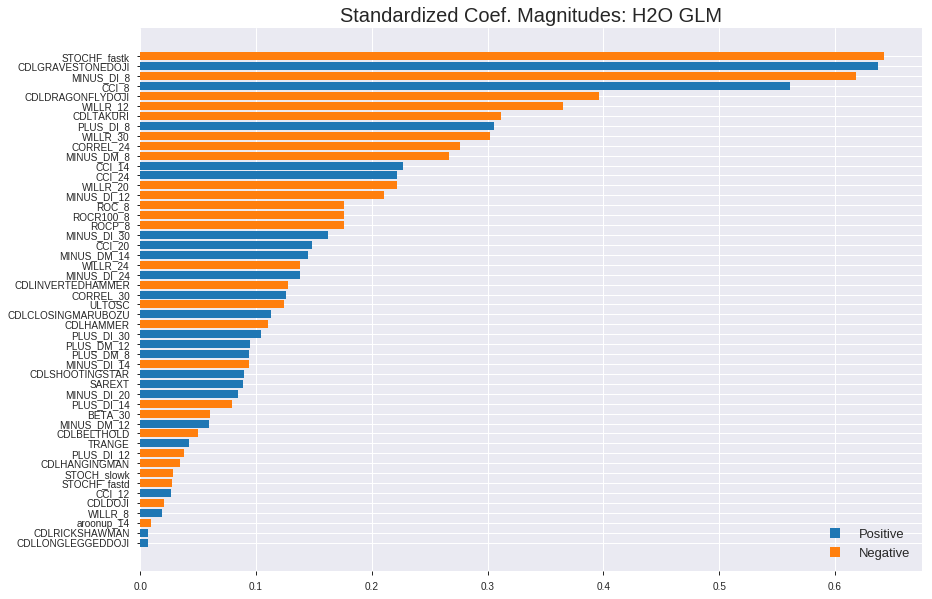

'log_likelihood'
--2019-08-22 16:26:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


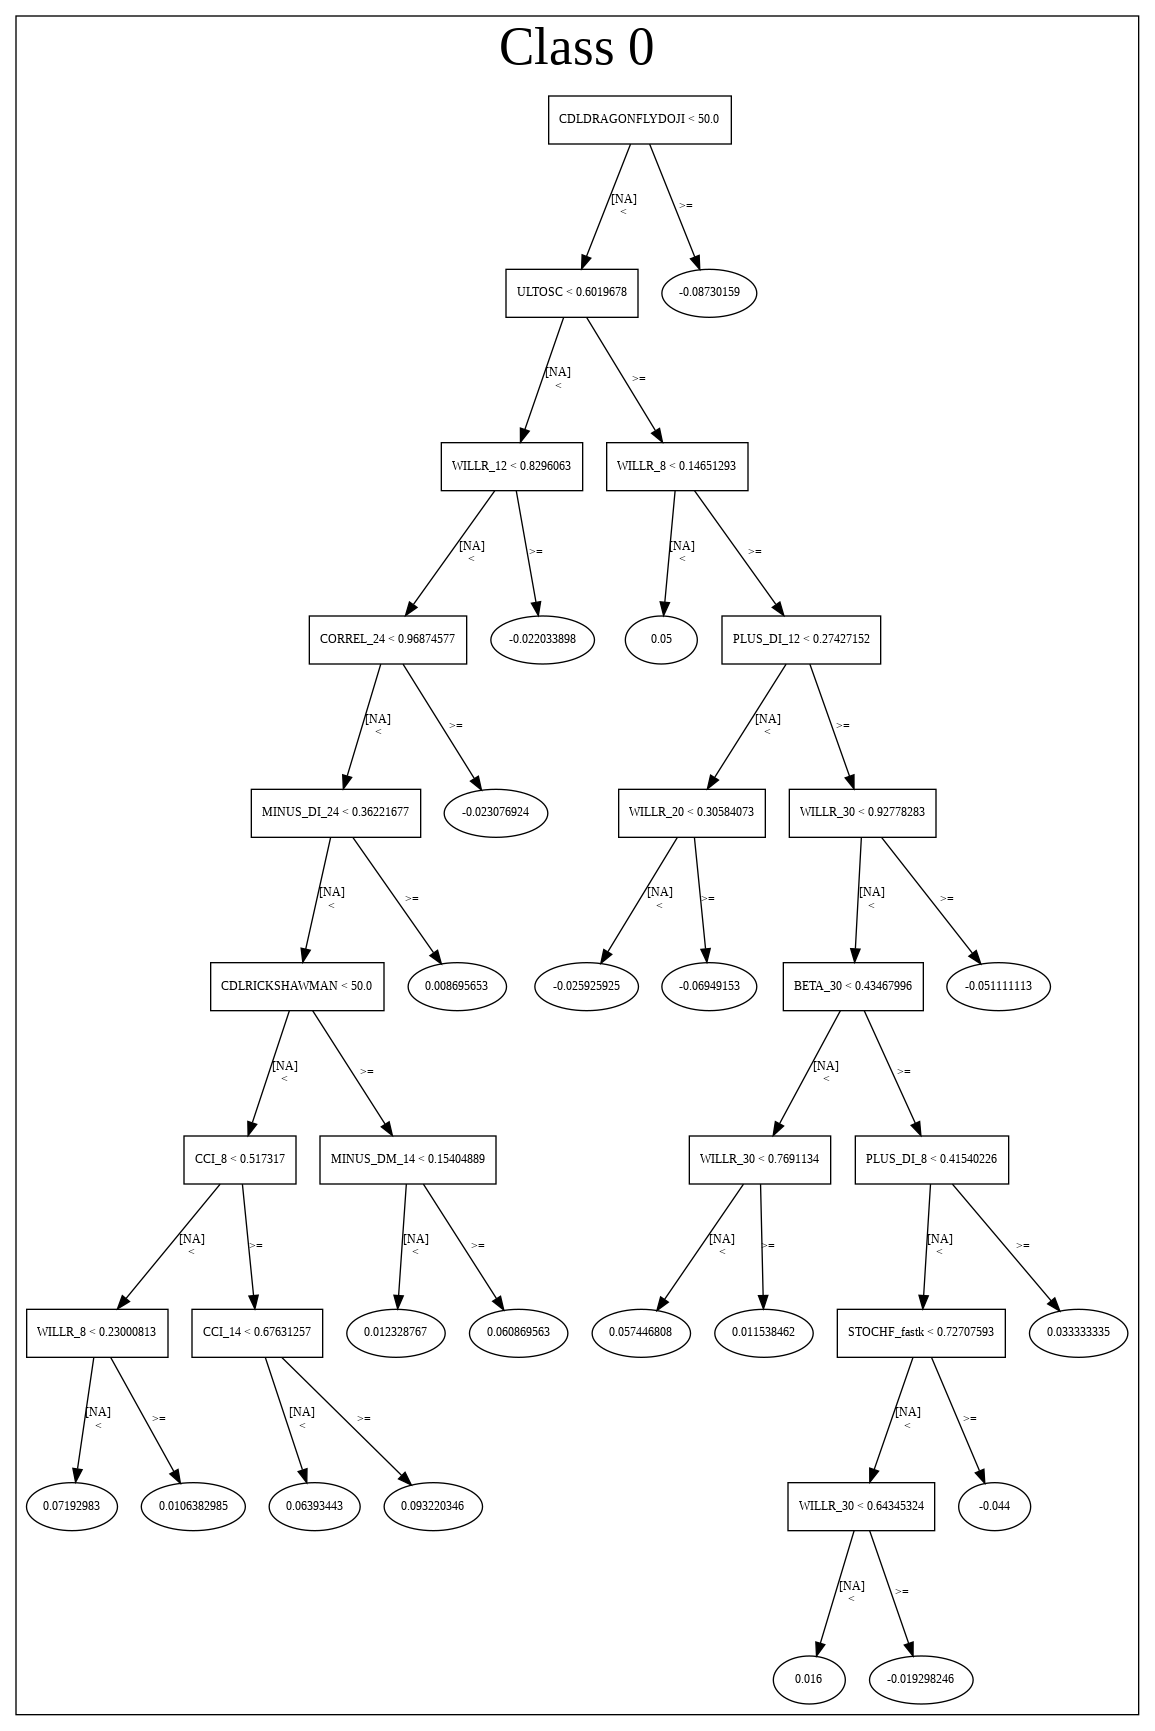

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_162617_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_162617_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'CCI_8',
 'CDLDRAGONFLYDOJI',
 'WILLR_12',
 'CDLTAKURI',
 'PLUS_DI_8',
 'WILLR_30',
 'CORREL_24',
 'MINUS_DM_8',
 'CCI_14',
 'CCI_24',
 'WILLR_20',
 'MINUS_DI_12',
 'ROC_8',
 'ROCR100_8',
 'ROCP_8',
 'MINUS_DI_30',
 'CCI_20',
 'MINUS_DM_14',
 'WILLR_24',
 'MINUS_DI_24',
 'CDLINVERTEDHAMMER',
 'CORREL_30',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'PLUS_DI_30',
 'PLUS_DM_12',
 'PLUS_DM_8',
 'MINUS_DI_14',
 'CDLSHOOTINGSTAR',
 'SAREXT',
 'MINUS_DI_20',
 'PLUS_DI_14',
 'BETA_30',
 'MINUS_DM_12',
 'CDLBELTHOLD',
 'TRANGE',
 'PLUS_DI_12',
 'CDLHANGINGMAN',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_12',
 'CDLDOJI',
 'WILLR_8',
 'aroonup_14',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI']

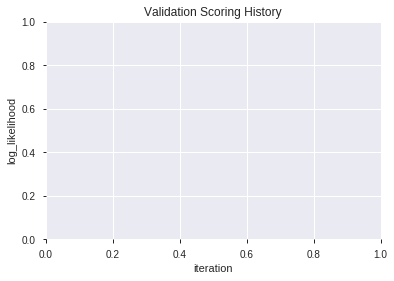

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190822_162629  0.850174  0.485031              0.215936  0.398797  0.159039
1  XGBoost_grid_1_AutoML_20190822_162629_model_4  0.843756  0.500292              0.248670  0.405276  0.164249
2  XGBoost_grid_1_AutoML_20190822_162629_model_6  0.843328  0.493645              0.222538  0.405131  0.164131
3  XGBoost_grid_1_AutoML_20190822_162629_model_5  0.841738  0.505909              0.216242  0.408448  0.166830
4               XGBoost_1_AutoML_20190822_162629  0.839844  0.505183              0.246531  0.409124  0.167383
5               XGBoost_3_AutoML_20190822_162629  0.836848  0.501486              0.246225  0.408974  0.167260
6  XGBoost_grid_1_AutoML_20190822_162629_model_3  0.836481  0.502735              0.240938  0.409002  0.167282
7  XGBoost_grid_1_AutoML_20190822_162629_model_2  0.830246  0.507436              0.280579  0.411955  0.169707
8  XGBoost_grid_1_AutoML_20190822_162629_model_7  0.829696  0.512074              0.250290  0.412838  0.170435
9  XGBoost_grid_1_AutoML_20190822_162629_model_1  0.828718  0.508624              0.248762  0.412537  0.170187

variable  relative_importance  scaled_importance  percentage
0    CDLDRAGONFLYDOJI          1024.981079           1.000000    0.116946
1   CDLGRAVESTONEDOJI           776.788696           0.757857    0.088628
2        STOCHF_fastk           429.538544           0.419070    0.049009
3            WILLR_12           385.314575           0.375924    0.043963
4              ULTOSC           379.157471           0.369917    0.043260
5               CCI_8           359.945770           0.351173    0.041068
6          MINUS_DI_8           357.097260           0.348394    0.040743
7           CORREL_24           269.632324           0.263061    0.030764
8            WILLR_24           241.369186           0.235486    0.027539
9            WILLR_20           240.692108           0.234826    0.027462
10             TRANGE           236.564255           0.230799    0.026991
11            WILLR_8           217.976898           0.212664    0.024870
12           WILLR_30           213.936249           0.208722    0.024409
13             CCI_12           209.120148           0.204023    0.023860
14          PLUS_DM_8           208.625046           0.203540    0.023803
15          CDLTAKURI           197.266510           0.192459    0.022507
16         PLUS_DI_30           189.957306           0.185328    0.021673
17              ROC_8           188.333725           0.183744    0.021488
18             SAREXT           183.542633           0.179069    0.020941
19             CCI_24           180.445526           0.176048    0.020588
20          CORREL_30           177.996994           0.173659    0.020309
21        MINUS_DI_24           156.755219           0.152935    0.017885
22        MINUS_DI_12           136.090149           0.132773    0.015527
23            BETA_30           135.560562           0.132257    0.015467
24        MINUS_DI_14           133.504837           0.130251    0.015232
25        STOCH_slowk           123.045471           0.120047    0.014039
26          PLUS_DI_8           120.950493           0.118003    0.013800
27        MINUS_DI_30           119.598991           0.116684    0.013646
28             CCI_14           118.655693           0.115764    0.013538
29         MINUS_DM_8           105.914978           0.103334    0.012084
30       STOCHF_fastd           105.178215           0.102615    0.012000
31     CDLRICKSHAWMAN            97.558228           0.095181    0.011131
32         PLUS_DM_12            94.819641           0.092509    0.010819
33         PLUS_DI_12            92.859207           0.090596    0.010595
34        MINUS_DM_14            91.766129           0.089530    0.010470
35        MINUS_DI_20            83.029404           0.081006    0.009473
36         PLUS_DI_14            82.321434           0.080315    0.009393
37             CCI_20            68.498398           0.066829    0.007815
38             ROCP_8            67.871048           0.066217    0.007744
39        MINUS_DM_12            52.394279           0.051117    0.005978
40         aroonup_14            47.928074           0.046760    0.005468
41  CDLLONGLEGGEDDOJI            31.184177           0.030424    0.003558
42            CDLDOJI            22.811787           0.022256    0.002603
43          ROCR100_8             7.992397           0.007798    0.000912

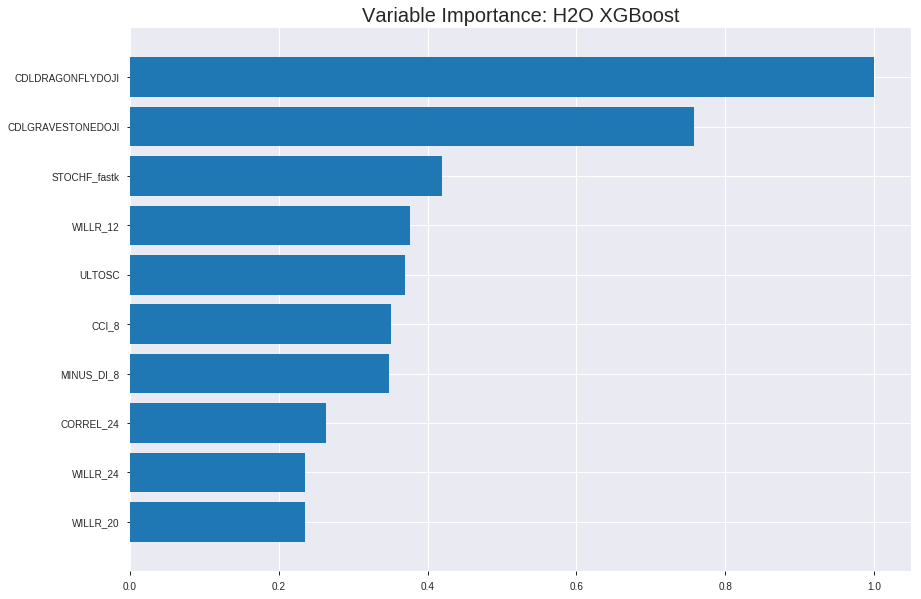

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190822_162629


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.125116674438674
RMSE: 0.3537183546816224
LogLoss: 0.40671040918692114
Mean Per-Class Error: 0.1483072480016817
AUC: 0.925645543137147
pr_auc: 0.9265263723611635
Gini: 0.851291086274294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49295856803655624: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      745  141  0.1591   (141.0/886.0)
1      124  778  0.1375   (124.0/902.0)
Total  869  919  0.1482   (265.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492959     0.854476  203
max f2                       0.343904     0.900351  271
max f0point5                 0.574447     0.880174  164
max accuracy                 0.492959     0.85179   203
max precision                0.955227     1         0
max recall                   0.0994984    1         372
max specificity              0.955227     1         0
max absolute_mcc             0.492959     0.703633  203
max min_per_class_accuracy   0.502092     0.848758  199
max mean_per_class_accuracy  0.492959     0.851693  203

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.937882           1.98226    1.98226            1                0.945696   1                           0.945696            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.926426           1.98226    1.98226            1                0.93023    1                           0.937963            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.915305           1.98226    1.98226            1                0.921601   1                           0.932509            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.909204           1.98226    1.98226            1                0.912684   1                           0.927553            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.904829           1.98226    1.98226            1                0.907104   1                           0.923463            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.874146           1.93772    1.96011            0.977528         0.889369   0.988827                    0.906511            0.0964523       0.196231                   93.7716   96.0113
    7        0.150447                    0.837489           1.93821    1.95279            0.977778         0.855781   0.98513                     0.889538            0.097561        0.293792                   93.8211   95.2786
    8        0.200224                    0.786654           1.8709     1.93243            0.94382          0.813079   0.97486                     0.87053             0.0931264       0.386918                   87.0899   93.2428
    9        0.300336                    0.68854            1.80508    1.88998            0.910615         0.734153   0.953445                    0.825071            0.18071         0.567627                   80.5076   88.9978
    10       0.399888                    0.600784           1.63704    1.82701            0.825843         0.645259   0.921678                    0.780307            0.162971        0.730599                   63.7036   82.7008
    11       0.5                         0.504547           1.15171    1.6918             0.581006         0.549422   0.853468                    0.734078            0.115299        0.845898                   15.1705   69.1796
    12       0.600112                    0.409376           0.73089    1.5315             0.368715         0.459416   0.7726                      0.688258            0.0731707       0.919069                   -26.911   53.1496
    13       0.699664                    0.331387           0.467725   1.38014            0.235955         0.371162   0.696243                    0.64314             0.0465632       0.965632                   -53.2275  38.0136
    14       0.799776                    0.241808           0.199334   1.23233            0.100559         0.285996   0.621678                    0.598435            0.0199557       0.985588                   -80.0666  23.2329
    15       0.899888                    0.117309           0.121815   1.10879            0.0614525        0.181994   0.559354                    0.552106            0.0121951       0.997783                   -87.8185  10.8785
    16       1                           0.038379           0.0221482  1                  0.0111732        0.0798652  0.504474 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1628020698423787
RMSE: 0.40348738498542763
LogLoss: 0.4896236044417057
Mean Per-Class Error: 0.24699699699699695
AUC: 0.8407489121774836
pr_auc: 0.8348331863787071
Gini: 0.6814978243549672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3363668918609619: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  109  0.4208   (109.0/259.0)
1      23   229  0.0913   (23.0/252.0)
Total  173  338  0.2583   (132.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336367     0.776271  270
max f2                       0.189273     0.876325  331
max f0point5                 0.638777     0.768398  136
max accuracy                 0.543634     0.753425  177
max precision                0.95242      1         0
max recall                   0.0761532    1         382
max specificity              0.95242      1         0
max absolute_mcc             0.336367     0.515445  270
max min_per_class_accuracy   0.491934     0.741313  203
max mean_per_class_accuracy  0.518581     0.753003  189

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 48.09 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.940703           2.02778    2.02778            1                0.946434   1                           0.946434            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.925551           2.02778    2.02778            1                0.931661   1                           0.939719            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.917444           2.02778    2.02778            1                0.919557   1                           0.933418            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.901902           2.02778    2.02778            1                0.910549   1                           0.927973            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.897402           1.62222    1.94979            0.8              0.899222   0.961538                    0.922444            0.015873        0.0992063                  62.2222   94.9786
    6        0.101761                    0.864689           1.94979    1.94979            0.961538         0.883314   0.961538                    0.902879            0.0992063       0.198413                   94.9786   94.9786
    7        0.150685                    0.80863            1.78444    1.8961             0.88             0.834688   0.935065                    0.880739            0.0873016       0.285714                   78.4444   89.6104
    8        0.201566                    0.755415           1.71581    1.85059            0.846154         0.77784    0.912621                    0.854765            0.0873016       0.373016                   71.5812   85.0593
    9        0.30137                     0.674433           1.47113    1.72493            0.72549          0.718869   0.850649                    0.80976             0.146825        0.519841                   47.1133   72.4928
    10       0.401174                    0.567924           1.19281    1.59255            0.588235         0.617529   0.785366                    0.761937            0.119048        0.638889                   19.281    59.2547
    11       0.500978                    0.4877             1.07353    1.48915            0.529412         0.528717   0.734375                    0.715475            0.107143        0.746032                   7.35294   48.9149
    12       0.600783                    0.404118           0.954248   1.40029            0.470588         0.441601   0.690554                    0.669978            0.0952381       0.84127                    -4.57516  40.029
    13       0.700587                    0.299827           0.874728   1.32542            0.431373         0.344934   0.653631                    0.623673            0.0873016       0.928571                   -12.5272  32.5419
    14       0.800391                    0.184423           0.556645   1.22956            0.27451          0.236887   0.606357                    0.575443            0.0555556       0.984127                   -44.3355  22.9557
    15       0.900196                    0.093048           0.0397603  1.09764            0.0196078        0.128174   0.541304                    0.525854            0.00396825      0.988095                   -96.024   9.76449
    16       1                           0.0479976          0.119281   1                  0.0588235        0.0753424  0.493151  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:26:31  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.495526                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-08-22 16:26:31  0.064 sec   5                  0.470464         0.635358            0.842655        0.805557           1.98226          0.249441                         0.468815           0.632174              0.832782          0.806256             2.02778            0.268102
    2019-08-22 16:26:31  0.112 sec   10                 0.449257         0.594533            0.862446        0.856451           1.98226          0.215884                         0.448459           0.59266               0.835563          0.828495             2.02778            0.264188
    2019-08-22 16:26:31  0.169 sec   15                 0.433681         0.564187            0.870311        0.865808           1.98226          0.213087                         0.43508            0.565709              0.837485          0.83515              2.02778            0.242661
    2019-08-22 16:26:31  0.222 sec   20                 0.42155          0.540191            0.87712         0.876541           1.98226          0.204139                         0.425698           0.545871              0.838795          0.839219             2.02778            0.244618
    2019-08-22 16:26:31  0.274 sec   25                 0.411406         0.520061            0.885512        0.883395           1.98226          0.204698                         0.418716           0.530644              0.839914          0.837202             2.02778            0.246575
    2019-08-22 16:26:31  0.326 sec   30                 0.40291          0.503096            0.890278        0.88969            1.98226          0.192953                         0.414506           0.520784              0.839952          0.834778             2.02778            0.264188
    2019-08-22 16:26:31  0.432 sec   35                 0.395538         0.488147            0.893561        0.894847           1.98226          0.193512                         0.410202           0.51075               0.842319          0.833271             2.02778            0.268102
    2019-08-22 16:26:31  0.490 sec   40                 0.389195         0.475298            0.896198        0.897981           1.98226          0.191275                         0.407649           0.504209              0.841921          0.837666             2.02778            0.264188
    2019-08-22 16:26:32  0.557 sec   45                 0.383076         0.463563            0.901691        0.901276           1.98226          0.18736                          0.406385           0.500986              0.84212           0.832597             2.02778            0.270059
    2019-08-22 16:26:32  0.618 sec   50                 0.377772         0.45306             0.905858        0.905345           1.98226          0.184564                         0.404909           0.497237              0.843691          0.838021             2.02778            0.268102
    2019-08-22 16:26:32  0.675 sec   55                 0.373378         0.444562            0.909851        0.91144            1.98226          0.1717                           0.404299           0.495137              0.843514          0

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLDRAGONFLYDOJI   1024.9810791015625     1.0                   0.11694594816721257
CDLGRAVESTONEDOJI  776.7886962890625      0.7578566201143433    0.0886282610140709
STOCHF_fastk       429.5385437011719      0.419069729636063     0.049008506880466804
WILLR_12           385.3145751953125      0.37592359805612835   0.04396274161310404
ULTOSC             379.157470703125       0.36991655595776646   0.04326024237923074
---                ---                    ---                   ---
MINUS_DM_12        52.39427947998047      0.05111731381998405   0.005977962732438994
aroonup_14         47.92807388305664      0.04675995963268663   0.0054683878155051225
CDLLONGLEGGEDDOJI  31.18417739868164      0.030424149317971643  0.0035579809891710472
CDLDOJI            22.811786651611328     0.022255812440564057  0.002602727088093409
ROCR100_8          7.992396831512451      0.007797604262625132  0.0009118982239253945


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7890625)

('F1', 0.7970479704797048)

('auc', 0.8501742160278746)

('logloss', 0.4850307609572537)

('mean_per_class_error', 0.21125985695947191)

('rmse', 0.3987967544781272)

('mse', 0.15903885138228765)

xgboost prediction progress: |████████████████████████████████████████████| 100%


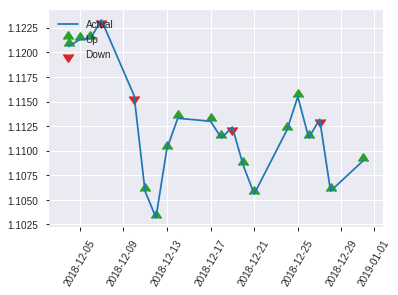


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15903885138228765
RMSE: 0.3987967544781272
LogLoss: 0.4850307609572537
Mean Per-Class Error: 0.21125985695947191
AUC: 0.8501742160278746
pr_auc: 0.8599218991693635
Gini: 0.7003484320557491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5164102911949158: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      93   30   0.2439   (30.0/123.0)
1      25   108  0.188    (25.0/133.0)
Total  118  138  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51641      0.797048  137
max f2                       0.167308     0.874832  210
max f0point5                 0.623908     0.813743  104
max accuracy                 0.539521     0.789062  132
max precision                0.956957     1         0
max recall                   0.0568543    1         253
max specificity              0.956957     1         0
max absolute_mcc             0.539521     0.57748   132
max min_per_class_accuracy   0.543713     0.780488  130
max mean_per_class_accuracy  0.539521     0.78874   132

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 52.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.944696           1.92481   1.92481            1                0.950938  1                           0.950938            0.0225564       0.0225564                  92.4812    92.4812
    2        0.0234375                   0.937335           1.92481   1.92481            1                0.940479  1                           0.945708            0.0225564       0.0451128                  92.4812    92.4812
    3        0.03125                     0.921636           1.92481   1.92481            1                0.925625  1                           0.940687            0.0150376       0.0601504                  92.4812    92.4812
    4        0.0429688                   0.918556           1.92481   1.92481            1                0.919126  1                           0.934807            0.0225564       0.0827068                  92.4812    92.4812
    5        0.0507812                   0.914482           1.92481   1.92481            1                0.916624  1                           0.93201             0.0150376       0.0977444                  92.4812    92.4812
    6        0.101562                    0.889021           1.77675   1.85078            0.923077         0.902627  0.961538                    0.917318            0.0902256       0.18797                    77.675     85.0781
    7        0.152344                    0.8567             1.92481   1.87546            1                0.871601  0.974359                    0.902079            0.0977444       0.285714                   92.4812    87.5458
    8        0.203125                    0.819461           1.48062   1.77675            0.769231         0.837371  0.923077                    0.885902            0.075188        0.360902                   48.0625    77.675
    9        0.300781                    0.731337           1.61684   1.72483            0.84             0.785942  0.896104                    0.853447            0.157895        0.518797                   61.6842    72.4832
    10       0.402344                    0.625917           1.40659   1.6445             0.730769         0.678954  0.854369                    0.8094              0.142857        0.661654                   40.6593    64.45
    11       0.5                         0.553548           1.0009    1.5188             0.52             0.58344   0.789062                    0.765268            0.0977444       0.759398                   0.0902256  51.8797
    12       0.601562                    0.465879           0.666281  1.37487            0.346154         0.510451  0.714286                    0.722247            0.0676692       0.827068                   -33.3719   37.4866
    13       0.699219                    0.363254           0.769925  1.29038            0.4              0.411298  0.670391                    0.678818            0.075188        0.902256                   -23.0075   29.0377
    14       0.800781                    0.221755           0.59225   1.20183            0.307692         0.294012  0.62439                     0.630013            0.0601504       0.962406                   -40.775    20.1834
    15       0.898438                    0.101061           0.230977  1.09631            0.12             0.141773  0.569565                    0.576944            0.0225564       0.984962                   -76.9023   9.6306
    16       1                           0.0482199          0.148062  1                  0.0769231        0.082455  0.519531                    0.52

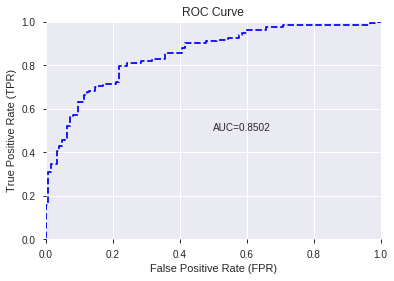

This function is available for GLM models only


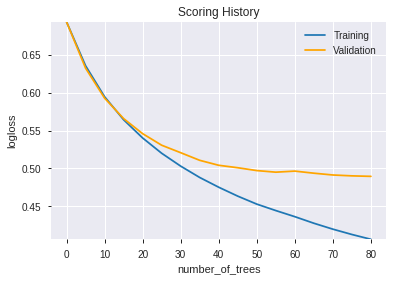

--2019-08-22 16:26:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


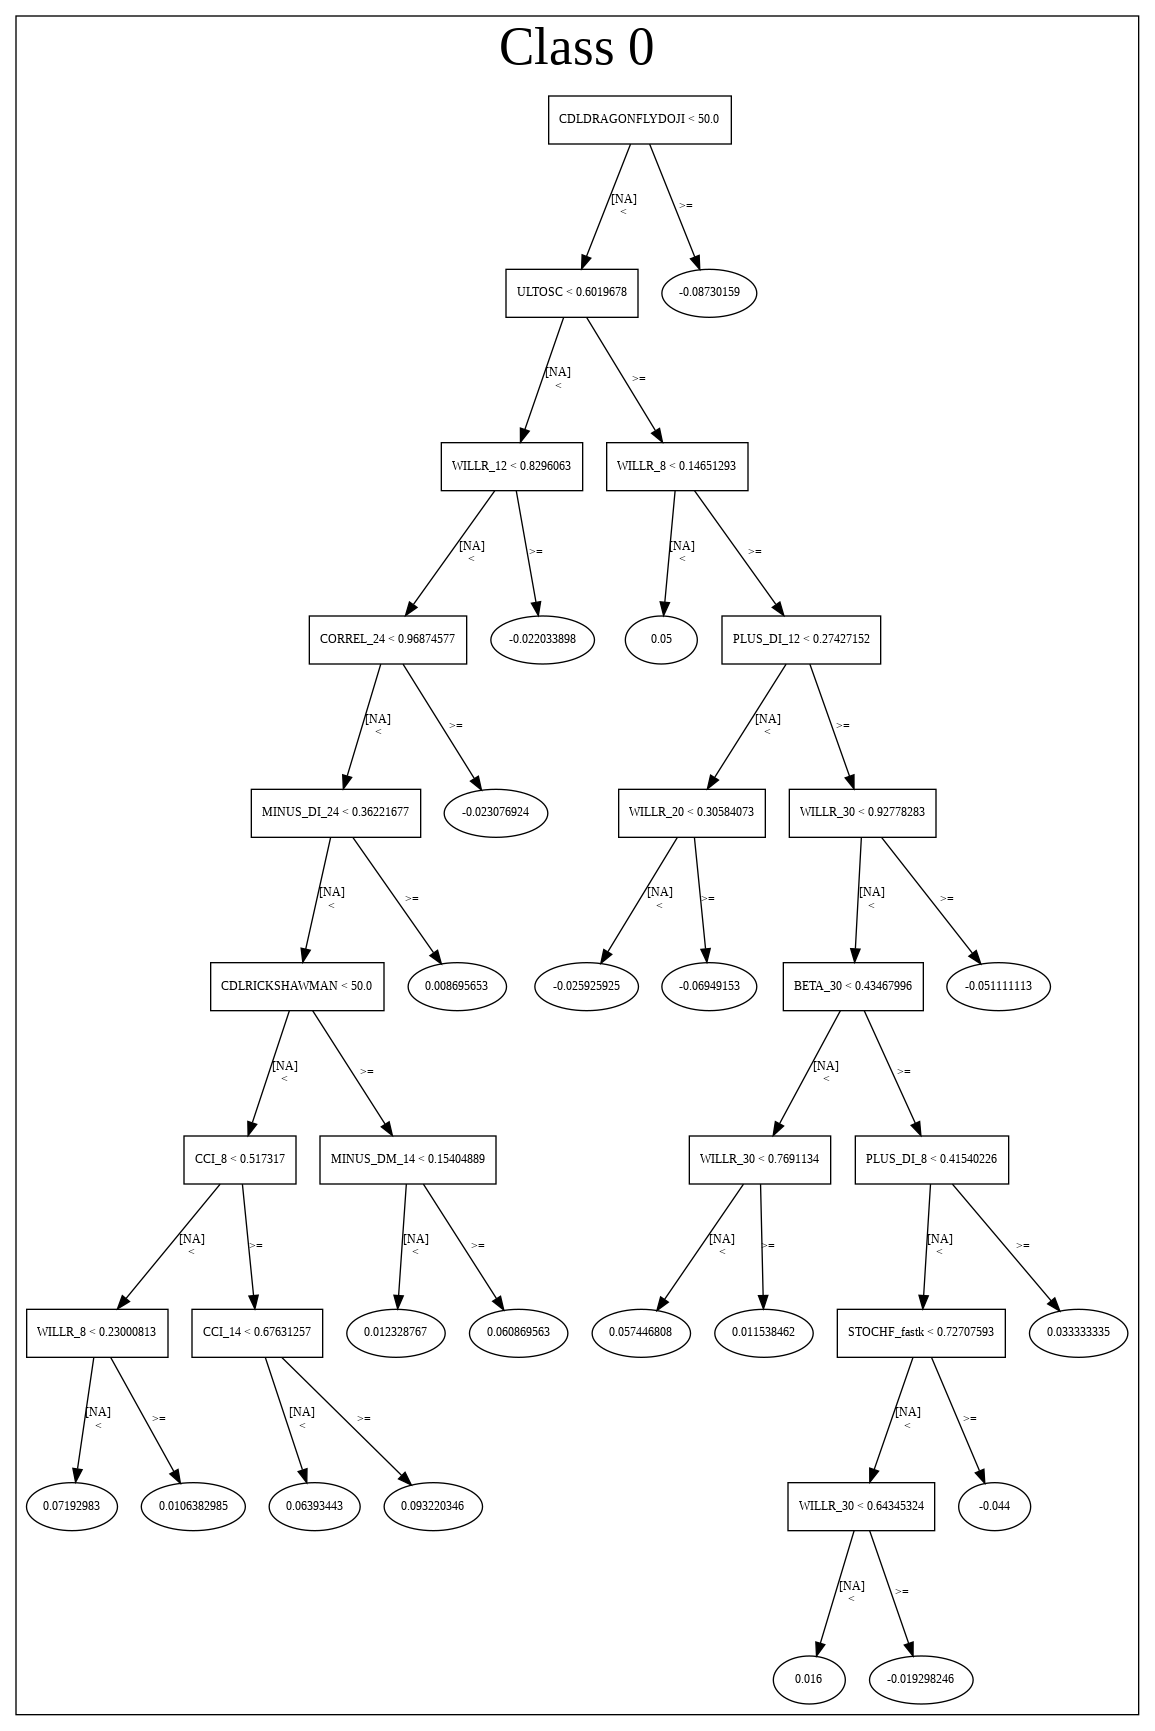

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190822_162629',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190822_162629',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_9e4e',
   'type

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'WILLR_12',
 'ULTOSC',
 'CCI_8',
 'MINUS_DI_8',
 'CORREL_24',
 'WILLR_24',
 'WILLR_20',
 'TRANGE',
 'WILLR_8',
 'WILLR_30',
 'CCI_12',
 'PLUS_DM_8',
 'CDLTAKURI',
 'PLUS_DI_30',
 'ROC_8',
 'SAREXT',
 'CCI_24',
 'CORREL_30',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'BETA_30',
 'MINUS_DI_14',
 'STOCH_slowk',
 'PLUS_DI_8',
 'MINUS_DI_30',
 'CCI_14',
 'MINUS_DM_8',
 'STOCHF_fastd',
 'CDLRICKSHAWMAN',
 'PLUS_DM_12',
 'PLUS_DI_12',
 'MINUS_DM_14',
 'MINUS_DI_20',
 'PLUS_DI_14',
 'CCI_20',
 'ROCP_8',
 'MINUS_DM_12',
 'aroonup_14',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'ROCR100_8']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [905 915 920 924] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


20

['CCI_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_8',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI',
 'BETA_8',
 'BETA_20']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_162658_model_8  0.859405  0.500628              0.232105  0.407743  0.166254
1  DeepLearning_grid_1_AutoML_20190822_162658_model_9  0.846873  0.501824              0.234030  0.410150  0.168223
2  DeepLearning_grid_1_AutoML_20190822_162658_model_6  0.846079  0.498002              0.247142  0.408905  0.167204
3               DeepLearning_1_AutoML_20190822_162658  0.838865  0.494229              0.265236  0.404838  0.163894
4  DeepLearning_grid_1_AutoML_20190822_162658_model_5  0.829085  0.518095              0.280885  0.418364  0.175028
5  DeepLearning_grid_1_AutoML_20190822_162658_model_3  0.816370  0.515299              0.303961  0.416025  0.173077
6  DeepLearning_grid_1_AutoML_20190822_162658_model_1  0.809952  0.527348              0.290849  0.420809  0.177080
7  DeepLearning_grid_1_AutoML_20190822_162658_model_2  0.805978  0.515393              0.287090  0.417710  0.174482
8  DeepLearning_grid_1_AutoML_20190822_162658_model_4  0.795342  0.539705              0.330888  0.432416  0.186984
9  DeepLearning_grid_1_AutoML_20190822_162658_model_7  0.786753  0.519827              0.320527  0.422828  0.178784

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.000000           1.000000    0.087209
1         STOCHF_fastk             0.821994           0.821994    0.071685
2    CDLGRAVESTONEDOJI             0.755282           0.755282    0.065867
3              WILLR_8             0.717335           0.717335    0.062558
4     CDLDRAGONFLYDOJI             0.702306           0.702306    0.061247
5            CDLTAKURI             0.650969           0.650969    0.056770
6               ULTOSC             0.649135           0.649135    0.056610
7           MINUS_DI_8             0.629404           0.629404    0.054889
8              BETA_20             0.623210           0.623210    0.054349
9            CDLHAMMER             0.555095           0.555095    0.048409
10           PLUS_DI_8             0.539440           0.539440    0.047044
11         CDLBELTHOLD             0.515103           0.515103    0.044921
12              BETA_8             0.484202           0.484202    0.042227
13  CDLCLOSINGMARUBOZU             0.441677           0.441677    0.038518
14        STOCHF_fastd             0.436306           0.436306    0.038050
15         STOCH_slowk             0.428999           0.428999    0.037412
16           PLUS_DM_8             0.427380           0.427380    0.037271
17     CDLSHOOTINGSTAR             0.382826           0.382826    0.033386
18       CDLHANGINGMAN             0.353429           0.353429    0.030822
19   CDLINVERTEDHAMMER             0.352676           0.352676    0.030756

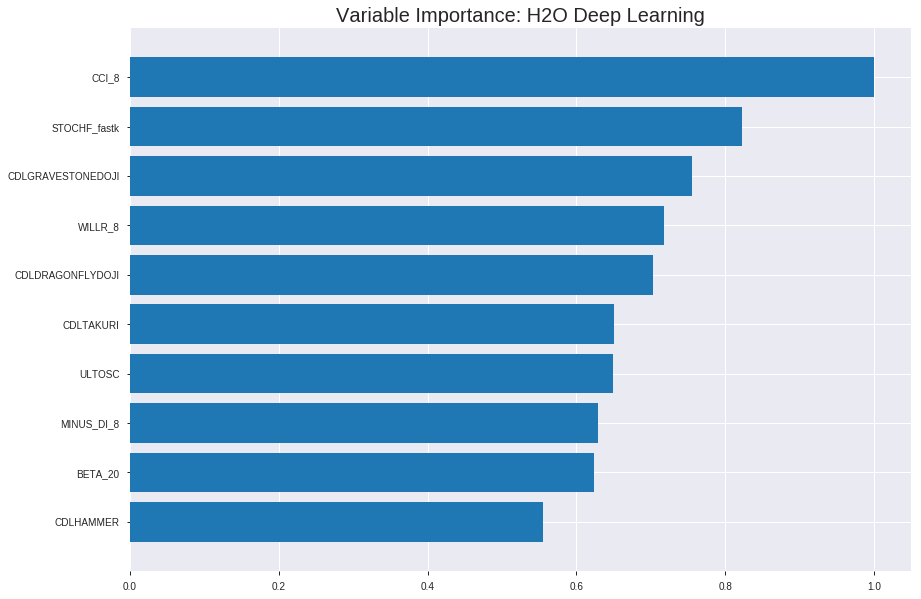

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_162658_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18495917072609988
RMSE: 0.430068797666257
LogLoss: 0.5404634000155817
Mean Per-Class Error: 0.2826500427942922
AUC: 0.7981398247185837
pr_auc: 0.80969773557234
Gini: 0.5962796494371674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4244534657343672: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      479  407   0.4594   (407.0/886.0)
1      136  766   0.1508   (136.0/902.0)
Total  615  1173  0.3037   (543.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424453     0.738313  254
max f2                       0.0617582    0.85942   367
max f0point5                 0.487271     0.731643  203
max accuracy                 0.474814     0.717002  215
max precision                0.988893     1         0
max recall                   0.0106986    1         393
max specificity              0.988893     1         0
max absolute_mcc             0.474814     0.435872  215
max min_per_class_accuracy   0.468286     0.707675  222
max mean_per_class_accuracy  0.474814     0.71735   215

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 47.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.968801           1.98226    1.98226            1                0.975854   1                           0.975854            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.959104           1.98226    1.98226            1                0.964396   1                           0.970125            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.953852           1.98226    1.98226            1                0.956465   1                           0.965572            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.947086           1.98226    1.98226            1                0.950811   1                           0.961882            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.939787           1.98226    1.98226            1                0.943759   1                           0.958257            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.86993            1.80408    1.89367            0.910112         0.90951    0.955307                    0.93402             0.0898004       0.189579                   80.4081   89.3669
    7        0.150447                    0.732228           1.71796    1.83488            0.866667         0.802577   0.925651                    0.890043            0.0864745       0.276053                   71.796    83.4882
    8        0.200224                    0.630343           1.53681    1.76078            0.775281         0.67461    0.888268                    0.836485            0.0764967       0.35255                    53.681    76.078
    9        0.300336                    0.533103           1.37319    1.63158            0.692737         0.573125   0.823091                    0.748699            0.137472        0.490022                   37.3187   63.1582
    10       0.399888                    0.487596           1.21386    1.52759            0.61236          0.507018   0.770629                    0.688532            0.120843        0.610865                   21.3857   52.7589
    11       0.5                         0.468379           0.963446   1.41463            0.486034         0.477101   0.713647                    0.646199            0.0964523       0.707317                   -3.65544  41.4634
    12       0.600112                    0.449194           0.919149   1.33198            0.463687         0.460335   0.671948                    0.615193            0.0920177       0.799335                   -8.08507  33.1976
    13       0.699664                    0.405123           0.801814   1.25654            0.404494         0.426589   0.633893                    0.588357            0.0798226       0.879157                   -19.8186  25.6542
    14       0.799776                    0.339089           0.664445   1.18243            0.335196         0.373914   0.596503                    0.561514            0.0665188       0.945676                   -33.5555  18.2426
    15       0.899888                    0.0505716          0.465112   1.10263            0.234637         0.251897   0.556246                    0.527069            0.0465632       0.992239                   -53.4888  10.2625
    16       1                           0.000554432        0.0775186  1                  0.0391061        0.0194346  0.504474  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17124686676457013
RMSE: 0.4138198482003614
LogLoss: 0.5080835898298498
Mean Per-Class Error: 0.2393286143286144
AUC: 0.8352561745418888
pr_auc: 0.8124218398770189
Gini: 0.6705123490837777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3791976660345689: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  113  0.4363   (113.0/259.0)
1      22   230  0.0873   (22.0/252.0)
Total  168  343  0.2642   (135.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379198     0.773109  270
max f2                       0.265492     0.876508  318
max f0point5                 0.473411     0.7689    186
max accuracy                 0.473411     0.761252  186
max precision                0.985066     1         0
max recall                   0.016152     1         381
max specificity              0.985066     1         0
max absolute_mcc             0.473411     0.524124  186
max min_per_class_accuracy   0.460917     0.749035  202
max mean_per_class_accuracy  0.469415     0.760671  189

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 44.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.967636           2.02778    2.02778            1                0.97788    1                           0.97788             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.962456           1.62222    1.84343            0.8              0.964661   0.909091                    0.971871            0.015873        0.0396825                  62.2222   84.3434
    3        0.0313112                   0.952434           1.62222    1.77431            0.8              0.955568   0.875                       0.966776            0.015873        0.0555556                  62.2222   77.4306
    4        0.0410959                   0.946772           1.62222    1.7381             0.8              0.94861    0.857143                    0.962451            0.015873        0.0714286                  62.2222   73.8095
    5        0.0508806                   0.93774            2.02778    1.7938             1                0.942802   0.884615                    0.958672            0.0198413       0.0912698                  102.778   79.3803
    6        0.101761                    0.869515           2.02778    1.91079            1                0.912624   0.942308                    0.935648            0.103175        0.194444                   102.778   91.0791
    7        0.150685                    0.733132           1.78444    1.86977            0.88             0.804625   0.922078                    0.893108            0.0873016       0.281746                   78.4444   86.9769
    8        0.201566                    0.60648            1.55983    1.79153            0.769231         0.663145   0.883495                    0.835059            0.0793651       0.361111                   55.9829   79.1532
    9        0.30137                     0.523247           1.43137    1.67226            0.705882         0.557593   0.824675                    0.743171            0.142857        0.503968                   43.1373   67.2258
    10       0.401174                    0.482984           1.31209    1.58266            0.647059         0.50076    0.780488                    0.682864            0.130952        0.634921                   31.2092   58.2656
    11       0.500978                    0.460511           1.19281    1.50499            0.588235         0.470971   0.742188                    0.640651            0.119048        0.753968                   19.281    50.4991
    12       0.600783                    0.421391           0.834967   1.39368            0.411765         0.443238   0.687296                    0.607856            0.0833333       0.837302                   -16.5033  39.3684
    13       0.700587                    0.349622           0.874728   1.31975            0.431373         0.3941     0.650838                    0.577405            0.0873016       0.924603                   -12.5272  31.9755
    14       0.800391                    0.239897           0.596405   1.22956            0.294118         0.302029   0.606357                    0.543067            0.0595238       0.984127                   -40.3595  22.9557
    15       0.900196                    0.0247627          0.119281   1.10646            0.0588235        0.0938272  0.545652                    0.49326             0.0119048       0.996032                   -88.0719  10.6461
    16       1                           0.000717614        0.0397603  1                  0.0196078        0.0138403  0.493151 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:35:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:35:05  2 min  3.207 sec  603 obs/sec       0.655481  1             1172       0.481634         0.669964            0.0720389      0.716965        0.707796           1.98226          0.381432                         0.443568           0.583654              0.212841         0.774484          0.727823             1.35185            0.311155
    2019-08-22 16:35:20  2 min 18.220 sec  916 obs/sec       7.94463   12            14205      0.441406         0.565966            0.22058        0.778414        0.785012           1.98226          0.318233                         0.422506           0.526892              0.285821         0.824225          0.807137             2.02778            0.273973
    2019-08-22 16:35:35  2 min 33.717 sec  1000 obs/sec      16.4916   25            29487      0.436689         0.556092            0.237149       0.783141        0.789561           1.98226          0.345638                         0.418623           0.518354              0.298889         0.824531          0.804196             2.02778            0.270059
    2019-08-22 16:35:51  2 min 49.184 sec  1036 obs/sec      25.2013   38            45060      0.435205         0.549918            0.242324       0.793847        0.803362           1.98226          0.29698                          0.423607           0.52979               0.282095         0.833801          0.804995             1.68981            0.273973
    2019-08-22 16:36:06  3 min  4.723 sec  1072 obs/sec      34.4983   52            61683      0.430069         0.540463            0.260104       0.79814         0.809698           1.98226          0.303691                         0.41382            0.508084              0.314884         0.835256          0.812422             2.02778            0.264188
    2019-08-22 16:36:22  3 min 19.985 sec  1098 obs/sec      43.8674   66            78435      0.428954         0.536288            0.263936       0.797592        0.807742           1.98226          0.329418                         0.420426           0.525609              0.292834         0.827289          0.796414             1.68981            0.262231
    2019-08-22 16:36:37  3 min 34.817 sec  1122 obs/sec      53.1779   80            95082      0.427917         0.534539            0.267489       0.813371        0.826381           1.98226          0.294743                         0.422875           0.524391              0.284574         0.83485           0.81415              2.02778            0.268102
    2019-08-22 16:36:38  3 min 36.335 sec  1121 obs/sec      53.1779   80            95082      0.430069         0.540463            0.260104       0.79814         0.809698           1.98226          0.303691                         0.41382            0.508084              0.314884         0.835256          0.812422             2.02778            0.264188

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CCI_8               1                      1                    0.0872085
STOCHF_fastk        0.821994               0.821994             0.0716849
CDLGRAVESTONEDOJI   0.755282               0.755282             0.065867
WILLR_8             0.717335               0.717335             0.0625577
CDLDRAGONFLYDOJI    0.702306               0.702306             0.0612471
CDLTAKURI           0.650969               0.650969             0.0567701
ULTOSC              0.649135               0.649135             0.0566101
MINUS_DI_8          0.629404               0.629404             0.0548894
BETA_20             0.62321                0.62321              0.0543493
CDLHAMMER           0.555095               0.555095             0.048409
PLUS_DI_8           0.53944                0.53944              0.0470438
CDLBELTHOLD         0.515103               0.515103             0.0449214
BETA_8              0.484202               0.484202             0.0422265
CDLCLOSINGMARUBOZU  0.441677               0.441677             0.038518
STOCHF_fastd        0.436306               0.436306             0.0380496
STOCH_slowk         0.428999               0.428999             0.0374124
PLUS_DM_8           0.42738                0.42738              0.0372712
CDLSHOOTINGSTAR     0.382826               0.382826             0.0333857
CDLHANGINGMAN       0.353429               0.353429             0.0308221
CDLINVERTEDHAMMER   0.352676               0.352676             0.0307564

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78515625)

('F1', 0.8066666666666668)

('auc', 0.8594046090836849)

('logloss', 0.5006279946980237)

('mean_per_class_error', 0.21501925545571243)

('rmse', 0.40774272917202076)

('mse', 0.16625413319264787)

deeplearning prediction progress: |███████████████████████████████████████| 100%


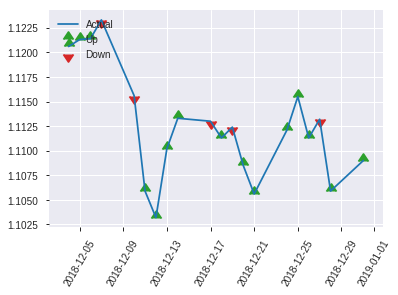


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16625413319264787
RMSE: 0.40774272917202076
LogLoss: 0.5006279946980237
Mean Per-Class Error: 0.21501925545571243
AUC: 0.8594046090836849
pr_auc: 0.8572963133040206
Gini: 0.7188092181673698
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4255913007473659: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   46   0.374    (46.0/123.0)
1      12   121  0.0902   (12.0/133.0)
Total  89   167  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425591     0.806667  166
max f2                       0.352744     0.891632  196
max f0point5                 0.489851     0.806988  116
max accuracy                 0.472843     0.785156  131
max precision                0.985753     1         0
max recall                   0.0119378    1         239
max specificity              0.985753     1         0
max absolute_mcc             0.472843     0.569805  131
max min_per_class_accuracy   0.473775     0.780488  130
max mean_per_class_accuracy  0.472843     0.784981  131

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 47.10 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.96267            1.92481    1.92481            1                0.972989   1                           0.972989            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.956595           1.92481    1.92481            1                0.960269   1                           0.966629            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.938923           1.92481    1.92481            1                0.940582   1                           0.960117            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.934724           1.92481    1.92481            1                0.936745   1                           0.953743            0.0225564       0.0827068                  92.4812   92.4812
    5        0.0507812                   0.926857           1.92481    1.92481            1                0.930834   1                           0.950219            0.0150376       0.0977444                  92.4812   92.4812
    6        0.101562                    0.856256           1.92481    1.92481            1                0.903118   1                           0.926668            0.0977444       0.195489                   92.4812   92.4812
    7        0.152344                    0.734441           1.62869    1.8261             0.846154         0.784718   0.948718                    0.879352            0.0827068       0.278195                   62.8687   82.6104
    8        0.203125                    0.643284           1.33256    1.70272            0.692308         0.67987    0.884615                    0.829481            0.0676692       0.345865                   33.2562   70.2718
    9        0.300781                    0.568594           1.69383    1.69983            0.88             0.605662   0.883117                    0.756812            0.165414        0.511278                   69.3835   69.9834
    10       0.402344                    0.500311           1.33256    1.60712            0.692308         0.53111    0.834951                    0.699839            0.135338        0.646617                   33.2562   60.7125
    11       0.5                         0.475873           1.23188    1.53383            0.64             0.490499   0.796875                    0.658952            0.120301        0.766917                   23.188    53.3835
    12       0.601562                    0.446169           0.962406   1.43736            0.5              0.465357   0.746753                    0.626267            0.0977444       0.864662                   -3.7594   43.736
    13       0.699219                    0.393299           0.61594    1.32264            0.32             0.422707   0.687151                    0.597837            0.0601504       0.924812                   -38.406   32.2636
    14       0.800781                    0.32519            0.518219   1.22061            0.269231         0.36347    0.634146                    0.568112            0.0526316       0.977444                   -48.1781  22.0613
    15       0.898438                    0.0248809          0.0769925  1.09631            0.04             0.15289    0.569565                    0.52298             0.0075188       0.984962                   -92.3008  9.6306
    16       1                           0.00108183         0.148062   1                  0.0769231        0.0114428  0.519531   

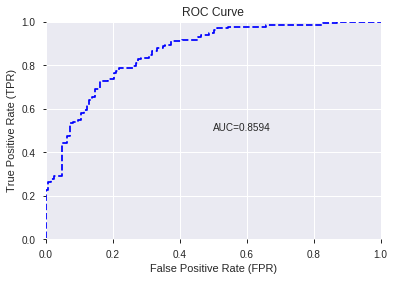

This function is available for GLM models only


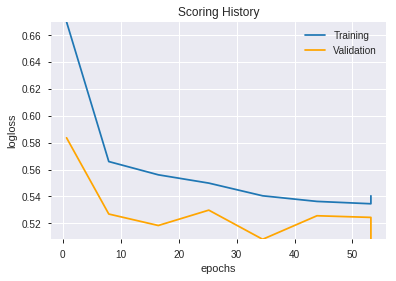

--2019-08-22 16:39:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


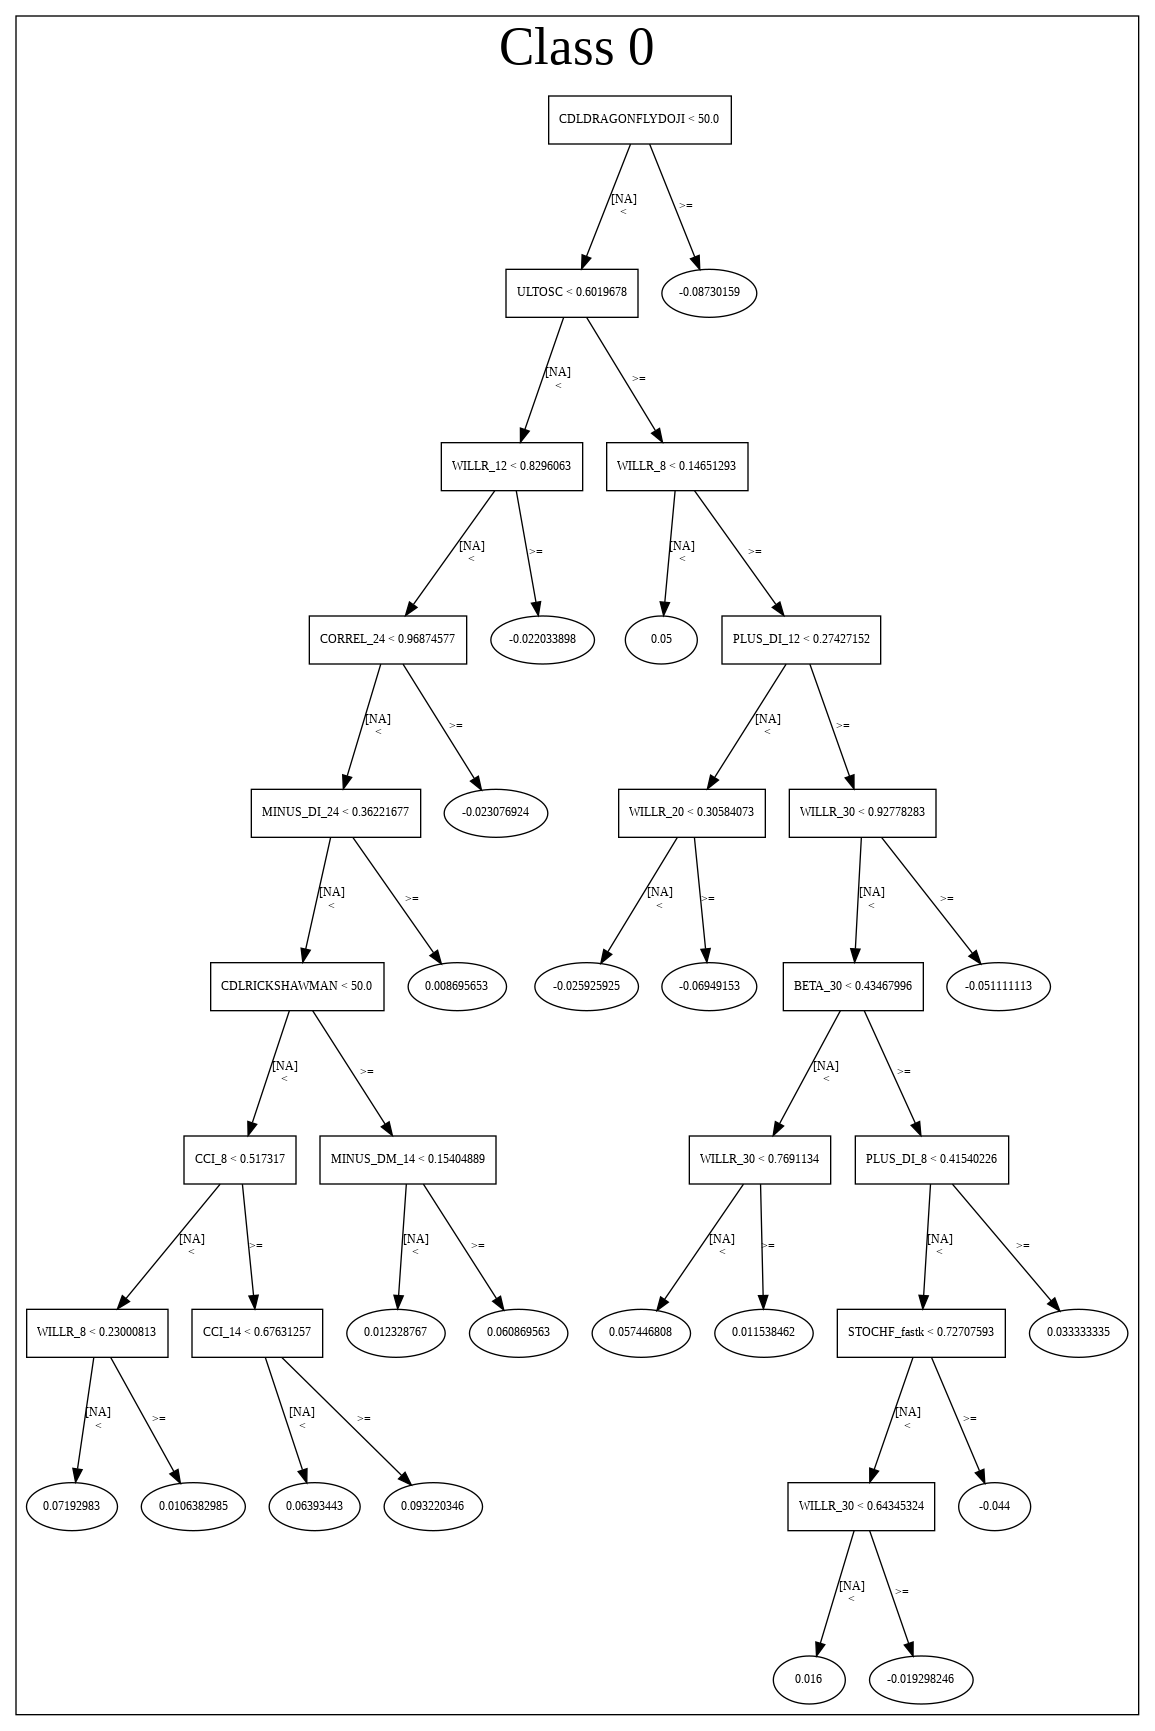

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_162658_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_162658_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CCI_8',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'ULTOSC',
 'MINUS_DI_8',
 'BETA_20',
 'CDLHAMMER',
 'PLUS_DI_8',
 'CDLBELTHOLD',
 'BETA_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastd',
 'STOCH_slowk',
 'PLUS_DM_8',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_163935_model_1  0.863256  0.474456              0.194908  0.395309  0.156269

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.152852           1.000000    0.212692
1              WILLR_8             0.816253           0.708029    0.150592
2    CDLGRAVESTONEDOJI             0.748642           0.649382    0.138118
3         STOCHF_fastk             0.577232           0.500699    0.106494
4     CDLDRAGONFLYDOJI             0.575089           0.498840    0.106099
5           MINUS_DI_8             0.244222           0.211842    0.045057
6            CDLTAKURI             0.221534           0.192161    0.040871
7    CDLINVERTEDHAMMER             0.204667           0.177531    0.037759
8            PLUS_DM_8             0.170463           0.147862    0.031449
9      CDLSHOOTINGSTAR             0.125799           0.109120    0.023209
10  CDLCLOSINGMARUBOZU             0.117411           0.101844    0.021661
11           CDLHAMMER             0.107679           0.093402    0.019866
12              ULTOSC             0.100808           0.087442    0.018598
13       CDLHANGINGMAN             0.074677           0.064776    0.013777
14         CDLBELTHOLD             0.068968           0.059824    0.012724
15              BETA_8             0.049062           0.042557    0.009052
16             BETA_20             0.040327           0.034980    0.007440
17           PLUS_DI_8             0.013294           0.011532    0.002453
18         STOCH_slowk             0.008970           0.007781    0.001655
19        STOCHF_fastd             0.002351           0.002040    0.000434

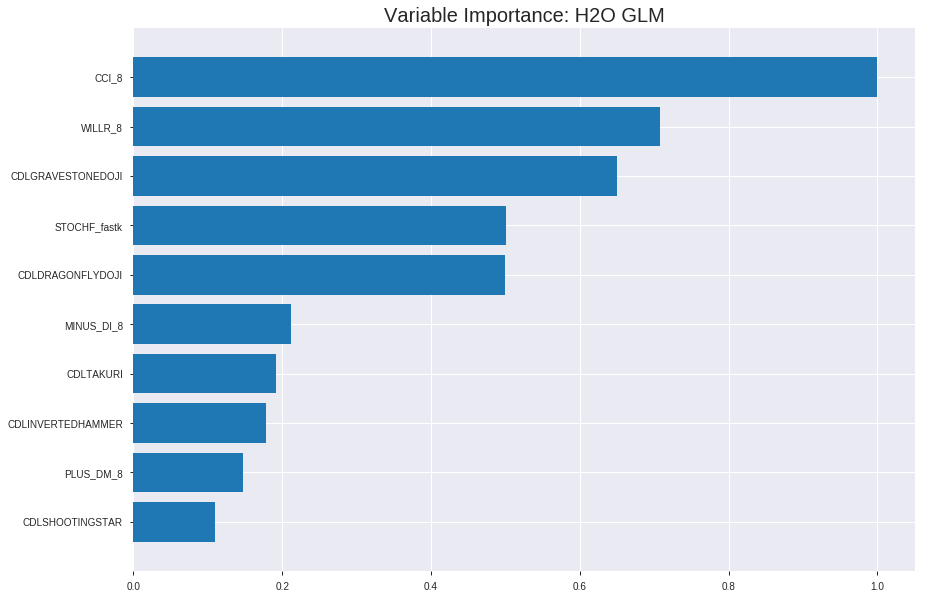

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_163935_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1853526136081619
RMSE: 0.430525973209703
LogLoss: 0.5434850343022326
Null degrees of freedom: 1787
Residual degrees of freedom: 1767
Null deviance: 2478.551139037676
Residual deviance: 1943.5024826647837
AIC: 1985.5024826647837
AUC: 0.7924357960489107
pr_auc: 0.7959602954890647
Gini: 0.5848715920978214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43039969515182175: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      492  394   0.4447   (394.0/886.0)
1      152  750   0.1685   (152.0/902.0)
Total  644  1144  0.3054   (546.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4304       0.733138  240
max f2                       0.171584     0.856701  341
max f0point5                 0.577668     0.723938  164
max accuracy                 0.510556     0.717562  200
max precision                0.993878     1         0
max recall                   0.044703     1         383
max specificity              0.993878     1         0
max absolute_mcc             0.510556     0.435131  200
max min_per_class_accuracy   0.509298     0.716704  201
max mean_per_class_accuracy  0.510556     0.717574  200

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.973457           1.98226   1.98226            1                0.983669   1                           0.983669            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.962183           1.98226   1.98226            1                0.96761    1                           0.975639            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.953234           1.76201   1.90884            0.888889         0.959013   0.962963                    0.970097            0.0177384       0.0576497                  76.201    90.8845
    4        0.0402685                   0.945422           1.87214   1.89967            0.944444         0.949587   0.958333                    0.96497             0.018847        0.0764967                  87.2136   89.9667
    5        0.0503356                   0.937404           1.87214   1.89416            0.944444         0.941108   0.955556                    0.960197            0.018847        0.0953437                  87.2136   89.4161
    6        0.100112                    0.882546           1.75954   1.82722            0.88764          0.910694   0.921788                    0.935584            0.0875831       0.182927                   75.9536   82.7224
    7        0.150447                    0.791884           1.69593   1.7833             0.855556         0.832123   0.899628                    0.900969            0.0853659       0.268293                   69.5935   78.3299
    8        0.200224                    0.716078           1.55908   1.72756            0.786517         0.74832    0.871508                    0.86302             0.0776053       0.345898                   55.9082   72.7558
    9        0.300336                    0.626985           1.41748   1.6242             0.715084         0.670398   0.819367                    0.798813            0.141907        0.487805                   41.7483   62.4199
    10       0.399888                    0.566057           1.10249   1.49432            0.55618          0.595618   0.753846                    0.748227            0.109756        0.597561                   10.2494   49.432
    11       0.5                         0.510133           1.17385   1.43016            0.592179         0.535043   0.721477                    0.705542            0.117517        0.715078                   17.3853   43.0155
    12       0.600112                    0.453589           0.830557  1.33013            0.418994         0.480643   0.671016                    0.668024            0.0831486       0.798226                   -16.9443  33.0129
    13       0.699664                    0.393314           0.746132  1.24703            0.376404         0.423394   0.629097                    0.633217            0.0742794       0.872506                   -25.3868  24.7034
    14       0.799776                    0.307614           0.697668  1.17827            0.351955         0.353167   0.594406                    0.598162            0.0698448       0.94235                    -30.2332  17.8267
    15       0.899888                    0.0910956          0.465112  1.09893            0.234637         0.215706   0.554382                    0.555614            0.0465632       0.988914                   -53.4888  9.89294
    16       1                           0.00235378         0.110741  1                  0.0558659        0.0447911  0.504474                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16743406180791878
RMSE: 0.4091870743412098
LogLoss: 0.49822103343962015
Null degrees of freedom: 510
Residual degrees of freedom: 490
Null deviance: 708.5626222346018
Residual deviance: 509.18189617529185
AIC: 551.1818961752919
AUC: 0.8324370288656003
pr_auc: 0.8173559363880659
Gini: 0.6648740577312007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3564742660465961: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  122  0.471    (122.0/259.0)
1      20   232  0.0794   (20.0/252.0)
Total  157  354  0.2779   (142.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356474     0.765677  272
max f2                       0.23811      0.875266  312
max f0point5                 0.513039     0.771186  182
max accuracy                 0.513039     0.765166  182
max precision                0.993559     1         0
max recall                   0.0434224    1         373
max specificity              0.993559     1         0
max absolute_mcc             0.513039     0.531375  182
max min_per_class_accuracy   0.489734     0.757937  197
max mean_per_class_accuracy  0.513039     0.764586  182

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 47.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.982023           2.02778    2.02778            1                0.986232   1                           0.986232            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.962975           2.02778    2.02778            1                0.97329    1                           0.980349            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.952038           2.02778    2.02778            1                0.957303   1                           0.973147            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.94405            1.62222    1.93122            0.8              0.947399   0.952381                    0.967016            0.015873        0.0793651                  62.2222   93.1217
    5        0.0508806                   0.92973            2.02778    1.94979            1                0.936879   0.961538                    0.961221            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.868837           1.87179    1.91079            0.923077         0.901408   0.942308                    0.931314            0.0952381       0.194444                   87.1795   91.0791
    7        0.150685                    0.791539           1.70333    1.84343            0.84             0.829485   0.909091                    0.898253            0.0833333       0.277778                   70.3333   84.3434
    8        0.201566                    0.709022           1.63782    1.79153            0.807692         0.743137   0.883495                    0.859097            0.0833333       0.361111                   63.7821   79.1532
    9        0.30137                     0.623923           1.31209    1.63276            0.647059         0.662279   0.805195                    0.793917            0.130952        0.492063                   31.2092   63.2756
    10       0.401174                    0.54101            1.51089    1.60244            0.745098         0.580187   0.790244                    0.740745            0.150794        0.642857                   51.0893   60.2439
    11       0.500978                    0.486869           1.19281    1.52083            0.588235         0.512084   0.75                        0.695192            0.119048        0.761905                   19.281    52.0833
    12       0.600783                    0.410834           0.675926   1.38047            0.333333         0.449071   0.680782                    0.654305            0.0674603       0.829365                   -32.4074  38.0474
    13       0.700587                    0.350781           0.954248   1.31975            0.470588         0.383063   0.650838                    0.615665            0.0952381       0.924603                   -4.57516  31.9755
    14       0.800391                    0.216875           0.556645   1.2246             0.27451          0.286917   0.603912                    0.574672            0.0555556       0.980159                   -44.3355  22.4599
    15       0.900196                    0.0523343          0.159041   1.10646            0.0784314        0.107833   0.545652                    0.522913            0.015873        0.996032                   -84.0959  10.6461
    16       1                           0.00346172         0.0397603  1                  0.0196078        0.0307446  0.493151 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:39:36  0.000 sec   2            .15E2     21            1.3696555343291208  1.3656241360770656
     2019-08-22 16:39:36  0.008 sec   4            .96E1     21            1.3605406097271133  1.3540605430902992
     2019-08-22 16:39:36  0.024 sec   6            .6E1      21            1.3472152686995598  1.337150068357541
     2019-08-22 16:39:36  0.034 sec   8            .37E1     21            1.3286701386076727  1.3136034365569598
     2019-08-22 16:39:36  0.041 sec   10           .23E1     21            1.3045556258863338  1.2829688896865825
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:39:36  0.123 sec   43           .43E-3    21            1.087008489443841   0.9967591603882404
     2019-08-22 16:39:36  0.127 sec   44           .27E-3    21            1.0869855993409763  0.9966149894021809
     2019-08-22 16:39:36  0.130 sec   45           .17E-3    21            1.0869758789404416  0.9965274544100933
     2019-08-22 16:39:36  0.133 sec   46           .1E-3     21            1.0869718043988954  0.9964765262439146
     2019-08-22 16:39:36  0.137 sec   47           .65E-4    21            1.0869700686044652  0.9964420668792404


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.80859375)

('F1', 0.8292682926829269)

('auc', 0.8632557002261753)

('logloss', 0.4744561068631483)

('mean_per_class_error', 0.19429671740326426)

('rmse', 0.3953086322866371)

('mse', 0.15626891476033167)

glm prediction progress: |████████████████████████████████████████████████| 100%


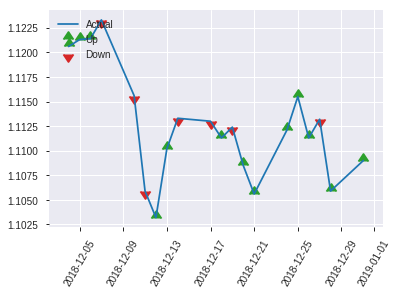


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15626891476033167
RMSE: 0.3953086322866371
LogLoss: 0.4744561068631483
Null degrees of freedom: 255
Residual degrees of freedom: 235
Null deviance: 354.73288115002356
Residual deviance: 242.92152671393194
AIC: 284.92152671393194
AUC: 0.8632557002261753
pr_auc: 0.8590153891950363
Gini: 0.7265114004523505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4658901641306431: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   35   0.2846   (35.0/123.0)
1      14   119  0.1053   (14.0/133.0)
Total  102  154  0.1914   (49.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46589      0.829268  153
max f2                       0.35554      0.887656  188
max f0point5                 0.573873     0.802139  106
max accuracy                 0.472889     0.808594  149
max precision                0.982601     1         0
max recall                   0.0439969    1         232
max specificity              0.982601     1         0
max absolute_mcc             0.46589      0.6227    153
max min_per_class_accuracy   0.526592     0.759398  128
max mean_per_class_accuracy  0.472889     0.805703  149

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.09 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.978386           1.92481    1.92481            1                0.981377   1                           0.981377            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.949591           1.92481    1.92481            1                0.95991    1                           0.970643            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.947125           1.92481    1.92481            1                0.948424   1                           0.965088            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.931978           1.92481    1.92481            1                0.938431   1                           0.957818            0.0225564       0.0827068                  92.4812   92.4812
    5        0.0507812                   0.927544           1.92481    1.92481            1                0.929967   1                           0.953533            0.0150376       0.0977444                  92.4812   92.4812
    6        0.101562                    0.867987           1.77675    1.85078            0.923077         0.893602   0.961538                    0.923567            0.0902256       0.18797                    77.675    85.0781
    7        0.152344                    0.780183           1.77675    1.8261             0.923077         0.813553   0.948718                    0.886896            0.0902256       0.278195                   77.675    82.6104
    8        0.203125                    0.738088           1.48062    1.73973            0.769231         0.762338   0.903846                    0.855757            0.075188        0.353383                   48.0625   73.9734
    9        0.300781                    0.649607           1.61684    1.69983            0.84             0.683873   0.883117                    0.79995             0.157895        0.511278                   61.6842   69.9834
    10       0.402344                    0.582768           1.33256    1.60712            0.692308         0.616648   0.834951                    0.75368             0.135338        0.646617                   33.2562   60.7125
    11       0.5                         0.526692           1.07789    1.50376            0.56             0.551435   0.78125                     0.714179            0.105263        0.75188                    7.78947   50.3759
    12       0.601562                    0.46589            1.40659    1.48735            0.730769         0.497202   0.772727                    0.677546            0.142857        0.894737                   40.6593   48.7355
    13       0.699219                    0.386726           0.384962   1.33339            0.2              0.426894   0.692737                    0.642539            0.037594        0.932331                   -61.5038  33.3389
    14       0.800781                    0.277794           0.444187   1.22061            0.230769         0.330652   0.634146                    0.602983            0.0451128       0.977444                   -55.5813  22.0613
    15       0.898438                    0.0469826          0.153985   1.10467            0.08             0.156786   0.573913                    0.554483            0.0150376       0.992481                   -84.6015  10.4675
    16       1                           0.00238948         0.0740312  1                  0.0384615        0.0270084  0.519531 

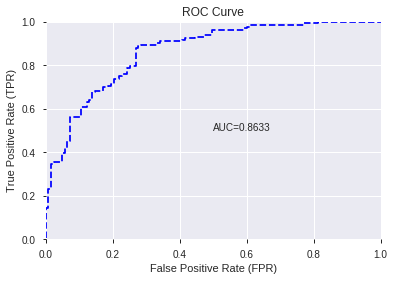

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


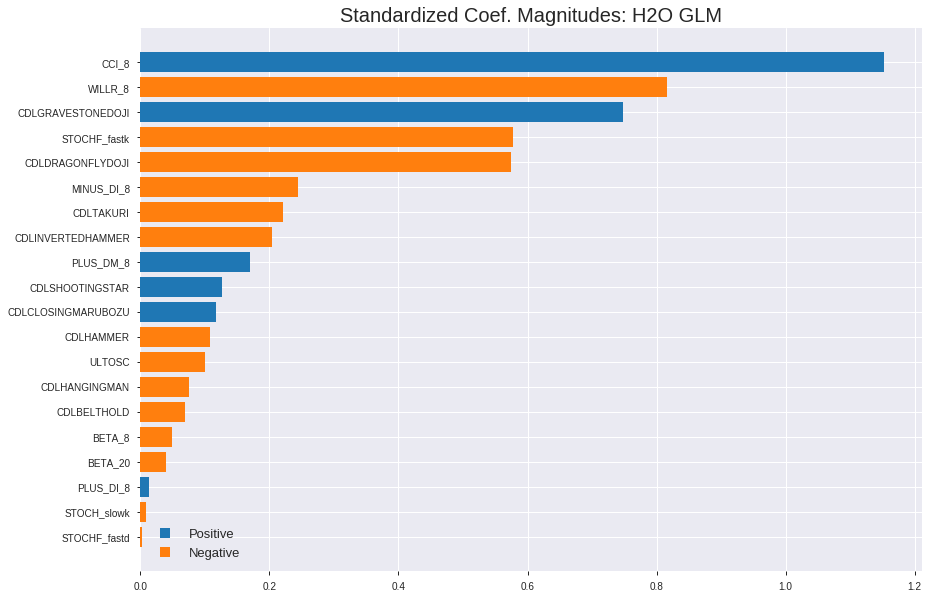

'log_likelihood'
--2019-08-22 16:39:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


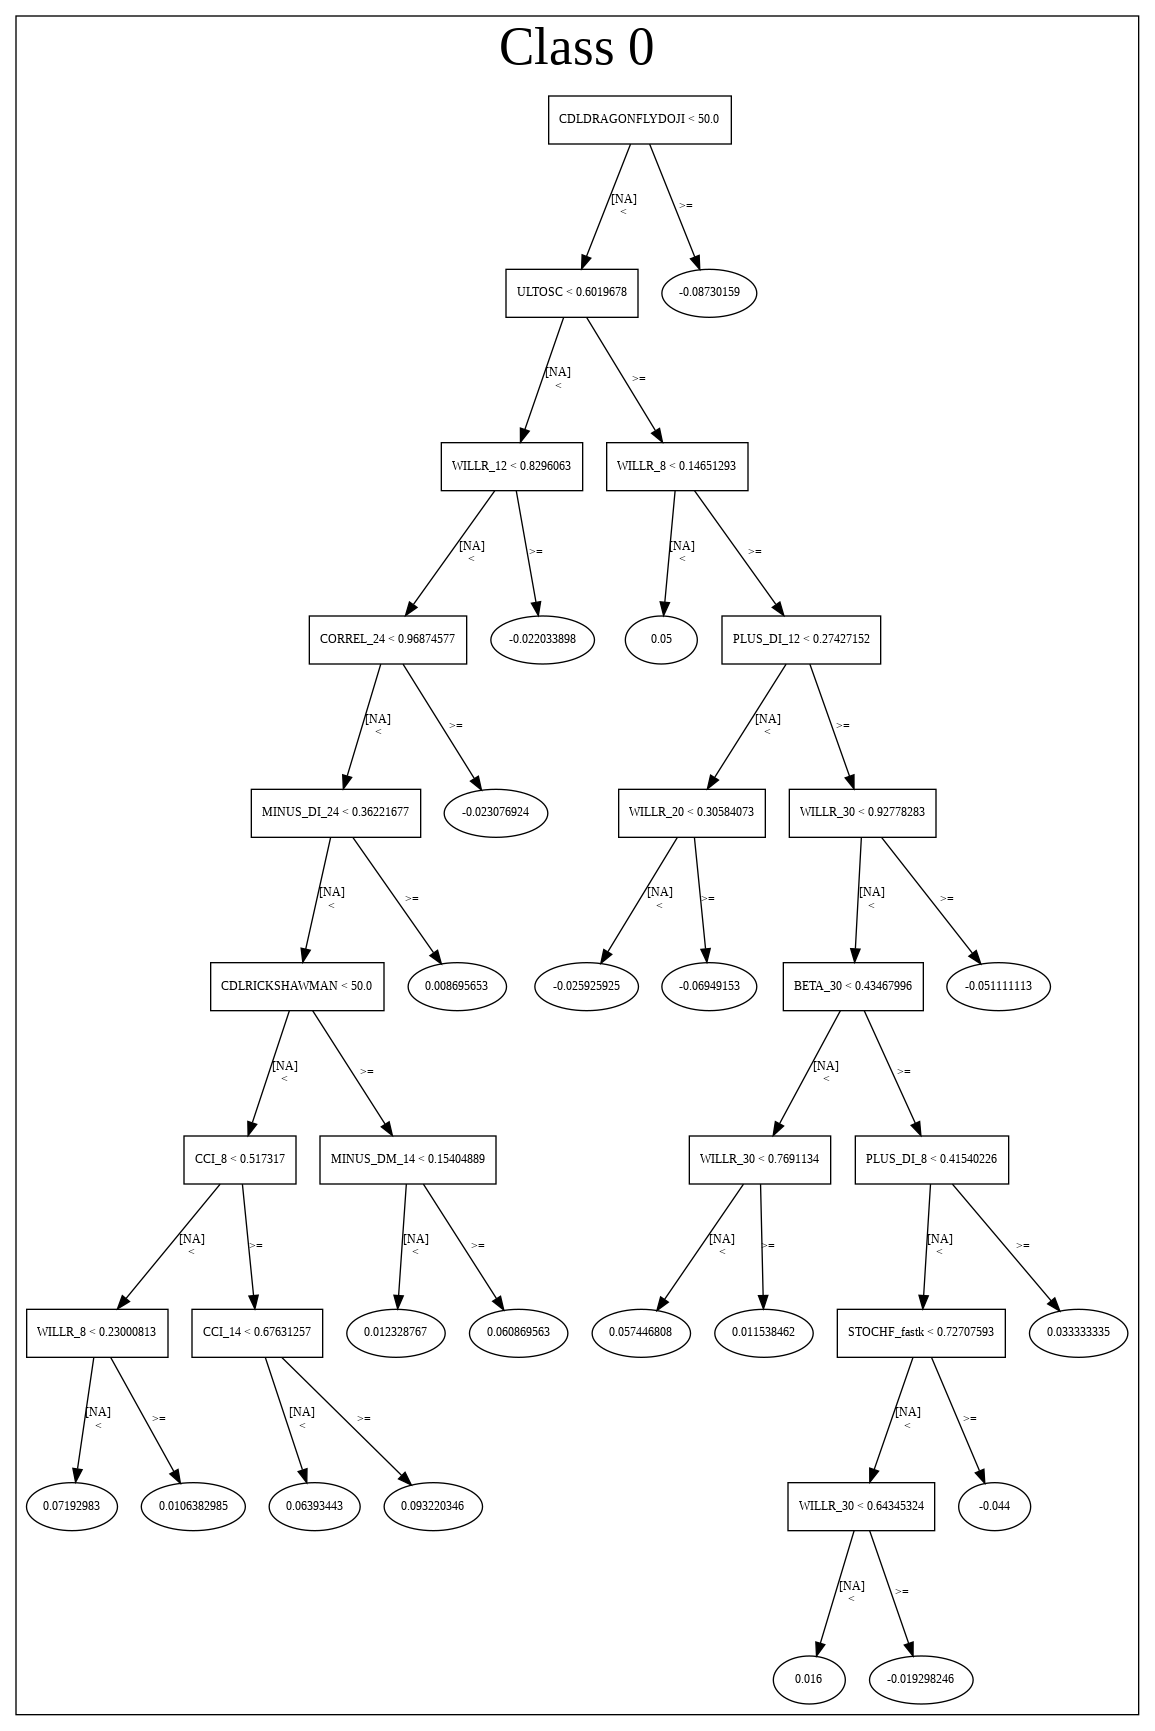

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_163935_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_163935_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CCI_8',
 'WILLR_8',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'MINUS_DI_8',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'PLUS_DM_8',
 'CDLSHOOTINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'ULTOSC',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'BETA_8',
 'BETA_20',
 'PLUS_DI_8',
 'STOCH_slowk',
 'STOCHF_fastd']

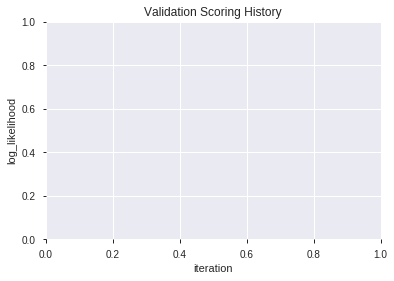

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_163946_model_4  0.837337  0.502251              0.230271  0.407613  0.166149
1  XGBoost_grid_1_AutoML_20190822_163946_model_3  0.834709  0.494933              0.236261  0.406675  0.165385
2               XGBoost_3_AutoML_20190822_163946  0.832691  0.495696              0.248365  0.407434  0.166002
3  XGBoost_grid_1_AutoML_20190822_163946_model_2  0.831958  0.497808              0.247448  0.408076  0.166526
4               XGBoost_1_AutoML_20190822_163946  0.830185  0.502517              0.269607  0.409994  0.168095
5  XGBoost_grid_1_AutoML_20190822_163946_model_6  0.826884  0.504546              0.250902  0.411625  0.169435
6               XGBoost_2_AutoML_20190822_163946  0.824867  0.506991              0.250596  0.411635  0.169444
7  XGBoost_grid_1_AutoML_20190822_163946_model_1  0.824623  0.504211              0.250290  0.412128  0.169849
8  XGBoost_grid_1_AutoML_20190822_163946_model_7  0.821811  0.511090              0.235650  0.414273  0.171622
9  XGBoost_grid_1_AutoML_20190822_163946_model_5  0.818571  0.520859              0.235956  0.418990  0.175553

variable  relative_importance  scaled_importance  percentage
0   CDLGRAVESTONEDOJI           903.210022           1.000000    0.150772
1    CDLDRAGONFLYDOJI           851.150391           0.942362    0.142082
2               CCI_8           837.623352           0.927385    0.139824
3        STOCHF_fastk           632.502991           0.700283    0.105583
4             WILLR_8           525.731323           0.582070    0.087760
5              ULTOSC           391.976685           0.433982    0.065432
6           PLUS_DM_8           325.739380           0.360646    0.054375
7         STOCH_slowk           314.588806           0.348301    0.052514
8          MINUS_DI_8           284.735901           0.315249    0.047531
9             BETA_20           274.587616           0.304013    0.045837
10             BETA_8           254.430984           0.281696    0.042472
11          PLUS_DI_8           206.659531           0.228806    0.034498
12          CDLTAKURI           187.625610           0.207732    0.031320

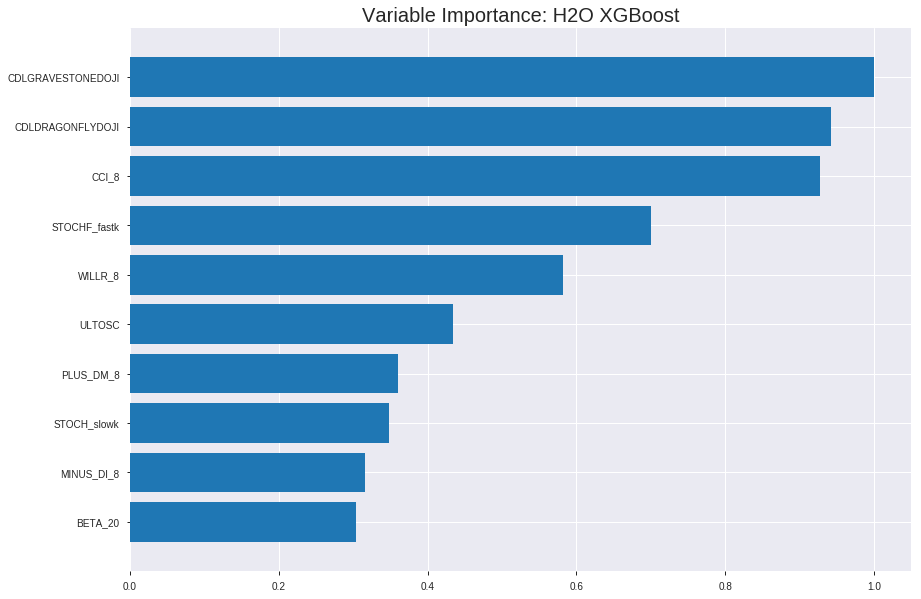

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_163946_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16461339704790992
RMSE: 0.4057257658171464
LogLoss: 0.4991320003497948
Mean Per-Class Error: 0.23688517615732285
AUC: 0.8445334671384883
pr_auc: 0.84775561087594
Gini: 0.6890669342769766
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4280678927898407: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      573  313   0.3533   (313.0/886.0)
1      141  761   0.1563   (141.0/902.0)
Total  714  1074  0.2539   (454.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428068     0.770243  237
max f2                       0.308781     0.868035  293
max f0point5                 0.585089     0.775431  156
max accuracy                 0.521695     0.762864  189
max precision                0.943546     1         0
max recall                   0.118965     1         374
max specificity              0.943546     1         0
max absolute_mcc             0.521695     0.526907  189
max min_per_class_accuracy   0.497015     0.756098  201
max mean_per_class_accuracy  0.521695     0.763115  189

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.920368           1.98226    1.98226            1                0.929425  1                           0.929425            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.904692           1.98226    1.98226            1                0.911335  1                           0.92038             0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.896327           1.98226    1.98226            1                0.900545  1                           0.913768            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.889025           1.87214    1.95473            0.944444         0.892452  0.986111                    0.908439            0.018847        0.078714                   87.2136   95.473
    5        0.0503356                   0.883627           1.98226    1.96024            1                0.886184  0.988889                    0.903988            0.0199557       0.0986696                  98.2262   96.0237
    6        0.100112                    0.849467           1.82635    1.89367            0.921348         0.866448  0.955307                    0.885323            0.0909091       0.189579                   82.6353   89.3669
    7        0.150447                    0.796973           1.82809    1.87173            0.922222         0.822746  0.944238                    0.864386            0.0920177       0.281596                   82.8086   87.1727
    8        0.200224                    0.741752           1.80408    1.85491            0.910112         0.769059  0.935754                    0.840688            0.0898004       0.371397                   80.4081   85.491
    9        0.300336                    0.648339           1.42856    1.71279            0.72067          0.694099  0.86406                     0.791825            0.143016        0.514412                   42.8557   71.2792
    10       0.399888                    0.570999           1.26954    1.60244            0.640449         0.606931  0.808392                    0.745795            0.126386        0.640798                   26.9538   60.2444
    11       0.5                         0.496911           1.15171    1.5122             0.581006         0.536384  0.762864                    0.703866            0.115299        0.756098                   15.1705   51.2195
    12       0.600112                    0.427752           0.874853   1.40587            0.441341         0.460967  0.709226                    0.663345            0.0875831       0.843681                   -12.5147  40.5872
    13       0.699664                    0.35615            0.679314   1.30249            0.342697         0.393592  0.657074                    0.624963            0.0676275       0.911308                   -32.0686  30.2493
    14       0.799776                    0.280766           0.564778   1.21015            0.284916         0.318416  0.61049                     0.586591            0.056541        0.967849                   -43.5222  21.015
    15       0.899888                    0.163071           0.265778   1.10509            0.134078         0.223587  0.557489                    0.546207            0.0266075       0.994457                   -73.4222  10.5089
    16       1                           0.0562105          0.0553704  1                  0.027933         0.11667   0.504474                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1637305797667653
RMSE: 0.40463635497414874
LogLoss: 0.4970842771078895
Mean Per-Class Error: 0.2393286143286143
AUC: 0.8436063614635043
pr_auc: 0.833541621540231
Gini: 0.6872127229270086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39024215936660767: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      171  88   0.3398   (88.0/259.0)
1      35   217  0.1389   (35.0/252.0)
Total  206  305  0.2407   (123.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390242     0.779174  248
max f2                       0.216416     0.863893  327
max f0point5                 0.568879     0.784884  161
max accuracy                 0.568879     0.759295  161
max precision                0.935906     1         0
max recall                   0.136873     1         367
max specificity              0.935906     1         0
max absolute_mcc             0.390242     0.531361  248
max min_per_class_accuracy   0.457671     0.756757  210
max mean_per_class_accuracy  0.390242     0.760671  248

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 47.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.925776           2.02778    2.02778            1                0.93124   1                           0.93124             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.907544           2.02778    2.02778            1                0.914141  1                           0.923468            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.89918            1.62222    1.90104            0.8              0.903075  0.9375                      0.917095            0.015873        0.0595238                  62.2222   90.1042
    4        0.0410959                   0.888652           2.02778    1.93122            1                0.893817  0.952381                    0.911553            0.0198413       0.0793651                  102.778   93.1217
    5        0.0508806                   0.880161           2.02778    1.94979            1                0.883497  0.961538                    0.906158            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.845344           1.7938     1.87179            0.884615         0.86234   0.923077                    0.884249            0.0912698       0.190476                   79.3803   87.1795
    7        0.150685                    0.79035            1.86556    1.86977            0.92             0.820156  0.922078                    0.863439            0.0912698       0.281746                   86.5556   86.9769
    8        0.201566                    0.744461           1.7938     1.85059            0.884615         0.767165  0.912621                    0.839137            0.0912698       0.373016                   79.3803   85.0593
    9        0.30137                     0.656409           1.55065    1.75126            0.764706         0.703525  0.863636                    0.794227            0.154762        0.527778                   55.0654   75.1263
    10       0.401174                    0.552085           1.27233    1.63211            0.627451         0.600388  0.804878                    0.746003            0.126984        0.654762                   27.2331   63.2114
    11       0.500978                    0.453593           1.03377    1.51291            0.509804         0.50181   0.746094                    0.697356            0.103175        0.757937                   3.37691   51.2912
    12       0.600783                    0.389258           1.03377    1.43332            0.509804         0.419992  0.70684                     0.651279            0.103175        0.861111                   3.37691   43.3315
    13       0.700587                    0.299584           0.636166   1.31975            0.313725         0.344377  0.650838                    0.607558            0.0634921       0.924603                   -36.3834  31.9755
    14       0.800391                    0.216535           0.437364   1.20973            0.215686         0.254151  0.596577                    0.56349             0.0436508       0.968254                   -56.2636  20.9726
    15       0.900196                    0.1412             0.278322   1.10646            0.137255         0.180481  0.545652                    0.521026            0.0277778       0.996032                   -72.1678  10.6461
    16       1                           0.0735309          0.0397603  1                  0.0196078        0.107987  0.493151                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:39:54  3.522 sec   0                  0.5              0.693147            0.5             0                  1                0.495526                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-08-22 16:39:54  3.566 sec   5                  0.477558         0.648878            0.781171        0.585373           1.80461          0.342841                         0.472382           0.638911              0.80875           0.578686             1.93273            0.287671
    2019-08-22 16:39:54  3.599 sec   10                 0.462351         0.618679            0.792353        0.596047           1.80461          0.322148                         0.453161           0.601105              0.818234          0.585361             1.93273            0.287671
    2019-08-22 16:39:54  3.633 sec   15                 0.451512         0.596671            0.804468        0.765263           1.93391          0.308166                         0.439859           0.574317              0.828201          0.772938             1.89259            0.283757
    2019-08-22 16:39:54  3.667 sec   20                 0.443146         0.579281            0.809425        0.769328           1.93391          0.299217                         0.430177           0.554228              0.831372          0.77432              1.89259            0.25636
    2019-08-22 16:39:54  3.712 sec   25                 0.437528         0.567165            0.812077        0.812985           1.98226          0.294183                         0.424629           0.542065              0.832092          0.810624             1.57716            0.258317
    2019-08-22 16:39:54  3.764 sec   30                 0.43273          0.557051            0.815408        0.81538            1.98226          0.291387                         0.41942            0.531243              0.837562          0.825141             2.02778            0.246575
    2019-08-22 16:39:54  3.816 sec   35                 0.428883         0.549001            0.820034        0.821451           1.98226          0.28915                          0.417404           0.526501              0.836229          0.825755             2.02778            0.248532
    2019-08-22 16:39:54  3.863 sec   40                 0.425724         0.542159            0.821825        0.824286           1.98226          0.291387                         0.415192           0.521631              0.836934          0.822068             2.02778            0.260274
    2019-08-22 16:39:54  3.914 sec   45                 0.422006         0.534201            0.825201        0.826477           1.98226          0.285235                         0.412126           0.515059              0.839554          0.828469             2.02778            0.260274
    2019-08-22 16:39:54  3.969 sec   50                 0.419463         0.528816            0.827854        0.829539           1.98226          0.286353                         0.410604           0.511635              0.840833          0.829244             2.02778            0.25636
    2019-08-22 16:39:54  4.044 sec   55                 0.417341         0.524247            0.829905        0.830542           1.98226          0.26566                          0.409803           0.509406              0.840458          0.8

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI  903.21                 1                    0.150772
CDLDRAGONFLYDOJI   851.15                 0.942362             0.142082
CCI_8              837.623                0.927385             0.139824
STOCHF_fastk       632.503                0.700283             0.105583
WILLR_8            525.731                0.58207              0.0877599
ULTOSC             391.977                0.433982             0.0654324
PLUS_DM_8          325.739                0.360646             0.0543754
STOCH_slowk        314.589                0.348301             0.0525141
MINUS_DI_8         284.736                0.315249             0.0475307
BETA_20            274.588                0.304013             0.0458367
BETA_8             254.431                0.281696             0.042472
PLUS_DI_8          206.66                 0.228806             0.0344975
CDLTAKURI          187.626                0.207732             0.0313202

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.798611111111111)

('auc', 0.8373372455529067)

('logloss', 0.5022510514859997)

('mean_per_class_error', 0.22904823033192745)

('rmse', 0.40761318796200807)

('mse', 0.16614851100055134)

xgboost prediction progress: |████████████████████████████████████████████| 100%


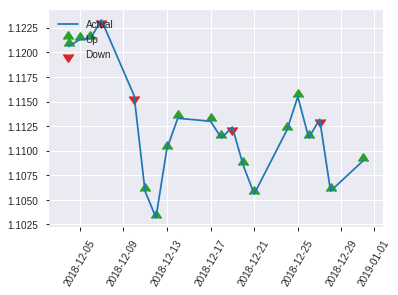


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16614851100055134
RMSE: 0.40761318796200807
LogLoss: 0.5022510514859997
Mean Per-Class Error: 0.22904823033192745
AUC: 0.8373372455529067
pr_auc: 0.8310675008047872
Gini: 0.6746744911058133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42753326892852783: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      83   40   0.3252   (40.0/123.0)
1      18   115  0.1353   (18.0/133.0)
Total  101  155  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427533     0.798611  153
max f2                       0.220682     0.883941  207
max f0point5                 0.512819     0.782946  126
max accuracy                 0.452192     0.773438  145
max precision                0.922136     1         0
max recall                   0.119129     1         230
max specificity              0.922136     1         0
max absolute_mcc             0.427533     0.551455  153
max min_per_class_accuracy   0.505431     0.764228  129
max mean_per_class_accuracy  0.452192     0.770952  145

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.913708           1.92481    1.92481            1                0.918824   1                           0.918824            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.909764           1.92481    1.92481            1                0.910902   1                           0.914863            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.896971           1.92481    1.92481            1                0.904618   1                           0.912302            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.882389           1.92481    1.92481            1                0.888966   1                           0.905937            0.0225564       0.0827068                  92.4812   92.4812
    5        0.0507812                   0.880021           1.92481    1.92481            1                0.881651   1                           0.902201            0.0150376       0.0977444                  92.4812   92.4812
    6        0.101562                    0.831745           1.62869    1.77675            0.846154         0.85886    0.923077                    0.880531            0.0827068       0.180451                   62.8687   77.675
    7        0.152344                    0.797394           1.62869    1.7274             0.846154         0.816077   0.897436                    0.859046            0.0827068       0.263158                   62.8687   72.7395
    8        0.203125                    0.757147           1.77675    1.73973            0.923077         0.779492   0.903846                    0.839158            0.0902256       0.353383                   77.675    73.9734
    9        0.300781                    0.689574           1.38586    1.62484            0.72             0.723244   0.844156                    0.801523            0.135338        0.488722                   38.5865   62.4841
    10       0.402344                    0.608656           1.1845     1.51369            0.615385         0.65339    0.786408                    0.764131            0.120301        0.609023                   18.45     51.3687
    11       0.5                         0.509358           1.53985    1.5188             0.8              0.563256   0.789062                    0.724897            0.150376        0.759398                   53.985    51.8797
    12       0.601562                    0.429992           0.962406   1.42486            0.5              0.46583    0.74026                     0.681159            0.0977444       0.857143                   -3.7594   42.4861
    13       0.699219                    0.363407           0.692932   1.32264            0.36             0.3999     0.687151                    0.641877            0.0676692       0.924812                   -30.7068  32.2636
    14       0.800781                    0.244711           0.370156   1.20183            0.192308         0.323383   0.62439                     0.601483            0.037594        0.962406                   -62.9844  20.1834
    15       0.898438                    0.12176            0.30797    1.10467            0.16             0.1706     0.573913                    0.554648            0.0300752       0.992481                   -69.203   10.4675
    16       1                           0.0609261          0.0740312  1                  0.0384615        0.0970494  0.519531  

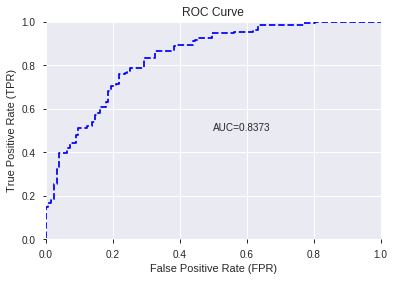

This function is available for GLM models only


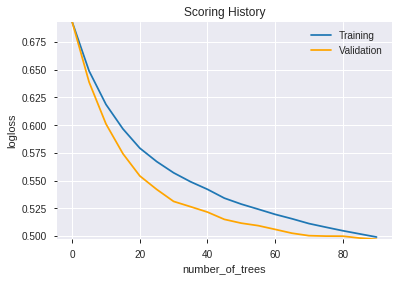

--2019-08-22 16:40:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

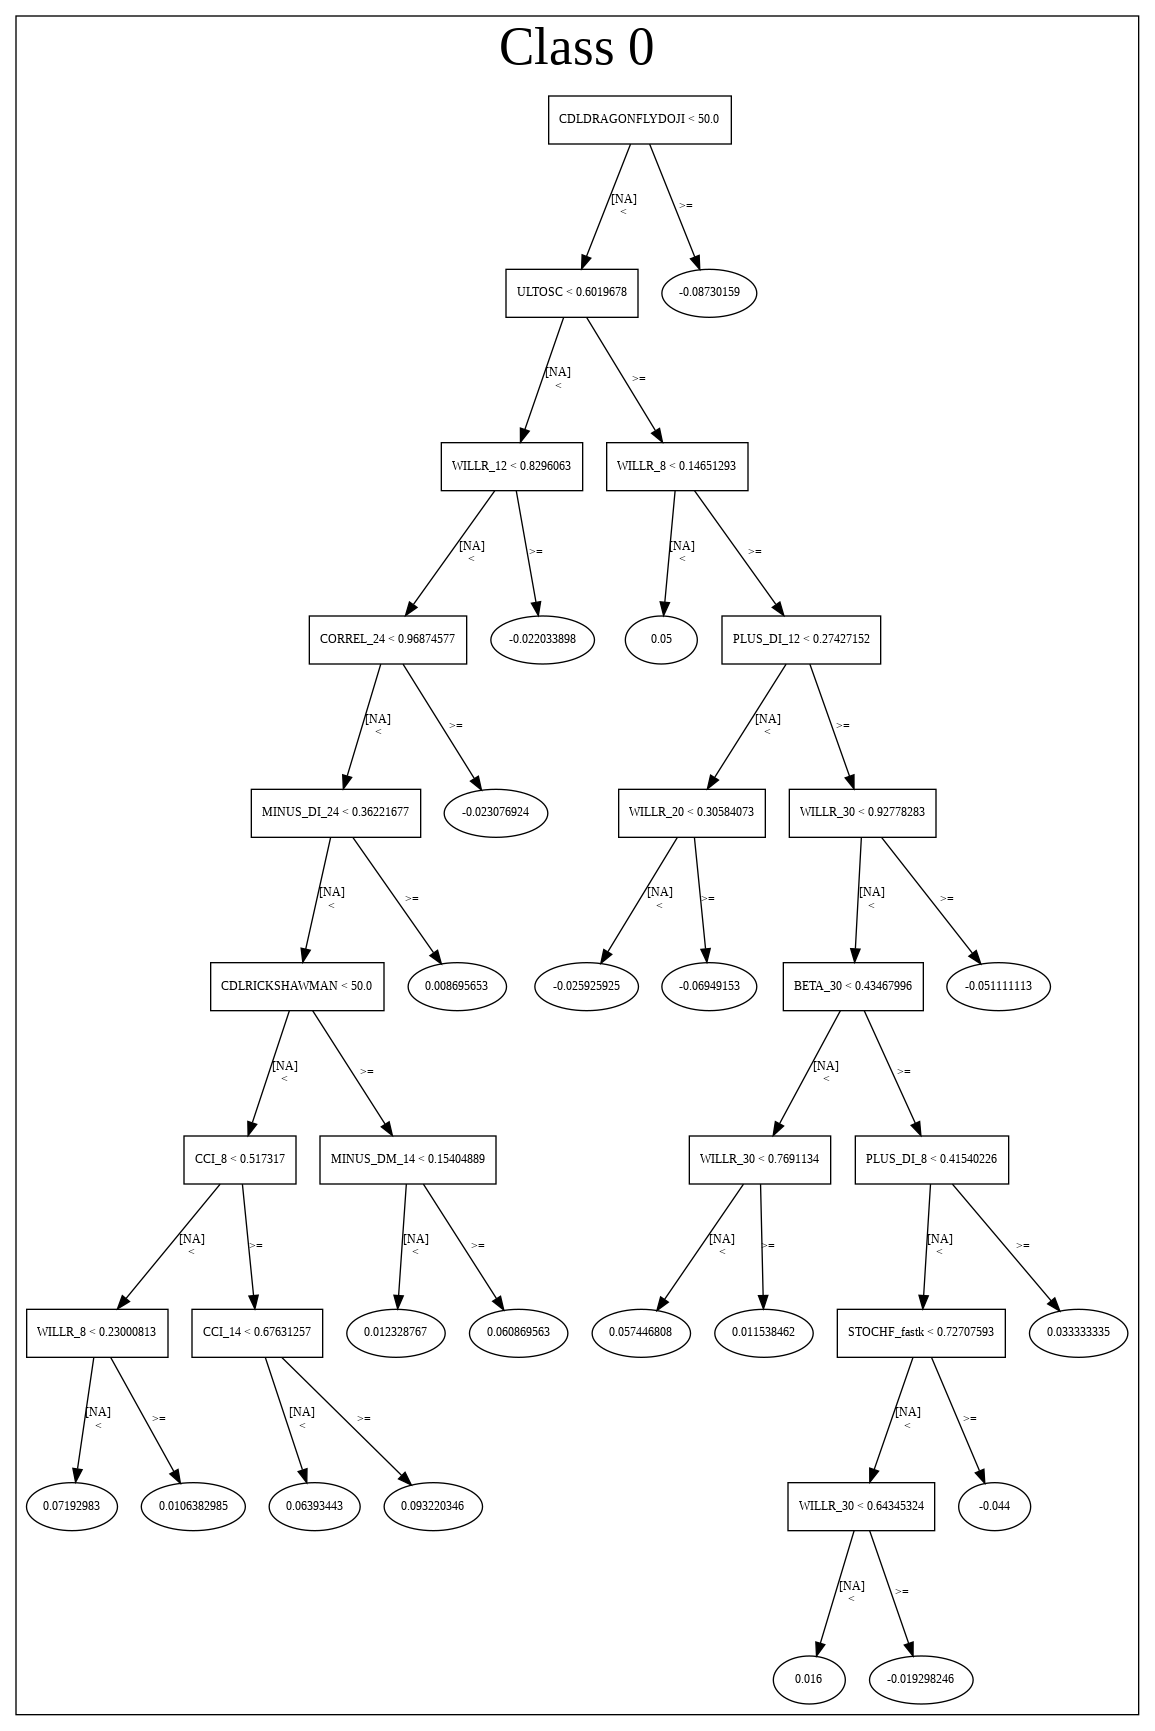

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_163946_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_163946_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'STOCHF_fastk',
 'WILLR_8',
 'ULTOSC',
 'PLUS_DM_8',
 'STOCH_slowk',
 'MINUS_DI_8',
 'BETA_20',
 'BETA_8',
 'PLUS_DI_8',
 'CDLTAKURI']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

71

['BBANDS_upperband_14_5_2',
 'WMA_20',
 'MAVP_20_1',
 'BBANDS_upperband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_3_3',
 'BBANDS_middleband_20_6_5',
 'BBANDS_lowerband_24_3_3',
 'BBANDS_lowerband_30_0_5',
 'BOP',
 'AROONOSC_8',
 'CMO_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROCP_8',
 'CCI_12',
 'MOM_12',
 'ROC_12',
 'ROCR_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CMO_14',
 'DX_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR100_14',
 'aroonup_20',
 'AROONOSC_20',
 'CCI_20',
 'DX_20',
 'MACDFIX_hist_20',
 'MINUS_DI_20',
 'PLUS_DM_20',
 'ROC_20',
 'ROCP_20',
 'aroonup_24',
 'PLUS_DM_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'AROONOSC_30',
 'ROCR_30',
 'RSI_30',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'ULTOSC',
 'NATR_8',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLGRAVESTONEDOJI',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLRICKSHAWMAN',
 'CDLSPINNINGTOP',
 'CDLTAKURI',
 'BETA_8',
 'CORREL_8',
 'L

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_164124_model_7  0.813558  0.585354              0.271838  0.428486  0.183600
1  DeepLearning_grid_1_AutoML_20190822_164124_model_9  0.810380  0.520629              0.248670  0.415423  0.172577
2               DeepLearning_1_AutoML_20190822_164124  0.808974  0.538321              0.253133  0.424140  0.179894
3  DeepLearning_grid_1_AutoML_20190822_164124_model_8  0.806162  0.543050              0.263708  0.420849  0.177114
4  DeepLearning_grid_1_AutoML_20190822_164124_model_3  0.790329  0.627984              0.319610  0.447638  0.200380
5  DeepLearning_grid_1_AutoML_20190822_164124_model_6  0.789351  0.558517              0.282108  0.430389  0.185234
6  DeepLearning_grid_1_AutoML_20190822_164124_model_5  0.788343  0.586744              0.298674  0.434729  0.188989
7  DeepLearning_grid_1_AutoML_20190822_164124_model_1  0.766978  0.959172              0.338407  0.504020  0.254036
8  DeepLearning_grid_1_AutoML_20190822_164124_model_2  0.745400  0.826205              0.331499  0.479879  0.230284
9  DeepLearning_grid_1_AutoML_20190822_164124_model_4  0.743016  0.820567              0.375604  0.502953  0.252962

variable  relative_importance  scaled_importance  percentage
0          CDLGRAVESTONEDOJI             1.000000           1.000000    0.018142
1                  CDLTAKURI             0.975094           0.975094    0.017690
2             CDLRICKSHAWMAN             0.896773           0.896773    0.016269
3                     ULTOSC             0.865682           0.865682    0.015705
4                 MINUS_DI_8             0.860567           0.860567    0.015612
..                       ...                  ...                ...         ...
66      HT_PHASOR_quadrature             0.728257           0.728257    0.013212
67                 MAVP_20_1             0.726816           0.726816    0.013186
68  BBANDS_middleband_20_6_5             0.726188           0.726188    0.013175
69                    MOM_12             0.720348           0.720348    0.013069
70   BBANDS_upperband_20_1_3             0.708259           0.708259    0.012849

[71 rows x 4 columns]

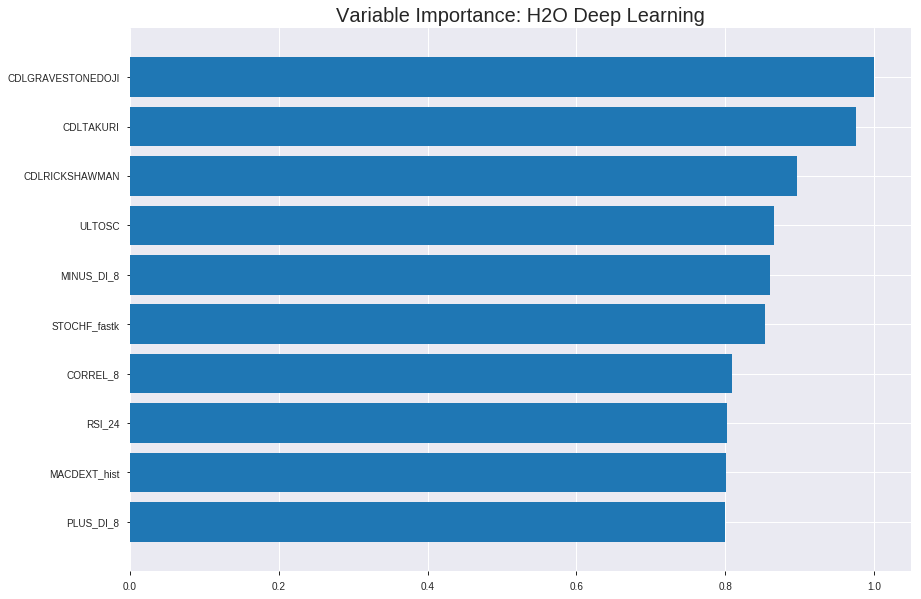

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_164124_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15331299250760502
RMSE: 0.39155203039647873
LogLoss: 0.45407218784521813
Mean Per-Class Error: 0.2164953226589521
AUC: 0.8720819798491438
pr_auc: 0.8349845626986505
Gini: 0.7441639596982876
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2954052178992975: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      614  272   0.307    (272.0/886.0)
1      125  777   0.1386   (125.0/902.0)
Total  739  1049  0.222    (397.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.295405     0.796515  262
max f2                       0.137353     0.883417  334
max f0point5                 0.568865     0.797347  151
max accuracy                 0.361753     0.783557  234
max precision                0.999854     1         0
max recall                   0.000773202  1         398
max specificity              0.999854     1         0
max absolute_mcc             0.361753     0.567066  234
max min_per_class_accuracy   0.365859     0.781038  232
max mean_per_class_accuracy  0.361753     0.783505  234

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 43.58 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.999887           1.98226    1.98226            1                0.999952    1                           0.999952            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.999649           1.98226    1.98226            1                0.999793    1                           0.999873            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.999203           1.98226    1.98226            1                0.999415    1                           0.99972             0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.998533           1.98226    1.98226            1                0.998885    1                           0.999511            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.997712           1.98226    1.98226            1                0.998128    1                           0.999235            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.976423           1.95999    1.97119            0.988764         0.990221    0.994413                    0.994753            0.097561        0.197339                   95.9989   97.1188
    7        0.150447                    0.918597           1.87214    1.93805            0.944444         0.951655    0.977695                    0.980334            0.094235        0.291574                   87.2136   93.8048
    8        0.200224                    0.82231            1.75954    1.89367            0.88764          0.870013    0.955307                    0.952908            0.0875831       0.379157                   75.9536   89.3669
    9        0.300336                    0.620232           1.5393     1.77555            0.776536         0.718824    0.895717                    0.87488             0.154102        0.533259                   53.9298   77.5545
    10       0.399888                    0.478174           1.23613    1.64126            0.623596         0.541733    0.827972                    0.791942            0.12306         0.656319                   23.6129   64.1257
    11       0.5                         0.36768            1.20708    1.55432            0.608939         0.422915    0.784116                    0.718054            0.120843        0.777162                   20.7076   55.4324
    12       0.600112                    0.281813           0.919149   1.44836            0.463687         0.325471    0.730662                    0.652563            0.0920177       0.86918                    -8.08507  44.8363
    13       0.699664                    0.196833           0.634769   1.3326             0.320225         0.240405    0.672262                    0.593919            0.0631929       0.932373                   -36.5231  33.26
    14       0.799776                    0.099022           0.531556   1.23233            0.268156         0.149792    0.621678                    0.538325            0.0532151       0.985588                   -46.8444  23.2329
    15       0.899888                    0.0105039          0.132889   1.11002            0.0670391        0.0506565   0.559975                    0.484072            0.0133038       0.998891                   -86.7111  11.0017
    16       1                           1.30527e-07        0.0110741  1                  0.00558659       0.001



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17383278431002555
RMSE: 0.41693258964732605
LogLoss: 0.5236556193424239
Mean Per-Class Error: 0.26136851136851136
AUC: 0.829656186799044
pr_auc: 0.8306212080743459
Gini: 0.6593123735980879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15094204818621895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  140  0.5405   (140.0/259.0)
1      15   237  0.0595   (15.0/252.0)
Total  134  377  0.3033   (155.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.150942     0.753577  316
max f2                       0.0863797    0.870331  345
max f0point5                 0.606209     0.776869  121
max accuracy                 0.41948      0.739726  179
max precision                0.999992     1         0
max recall                   0.000130262  1         398
max specificity              0.999992     1         0
max absolute_mcc             0.56974      0.502215  130
max min_per_class_accuracy   0.368187     0.718147  212
max mean_per_class_accuracy  0.41948      0.738631  179

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 42.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.999859           2.02778    2.02778            1                0.999938     1                           0.999938            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.999502           2.02778    2.02778            1                0.999607     1                           0.999788            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.999329           2.02778    2.02778            1                0.99942      1                           0.999673            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.998835           2.02778    2.02778            1                0.999042     1                           0.999522            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.996499           2.02778    2.02778            1                0.997826     1                           0.999196            0.0198413       0.103175                   102.778   102.778
    6        0.101761                    0.968003           1.94979    1.98878            0.961538         0.98618      0.980769                    0.992688            0.0992063       0.202381                   94.9786   98.8782
    7        0.150685                    0.88799            1.94667    1.97511            0.96             0.929951     0.974026                    0.972319            0.0952381       0.297619                   94.6667   97.5108
    8        0.201566                    0.820762           1.71581    1.90965            0.846154         0.846877     0.941748                    0.940654            0.0873016       0.384921                   71.5812   90.9655
    9        0.30137                     0.600886           1.47113    1.76443            0.72549          0.691024     0.87013                     0.857984            0.146825        0.531746                   47.1133   76.443
    10       0.401174                    0.444995           1.03377    1.58266            0.509804         0.50534      0.780488                    0.770253            0.103175        0.634921                   3.37691   58.2656
    11       0.500978                    0.362875           0.914488   1.44954            0.45098          0.397745     0.714844                    0.696043            0.0912698       0.72619                    -8.5512   44.9544
    12       0.600783                    0.269954           0.954248   1.36726            0.470588         0.318349     0.674267                    0.633299            0.0952381       0.821429                   -4.57516  36.7264
    13       0.700587                    0.188408           0.795207   1.28577            0.392157         0.226766     0.634078                    0.575385            0.0793651       0.900794                   -20.4793  28.577
    14       0.800391                    0.0886812          0.715686   1.21468            0.352941         0.138042     0.599022                    0.520851            0.0714286       0.972222                   -28.4314  21.4684
    15       0.900196                    0.00250083         0.198802   1.10205            0.0980392        0.0361697    0.543478                    0.467114            0.0198413       0.992063                   -80.1198  10.2053
    16       1                           5.86329e-08        0.0795207  1                  0.039


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:47:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:47:16  6.802 sec         216 obs/sec       0.655481  1             1172       0.554197         1.16741             -0.228634      0.675673        0.626827           1.87214          0.435682                         0.538316           1.11319               -0.159354        0.698328          0.677612             1.68981            0.41683
    2019-08-22 16:47:31  21.085 sec        387 obs/sec       3.97483   6             7107       0.457834         0.62319             0.161484       0.783118        0.77172            1.98226          0.3283                           0.470254           0.631428              0.115277         0.772546          0.778195             2.02778            0.356164
    2019-08-22 16:47:45  35.395 sec        453 obs/sec       7.94463   12            14205      0.391552         0.454072            0.386699       0.872082        0.834985           1.98226          0.222036                         0.416933           0.523656              0.304538         0.829656          0.830621             2.02778            0.303327
    2019-08-22 16:47:59  49.334 sec        486 obs/sec       11.9323   18            21335      0.36777          0.409211            0.458939       0.912812        0.887146           1.98226          0.181767                         0.441734           0.609041              0.219339         0.812151          0.802089             2.02778            0.313112
    2019-08-22 16:48:15  1 min  5.093 sec  506 obs/sec       16.4916   25            29487      0.344687         0.363258            0.524726       0.921678        0.803009           1.98226          0.180649                         0.455678           0.681638              0.169274         0.805326          0.72513              2.02778            0.315068
    2019-08-22 16:48:28  1 min 18.853 sec  518 obs/sec       20.4815   31            36621      0.297986         0.27885             0.644789       0.955683        0.857461           1.98226          0.11745                          0.460326           0.745959              0.15224          0.80564           0.754059             2.02778            0.32681
    2019-08-22 16:48:43  1 min 34.173 sec  520 obs/sec       24.5162   37            43835      0.363184         0.411499            0.472347       0.969269        0.918648           1.98226          0.0967562                        0.501493           0.99757               -0.00617089      0.801771          0.773007             2.02778            0.320939
    2019-08-22 16:48:45  1 min 35.774 sec  519 obs/sec       24.5162   37            43835      0.391552         0.454072            0.386699       0.872082        0.834985           1.98226          0.222036                         0.416933           0.523656              0.304538         0.829656          0.830621             2.02778            0.303327

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLGRAVESTONEDOJI         1.0                    1.0                  0.018142034193248842
CDLTAKURI                 0.9750943183898926     0.9750943183898926   0.017690194465872104
CDLRICKSHAWMAN            0.8967726826667786     0.8967726826667786   0.016269280672512192
ULTOSC                    0.8656824827194214     0.8656824827194214   0.015705241201992293
MINUS_DI_8                0.8605670928955078     0.8605670928955078   0.015612437624895057
---                       ---                    ---                  ---
HT_PHASOR_quadrature      0.7282574772834778     0.7282574772834778   0.013212072054365996
MAVP_20_1                 0.7268155217170715     0.7268155217170715   0.013185912047175109
BBANDS_middleband_20_6_5  0.7261881232261658     0.7261881232261658   0.013174529762300304
MOM_12                    0.7203476428985596     0.7203476428985596   0.013068571568491874
BBANDS_upperband_20_1_3   0.708258867263794      0.708258867263794    0.012849256587571444


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.74609375)

('F1', 0.7763157894736841)

('auc', 0.8135582859587994)

('logloss', 0.5853535678327524)

('mean_per_class_error', 0.2578091570389388)

('rmse', 0.42848602387608314)

('mse', 0.1836002726571353)

deeplearning prediction progress: |███████████████████████████████████████| 100%


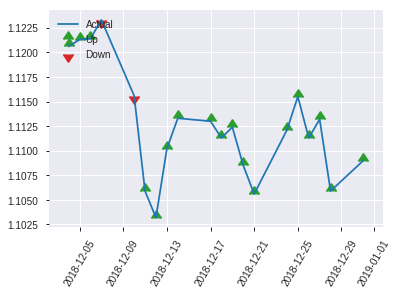


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1836002726571353
RMSE: 0.42848602387608314
LogLoss: 0.5853535678327524
Mean Per-Class Error: 0.2578091570389388
AUC: 0.8135582859587994
pr_auc: 0.8117614907887364
Gini: 0.6271165719175988
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.324584625490158: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   53   0.4309   (53.0/123.0)
1      15   118  0.1128   (15.0/133.0)
Total  85   171  0.2656   (68.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324585     0.776316  170
max f2                       0.133283     0.880376  211
max f0point5                 0.498534     0.745683  125
max accuracy                 0.378793     0.746094  155
max precision                0.999994     1         0
max recall                   5.21595e-05  1         251
max specificity              0.999994     1         0
max absolute_mcc             0.378793     0.496025  155
max min_per_class_accuracy   0.477522     0.729323  129
max mean_per_class_accuracy  0.378793     0.742191  155

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.999893           1.92481    1.92481            1                0.999954     1                           0.999954            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.999713           1.28321    1.60401            0.666667         0.99979      0.833333                    0.999872            0.0150376       0.037594                   28.3208   60.401
    3        0.03125                     0.999386           1.92481    1.68421            1                0.999549     0.875                       0.999791            0.0150376       0.0526316                  92.4812   68.4211
    4        0.0429688                   0.999101           1.92481    1.74983            1                0.999207     0.909091                    0.999632            0.0225564       0.075188                   92.4812   74.9829
    5        0.0507812                   0.998766           1.92481    1.77675            1                0.999034     0.923077                    0.99954             0.0150376       0.0902256                  92.4812   77.675
    6        0.101562                    0.993201           1.92481    1.85078            1                0.996751     0.961538                    0.998145            0.0977444       0.18797                    92.4812   85.0781
    7        0.152344                    0.961401           1.77675    1.8261             0.923077         0.981213     0.948718                    0.992501            0.0902256       0.278195                   77.675    82.6104
    8        0.203125                    0.915979           1.62869    1.77675            0.846154         0.940924     0.923077                    0.979607            0.0827068       0.360902                   62.8687   77.675
    9        0.300781                    0.786959           1.07789    1.54985            0.56             0.850201     0.805195                    0.937592            0.105263        0.466165                   7.78947   54.9849
    10       0.402344                    0.580309           1.25853    1.47631            0.653846         0.688409     0.76699                     0.874691            0.12782         0.593985                   25.8531   47.6312
    11       0.5                         0.488188           1.30887    1.44361            0.68             0.53414      0.75                        0.808177            0.12782         0.721805                   30.8872   44.3609
    12       0.601562                    0.383961           1.03644    1.37487            0.538462         0.43089      0.714286                    0.74448             0.105263        0.827068                   3.64372   37.4866
    13       0.699219                    0.305506           0.692932   1.27962            0.36             0.338275     0.664804                    0.687747            0.0676692       0.894737                   -30.7068  27.9624
    14       0.800781                    0.159085           0.740312   1.21122            0.384615         0.234504     0.629268                    0.630263            0.075188        0.969925                   -25.9688  21.1223
    15       0.898438                    0.00475821         0.230977   1.10467            0.12             0.076079     0.573913                    0.570025            0.0225564       0.992481                   -76.9023  10.4675
    16       1                           7.22772e-07        0.0740312  1                  0.0384

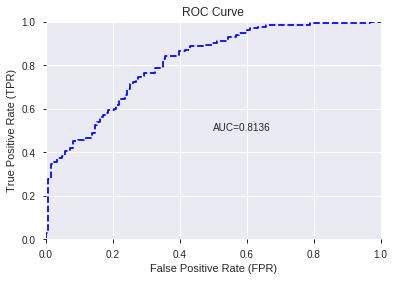

This function is available for GLM models only


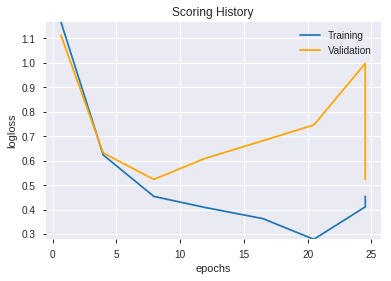

--2019-08-22 16:53:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


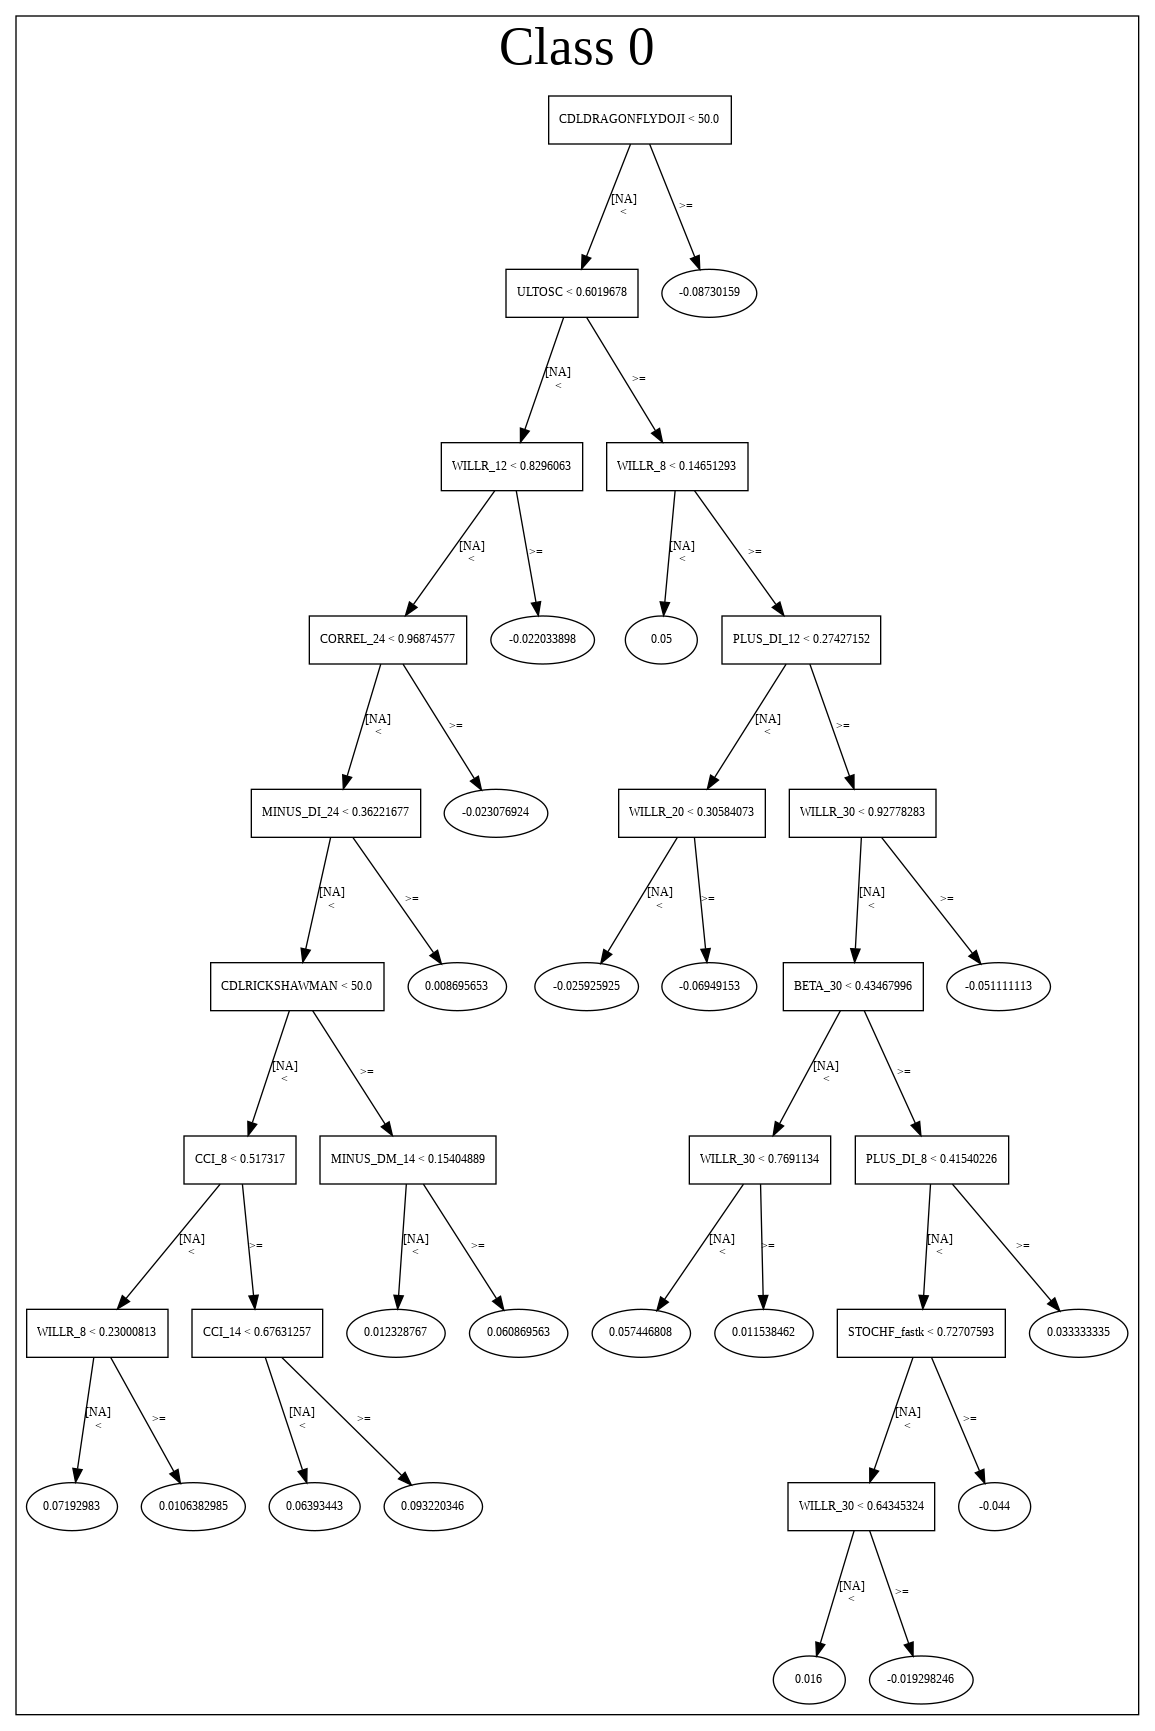

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_164124_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_164124_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CDLRICKSHAWMAN',
 'ULTOSC',
 'MINUS_DI_8',
 'STOCHF_fastk',
 'CORREL_8',
 'RSI_24',
 'MACDEXT_hist',
 'PLUS_DI_8',
 'TRANGE',
 'STOCHF_fastd',
 'AROONOSC_8',
 'PLUS_DM_8',
 'DX_20',
 'CCI_12',
 'PLUS_DI_14',
 'aroonup_24',
 'CCI_20',
 'CDLHIGHWAVE',
 'CORREL_20',
 'BBANDS_middleband_20_3_3',
 'WILLR_12',
 'NATR_8',
 'CDLSPINNINGTOP',
 'DX_14',
 'ROCR100_14',
 'BBANDS_upperband_14_5_2',
 'CORREL_12',
 'MINUS_DI_20',
 'ROCR_30',
 'WILLR_24',
 'PLUS_DM_24',
 'BOP',
 'CMO_8',
 'aroonup_20',
 'ROCP_8',
 'ROC_14',
 'RSI_30',
 'CMO_14',
 'PLUS_DM_20',
 'AROONOSC_30',
 'aroondown_14',
 'BETA_8',
 'BBANDS_lowerband_24_3_3',
 'WMA_20',
 'CDLHIKKAKE',
 'aroonup_14',
 'STDDEV_8',
 'AROONOSC_20',
 'ROC_12',
 'ROCP_20',
 'STOCH_slowk',
 'ROCR_24',
 'LINEARREG_ANGLE_12',
 'BBANDS_upperband_20_1_2',
 'VAR_12',
 'PLUS_DM_14',
 'BBANDS_lowerband_30_0_5',
 'ROCR_12',
 'ROCP_14',
 'LINEARREG_SLOPE_8',
 'ROC_20',
 'PPO',
 'ROCR100_24',
 'MACDFIX_hist_20',
 'HT_PHASOR_q

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_165321_model_1  0.836604  0.499789              0.220307  0.404539  0.163652

variable  relative_importance  scaled_importance  percentage
0       MINUS_DI_8             1.665672           1.000000    0.082012
1           CMO_14             0.968246           0.581294    0.047673
2        PLUS_DI_8             0.792703           0.475906    0.039030
3      MINUS_DI_20             0.785287           0.471453    0.038665
4           CCI_12             0.746148           0.447956    0.036738
..             ...                  ...                ...         ...
66      CDLHIKKAKE             0.018157           0.010901    0.000894
67      PLUS_DM_20             0.018102           0.010868    0.000891
68      ROCR100_14             0.015737           0.009448    0.000775
69      AROONOSC_8             0.013054           0.007837    0.000643
70  CDLRICKSHAWMAN             0.012669           0.007606    0.000624

[71 rows x 4 columns]

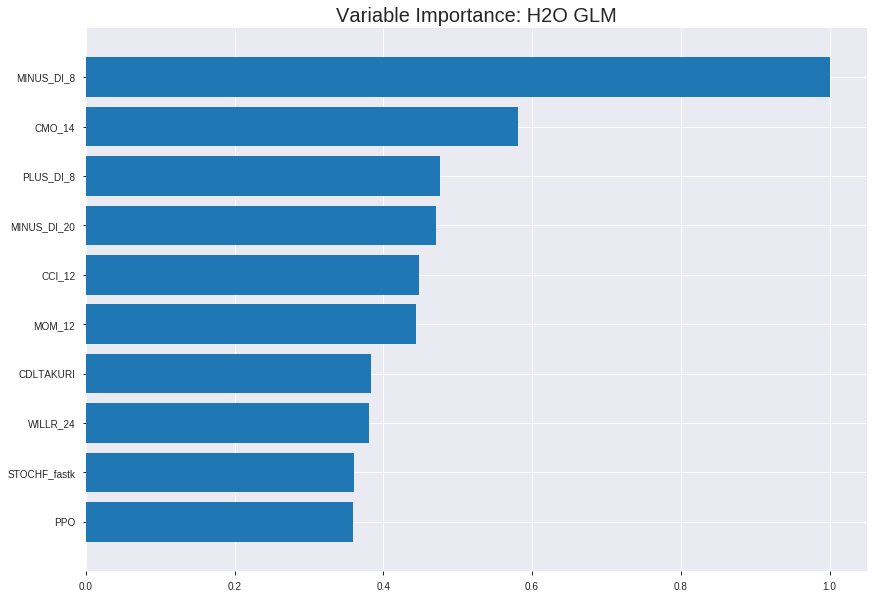

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_165321_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17301820777188365
RMSE: 0.41595457416872295
LogLoss: 0.5137846519628363
Null degrees of freedom: 1787
Residual degrees of freedom: 1716
Null deviance: 2478.551139037676
Residual deviance: 1837.2939154191026
AIC: 1981.2939154191026
AUC: 0.8197184085528522
pr_auc: 0.8185014281959907
Gini: 0.6394368171057043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3509917117369379: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      451  435   0.491    (435.0/886.0)
1      89   813   0.0987   (89.0/902.0)
Total  540  1248  0.2931   (524.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350992     0.756279  264
max f2                       0.162395     0.864618  338
max f0point5                 0.598511     0.76093   151
max accuracy                 0.515889     0.737696  187
max precision                0.997242     1         0
max recall                   0.0429766    1         381
max specificity              0.997242     1         0
max absolute_mcc             0.598511     0.479473  151
max min_per_class_accuracy   0.507764     0.731707  192
max mean_per_class_accuracy  0.515889     0.73786   187

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.977747           1.98226    1.98226            1                0.985829   1                           0.985829            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.971913           1.87214    1.9272             0.944444         0.975096   0.972222                    0.980462            0.018847        0.0388027                  87.2136   92.7199
    3        0.0302013                   0.956463           1.76201    1.87214            0.888889         0.965192   0.944444                    0.975372            0.0177384       0.056541                   76.201    87.2136
    4        0.0402685                   0.950476           1.98226    1.89967            1                0.954252   0.958333                    0.970092            0.0199557       0.0764967                  98.2262   89.9667
    5        0.0503356                   0.94106            1.76201    1.87214            0.888889         0.94677    0.944444                    0.965428            0.0177384       0.094235                   76.201    87.2136
    6        0.100112                    0.900675           1.84863    1.86045            0.932584         0.922257   0.938547                    0.943963            0.0920177       0.186253                   84.8626   86.0447
    7        0.150447                    0.837752           1.67391    1.79804            0.844444         0.869418   0.907063                    0.919022            0.0842572       0.27051                    67.391    79.8037
    8        0.200224                    0.759994           1.64817    1.76078            0.831461         0.803894   0.888268                    0.890401            0.0820399       0.35255                    64.8173   76.078
    9        0.300336                    0.66307            1.495      1.67219            0.75419          0.712712   0.843575                    0.831171            0.149667        0.502217                   49.5002   67.2187
    10       0.399888                    0.583112           1.29181    1.57749            0.651685         0.622805   0.795804                    0.779298            0.128603        0.63082                    29.1811   57.7492
    11       0.5                         0.50743            1.00774    1.46341            0.50838          0.543258   0.738255                    0.732037            0.100887        0.731707                   0.774195  46.3415
    12       0.600112                    0.437806           0.874853   1.36523            0.441341         0.475175   0.688723                    0.689187            0.0875831       0.81929                    -12.5147  36.523
    13       0.699664                    0.347172           0.824086   1.28823            0.41573          0.395348   0.64988                     0.647378            0.0820399       0.90133                    -17.5914  28.8232
    14       0.799776                    0.243237           0.564778   1.19767            0.284916         0.299987   0.604196                    0.603893            0.056541        0.957871                   -43.5222  19.7674
    15       0.899888                    0.0902813          0.343297   1.10263            0.173184         0.171337   0.556246                    0.555772            0.0343681       0.992239                   -65.6703  10.2625
    16       1                           0.00175461         0.0775186  1                  0.0391061        0.0433705  0.504474   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16801814194311884
RMSE: 0.4099001609454659
LogLoss: 0.5175776533414822
Null degrees of freedom: 510
Residual degrees of freedom: 439
Null deviance: 708.5626222346018
Residual deviance: 528.9643617149948
AIC: 672.9643617149948
AUC: 0.830552491266777
pr_auc: 0.7907897017338287
Gini: 0.661104982533554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37964081851569326: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      155  104  0.4015   (104.0/259.0)
1      29   223  0.1151   (29.0/252.0)
Total  184  327  0.2603   (133.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379641     0.770294  255
max f2                       0.133731     0.866527  335
max f0point5                 0.625279     0.762448  137
max accuracy                 0.546387     0.753425  175
max precision                0.999131     1         0
max recall                   0.0493263    1         367
max specificity              0.999131     1         0
max absolute_mcc             0.546387     0.508717  175
max min_per_class_accuracy   0.498532     0.741313  196
max mean_per_class_accuracy  0.546387     0.752681  175

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 48.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.995649           1.68981    1.68981            0.833333         0.997373   0.833333                    0.997373            0.0198413       0.0198413                  68.9815   68.9815
    2        0.0215264                   0.992044           1.21667    1.47475            0.6              0.994187   0.727273                    0.995925            0.0119048       0.031746                   21.6667   47.4747
    3        0.0313112                   0.98104            2.02778    1.64757            1                0.985943   0.8125                      0.992806            0.0198413       0.0515873                  102.778   64.7569
    4        0.0410959                   0.97146            1.62222    1.64153            0.8              0.977414   0.809524                    0.989141            0.015873        0.0674603                  62.2222   64.1534
    5        0.0508806                   0.962433           1.62222    1.63782            0.8              0.964529   0.807692                    0.984408            0.015873        0.0833333                  62.2222   63.7821
    6        0.101761                    0.916386           1.94979    1.7938             0.961538         0.941421   0.884615                    0.962914            0.0992063       0.18254                    94.9786   79.3803
    7        0.150685                    0.844726           1.78444    1.79076            0.88             0.878878   0.883117                    0.93563             0.0873016       0.269841                   78.4444   79.0765
    8        0.201566                    0.785547           1.7938     1.79153            0.884615         0.816943   0.883495                    0.90567             0.0912698       0.361111                   79.3803   79.1532
    9        0.30137                     0.679842           1.55065    1.71176            0.764706         0.721292   0.844156                    0.84461             0.154762        0.515873                   55.0654   71.176
    10       0.401174                    0.573991           1.23257    1.59255            0.607843         0.624943   0.785366                    0.789961            0.123016        0.638889                   23.2571   59.2547
    11       0.500978                    0.497375           1.07353    1.48915            0.529412         0.537073   0.734375                    0.739581            0.107143        0.746032                   7.35294   48.9149
    12       0.600783                    0.417672           0.914488   1.39368            0.45098          0.460408   0.687296                    0.693204            0.0912698       0.837302                   -8.5512   39.3684
    13       0.700587                    0.301608           0.795207   1.30843            0.392157         0.357469   0.645251                    0.645376            0.0793651       0.916667                   -20.4793  30.8426
    14       0.800391                    0.175545           0.477124   1.20477            0.235294         0.242554   0.594132                    0.595146            0.047619        0.964286                   -52.2876  20.4768
    15       0.900196                    0.0541049          0.318083   1.10646            0.156863         0.10324    0.545652                    0.540608            0.031746        0.996032                   -68.1917  10.6461
    16       1                           0.00479813         0.0397603  1                  0.0196078        0.0307703  0.493151  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:53:21  0.000 sec   2            .15E2     72            1.374264175274281   1.3728569985584622
     2019-08-22 16:53:21  0.017 sec   4            .96E1     72            1.367478671100816   1.3650548210419784
     2019-08-22 16:53:21  0.035 sec   6            .59E1     72            1.3572552566935625  1.3532974585030075
     2019-08-22 16:53:21  0.052 sec   8            .37E1     72            1.3423021306387946  1.3361099414348332
     2019-08-22 16:53:21  0.071 sec   10           .23E1     72            1.321486667646372   1.312213151658251
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:53:22  0.413 sec   48           .27E-3    72            1.026877768498717   1.035827812965588
     2019-08-22 16:53:22  0.432 sec   50           .17E-3    72            1.0263817655342924  1.0369996912225625
     2019-08-22 16:53:22  0.450 sec   52           .1E-3     72            1.0259450953623113  1.0386658183968924
     2019-08-22 16:53:22  0.470 sec   53           .64E-4    72            1.0256874694924398  1.0401737593410685
     2019-08-22 16:53:22  0.503 sec   55           .4E-4     72            1.0252723372102654  1.0423023857777107


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.7956204379562043)

('auc', 0.8366037043829085)

('logloss', 0.49978937794750855)

('mean_per_class_error', 0.22000122256861676)

('rmse', 0.4045392647581204)

('mse', 0.16365201673104066)

glm prediction progress: |████████████████████████████████████████████████| 100%


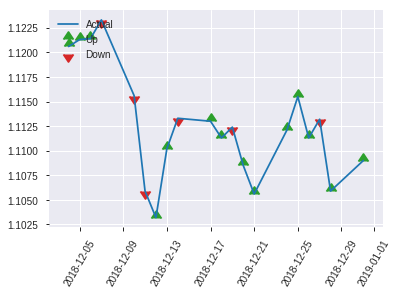


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16365201673104066
RMSE: 0.4045392647581204
LogLoss: 0.49978937794750855
Null degrees of freedom: 255
Residual degrees of freedom: 184
Null deviance: 354.73288115002356
Residual deviance: 255.89216150912435
AIC: 399.8921615091243
AUC: 0.8366037043829085
pr_auc: 0.8298224975120012
Gini: 0.6732074087658171
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5256452234060953: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   32   0.2602   (32.0/123.0)
1      24   109  0.1805   (24.0/133.0)
Total  115  141  0.2188   (56.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.525645     0.79562   140
max f2                       0.264677     0.884354  202
max f0point5                 0.537393     0.783745  138
max accuracy                 0.537393     0.78125   138
max precision                0.994038     1         0
max recall                   0.0204618    1         251
max specificity              0.994038     1         0
max absolute_mcc             0.525645     0.561865  140
max min_per_class_accuracy   0.579522     0.764228  130
max mean_per_class_accuracy  0.537393     0.779999  138

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 54.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.987301           1.92481    1.92481            1                0.99159    1                           0.99159             0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.984901           1.92481    1.92481            1                0.985622   1                           0.988606            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.976015           1.92481    1.92481            1                0.978815   1                           0.986158            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.97187            1.28321    1.74983            0.666667         0.973465   0.909091                    0.982696            0.0150376       0.075188                   28.3208   74.9829
    5        0.0507812                   0.961116           1.92481    1.77675            1                0.967701   0.923077                    0.98039             0.0150376       0.0902256                  92.4812   77.675
    6        0.101562                    0.92362            1.92481    1.85078            1                0.940537   0.961538                    0.960463            0.0977444       0.18797                    92.4812   85.0781
    7        0.152344                    0.861072           1.62869    1.77675            0.846154         0.8816     0.923077                    0.934176            0.0827068       0.270677                   62.8687   77.675
    8        0.203125                    0.822021           1.62869    1.73973            0.846154         0.837438   0.903846                    0.909991            0.0827068       0.353383                   62.8687   73.9734
    9        0.300781                    0.760921           1.38586    1.62484            0.72             0.78963    0.844156                    0.870913            0.135338        0.488722                   38.5865   62.4841
    10       0.402344                    0.677378           1.40659    1.56975            0.730769         0.720837   0.815534                    0.83303             0.142857        0.631579                   40.6593   56.975
    11       0.5                         0.600822           1.15489    1.48872            0.6              0.637732   0.773438                    0.794885            0.112782        0.744361                   15.4887   48.8722
    12       0.601562                    0.491091           0.814344   1.37487            0.423077         0.530365   0.714286                    0.750226            0.0827068       0.827068                   -18.5656  37.4866
    13       0.699219                    0.385651           0.846917   1.30113            0.44             0.440903   0.675978                    0.707025            0.0827068       0.909774                   -15.3083  30.113
    14       0.800781                    0.240524           0.666281   1.22061            0.346154         0.318519   0.634146                    0.657751            0.0676692       0.977444                   -33.3719  22.0613
    15       0.898438                    0.0809477          0.0769925  1.09631            0.04             0.160847   0.569565                    0.603739            0.0075188       0.984962                   -92.3008  9.6306
    16       1                           0.00267588         0.148062   1                  0.0769231        0.0352945  0.519531      

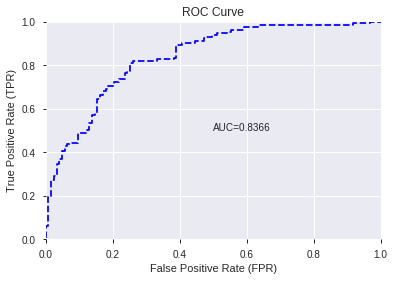

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


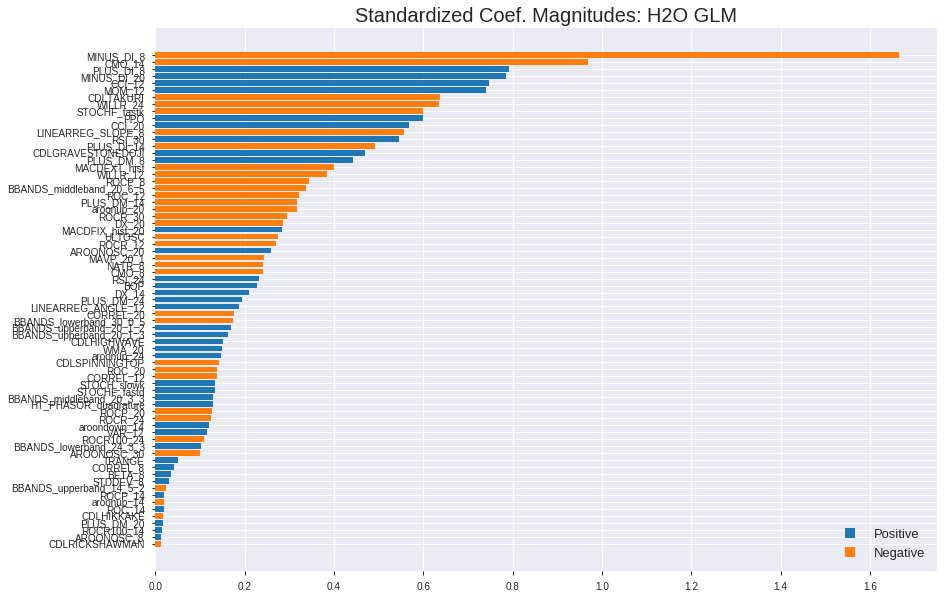

'log_likelihood'
--2019-08-22 16:53:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


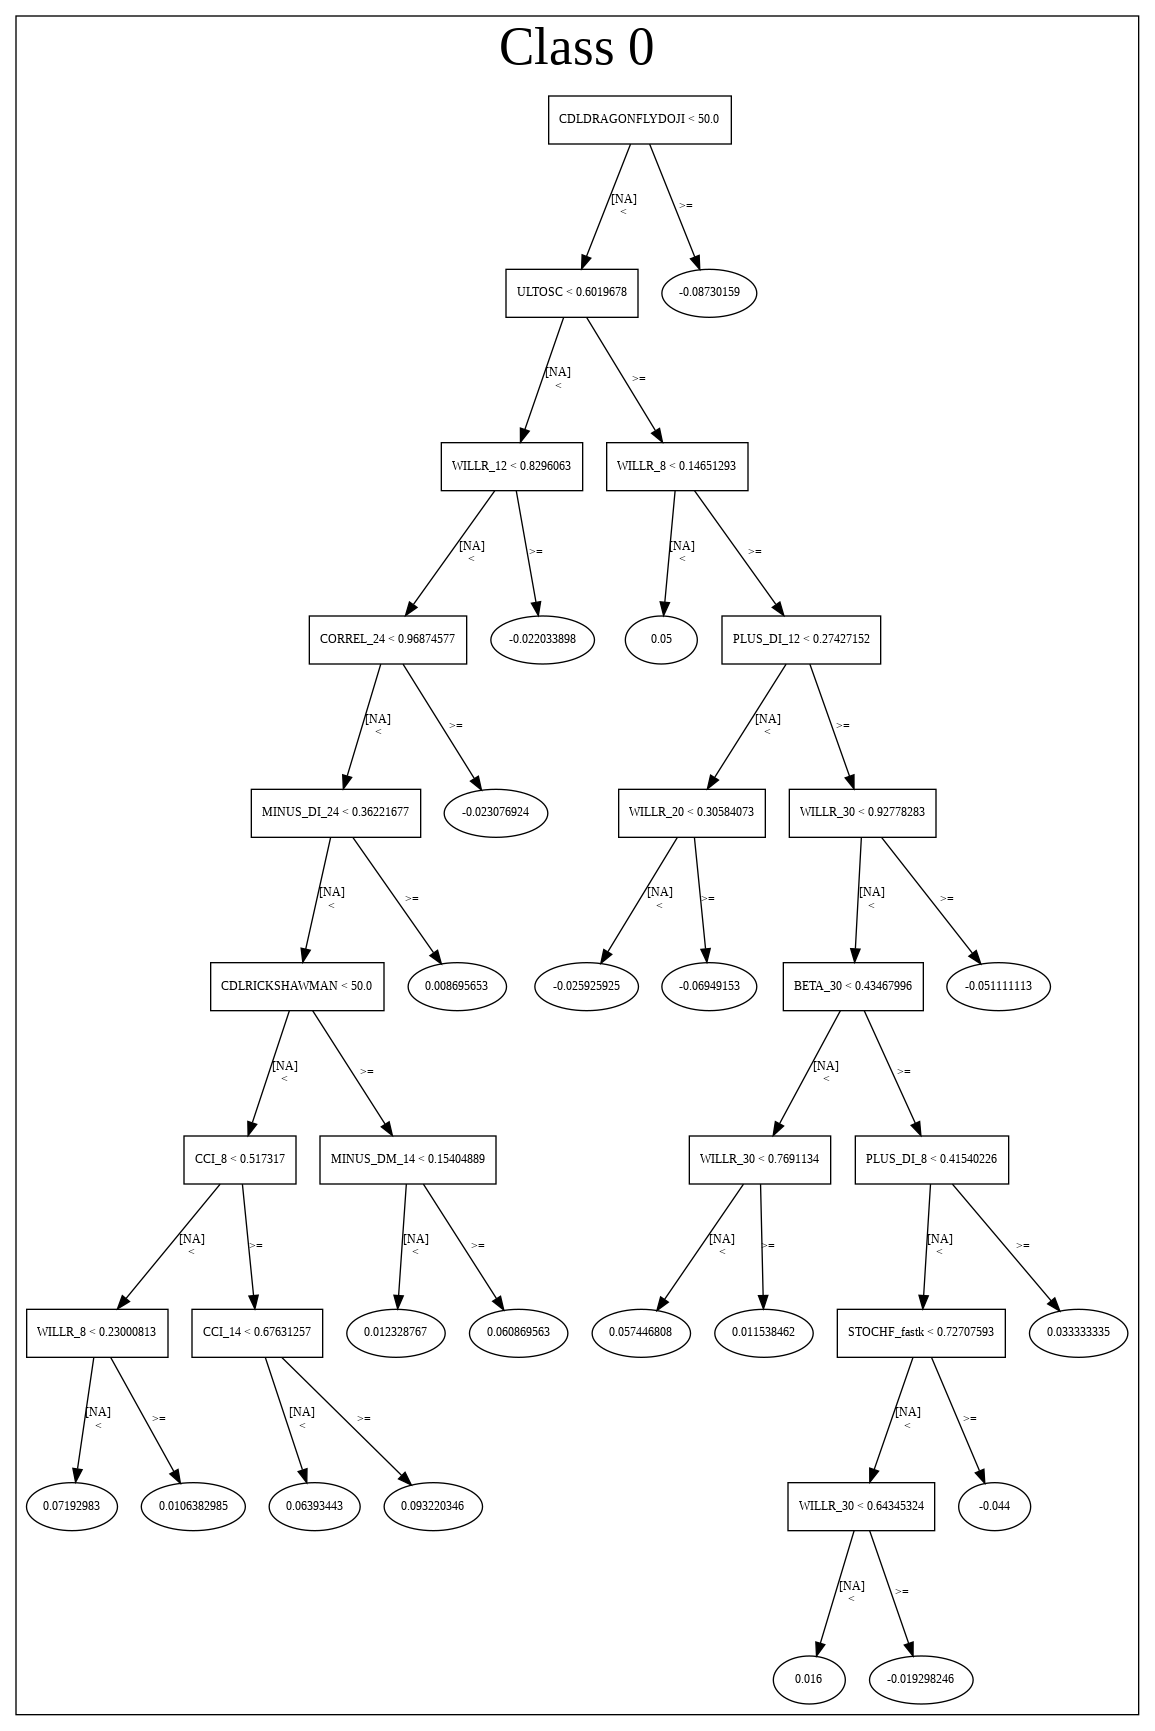

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_165321_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_165321_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['MINUS_DI_8',
 'CMO_14',
 'PLUS_DI_8',
 'MINUS_DI_20',
 'CCI_12',
 'MOM_12',
 'CDLTAKURI',
 'WILLR_24',
 'STOCHF_fastk',
 'PPO',
 'CCI_20',
 'LINEARREG_SLOPE_8',
 'RSI_30',
 'PLUS_DI_14',
 'CDLGRAVESTONEDOJI',
 'PLUS_DM_8',
 'MACDEXT_hist',
 'WILLR_12',
 'ROCP_8',
 'BBANDS_middleband_20_6_5',
 'ROC_12',
 'PLUS_DM_14',
 'aroonup_20',
 'ROCR_30',
 'DX_20',
 'MACDFIX_hist_20',
 'ULTOSC',
 'ROCR_12',
 'AROONOSC_20',
 'MAVP_20_1',
 'NATR_8',
 'CMO_8',
 'RSI_24',
 'BOP',
 'DX_14',
 'PLUS_DM_24',
 'LINEARREG_ANGLE_12',
 'CORREL_20',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_upperband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'CDLHIGHWAVE',
 'WMA_20',
 'aroonup_24',
 'CDLSPINNINGTOP',
 'ROC_20',
 'CORREL_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'BBANDS_middleband_20_3_3',
 'HT_PHASOR_quadrature',
 'ROCP_20',
 'ROCR_24',
 'aroondown_14',
 'VAR_12',
 'ROCR100_24',
 'BBANDS_lowerband_24_3_3',
 'AROONOSC_30',
 'TRANGE',
 'CORREL_8',
 'BETA_8',
 'STDDEV_8',
 'BBANDS_upperband_14_5_2',
 'ROCP_14',
 'aroonup_1

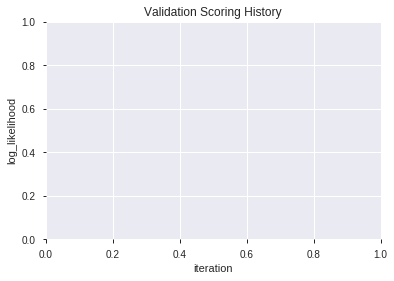

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_165334_model_1  0.853964  0.490290              0.229660  0.400731  0.160585
1  XGBoost_grid_1_AutoML_20190822_165334_model_4  0.845162  0.500396              0.213094  0.405397  0.164347
2               XGBoost_1_AutoML_20190822_165334  0.841249  0.506034              0.220613  0.409739  0.167886
3               XGBoost_2_AutoML_20190822_165334  0.840883  0.495974              0.212788  0.404084  0.163284
4  XGBoost_grid_1_AutoML_20190822_165334_model_7  0.839293  0.504058              0.229965  0.407966  0.166437
5  XGBoost_grid_1_AutoML_20190822_165334_model_3  0.832875  0.508744              0.244697  0.410715  0.168687
6               XGBoost_3_AutoML_20190822_165334  0.831652  0.514243              0.223455  0.414698  0.171974
7  XGBoost_grid_1_AutoML_20190822_165334_model_2  0.829329  0.518781              0.243780  0.415494  0.172635
8  XGBoost_grid_1_AutoML_20190822_165334_model_5  0.825601  0.517165              0.286173  0.412840  0.170437
9  XGBoost_grid_1_AutoML_20190822_165334_model_6  0.823828  0.519647              0.284950  0.415611  0.172733

variable  relative_importance  scaled_importance  percentage
0                  CDLTAKURI          2036.845825           1.000000    0.194692
1          CDLGRAVESTONEDOJI          1409.468384           0.691986    0.134724
2               STOCHF_fastk           630.235657           0.309417    0.060241
3                     ULTOSC           490.875397           0.240998    0.046920
4                 MINUS_DI_8           488.417511           0.239791    0.046685
..                       ...                  ...                ...         ...
62                   ROCR_12             6.878118           0.003377    0.000657
63            CDLSPINNINGTOP             5.959673           0.002926    0.000570
64                PLUS_DM_14             5.709970           0.002803    0.000546
65  BBANDS_middleband_20_6_5             5.497581           0.002699    0.000525
66                   ROCP_14             0.377340           0.000185    0.000036

[67 rows x 4 columns]

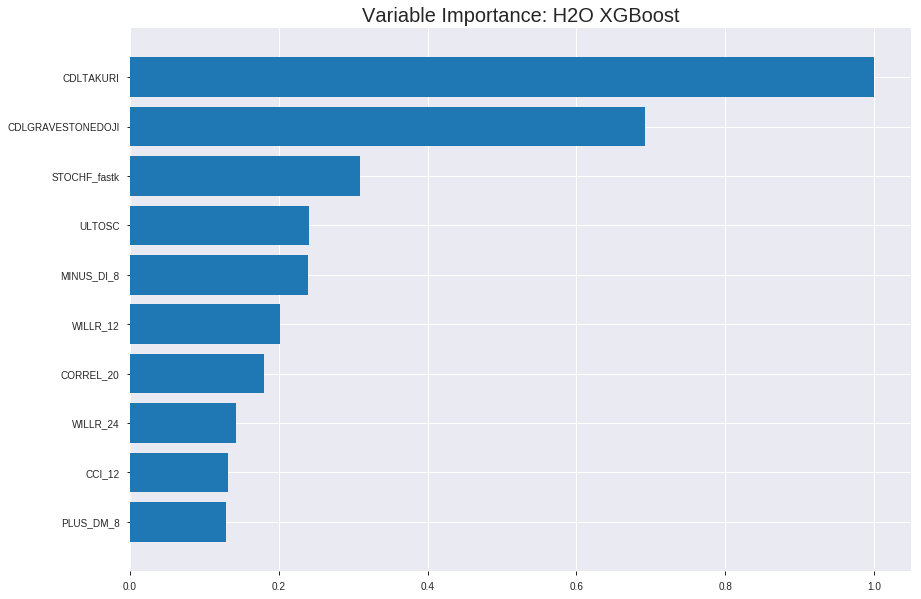

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_165334_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12591754760707594
RMSE: 0.35484862632829217
LogLoss: 0.4082814479146245
Mean Per-Class Error: 0.14360237846170787
AUC: 0.9397689108227015
pr_auc: 0.9402506244998201
Gini: 0.8795378216454031
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4451717808842659: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      676  210   0.237    (210.0/886.0)
1      60   842   0.0665   (60.0/902.0)
Total  736  1052  0.151    (270.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445172     0.861822  229
max f2                       0.39141      0.909566  253
max f0point5                 0.58733      0.887926  160
max accuracy                 0.513263     0.856264  196
max precision                0.970677     1         0
max recall                   0.135617     1         355
max specificity              0.970677     1         0
max absolute_mcc             0.525237     0.713281  191
max min_per_class_accuracy   0.505729     0.854402  200
max mean_per_class_accuracy  0.513263     0.856398  196

Gains/Lift Table: Avg response rate: 50.45 %, avg score: 50.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.955635           1.98226    1.98226            1                0.962184  1                           0.962184            0.0199557       0.0199557                  98.2262   98.2262
    2        0.0201342                   0.946771           1.98226    1.98226            1                0.951439  1                           0.956811            0.0199557       0.0399113                  98.2262   98.2262
    3        0.0302013                   0.937888           1.98226    1.98226            1                0.942182  1                           0.951935            0.0199557       0.059867                   98.2262   98.2262
    4        0.0402685                   0.929414           1.98226    1.98226            1                0.933986  1                           0.947448            0.0199557       0.0798226                  98.2262   98.2262
    5        0.0503356                   0.922532           1.98226    1.98226            1                0.926192  1                           0.943197            0.0199557       0.0997783                  98.2262   98.2262
    6        0.100112                    0.854757           1.98226    1.98226            1                0.890175  1                           0.916834            0.0986696       0.198448                   98.2262   98.2262
    7        0.150447                    0.80054            1.93821    1.96752            0.977778         0.827677  0.992565                    0.887004            0.097561        0.296009                   93.8211   96.7524
    8        0.200224                    0.743904           1.91544    1.95458            0.966292         0.770305  0.986034                    0.857992            0.0953437       0.391353                   91.5444   95.4576
    9        0.300336                    0.651667           1.86045    1.9232             0.938547         0.69706   0.970205                    0.804348            0.186253        0.577605                   86.0447   92.32
    10       0.399888                    0.578604           1.61476    1.84641            0.814607         0.616359  0.931469                    0.757548            0.160754        0.738359                   61.4764   84.6414
    11       0.5                         0.506794           1.14063    1.7051             0.575419         0.540922  0.860179                    0.714174            0.114191        0.85255                    14.0631   70.51
    12       0.600112                    0.435669           0.863779   1.56475            0.435754         0.470366  0.789376                    0.673502            0.0864745       0.939024                   -13.6221  56.4749
    13       0.699664                    0.358551           0.367498   1.3944             0.185393         0.398974  0.703437                    0.63444             0.0365854       0.97561                    -63.2502  39.4397
    14       0.799776                    0.276518           0.166111   1.24065            0.0837989        0.316013  0.625874                    0.594581            0.0166297       0.992239                   -83.3889  24.0646
    15       0.899888                    0.131439           0.0775186  1.11125            0.0391061        0.218656  0.560597                    0.55276             0.00776053      1                          -92.2481  11.1249
    16       1                           0.025071           0          1                  0                0.069593  0.504474                    0.5



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16409032359811976
RMSE: 0.40508063838959246
LogLoss: 0.4938686080129068
Mean Per-Class Error: 0.25627413127413123
AUC: 0.8391784641784642
pr_auc: 0.8321361584952172
Gini: 0.6783569283569284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3677859604358673: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      145  114  0.4402   (114.0/259.0)
1      21   231  0.0833   (21.0/252.0)
Total  166  345  0.2642   (135.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367786     0.773869  273
max f2                       0.224414     0.872625  325
max f0point5                 0.607432     0.782609  138
max accuracy                 0.590743     0.745597  146
max precision                0.961884     1         0
max recall                   0.0479997    1         391
max specificity              0.961884     1         0
max absolute_mcc             0.607432     0.514426  138
max min_per_class_accuracy   0.485138     0.737452  205
max mean_per_class_accuracy  0.581627     0.743726  153

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 47.81 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.948871           2.02778    2.02778            1                0.955438  1                           0.955438            0.0238095       0.0238095                  102.778    102.778
    2        0.0215264                   0.941049           2.02778    2.02778            1                0.944158  1                           0.950311            0.0198413       0.0436508                  102.778    102.778
    3        0.0313112                   0.928166           1.62222    1.90104            0.8              0.932047  0.9375                      0.944603            0.015873        0.0595238                  62.2222    90.1042
    4        0.0410959                   0.917997           2.02778    1.93122            1                0.922794  0.952381                    0.939411            0.0198413       0.0793651                  102.778    93.1217
    5        0.0508806                   0.904771           2.02778    1.94979            1                0.911532  0.961538                    0.934049            0.0198413       0.0992063                  102.778    94.9786
    6        0.101761                    0.836886           1.94979    1.94979            0.961538         0.867528  0.961538                    0.900788            0.0992063       0.198413                   94.9786    94.9786
    7        0.150685                    0.77405            1.86556    1.92244            0.92             0.801415  0.948052                    0.868524            0.0912698       0.289683                   86.5556    92.2439
    8        0.201566                    0.711777           1.87179    1.90965            0.923077         0.746785  0.941748                    0.837794            0.0952381       0.384921                   87.1795    90.9655
    9        0.30137                     0.626073           1.47113    1.76443            0.72549          0.666561  0.87013                     0.781087            0.146825        0.531746                   47.1133    76.443
    10       0.401174                    0.550103           1.11329    1.60244            0.54902          0.586581  0.790244                    0.732698            0.111111        0.642857                   11.329     60.2439
    11       0.500978                    0.482636           0.994009   1.48123            0.490196         0.515193  0.730469                    0.689367            0.0992063       0.742063                   -0.599129  48.1228
    12       0.600783                    0.423248           0.755447   1.36066            0.372549         0.449349  0.67101                     0.649494            0.0753968       0.81746                    -24.4553   36.0659
    13       0.700587                    0.331533           1.07353    1.31975            0.529412         0.381589  0.650838                    0.611329            0.107143        0.924603                   7.35294    31.9755
    14       0.800391                    0.242526           0.516885   1.21964            0.254902         0.290283  0.601467                    0.571296            0.0515873       0.97619                    -48.3115   21.9641
    15       0.900196                    0.0862113          0.159041   1.10205            0.0784314        0.15034   0.543478                    0.524625            0.015873        0.992063                   -84.0959   10.2053
    16       1                           0.0292127          0.0795207  1                  0.0392157        0.058172  0.493151   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:53:40  0.017 sec   0                  0.5              0.693147            0.5             0                  1                0.495526                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-08-22 16:53:40  0.097 sec   5                  0.473825         0.641668            0.814186        0.759135           1.94749          0.308166                         0.472884           0.63986               0.807241          0.775547             2.02778            0.30137
    2019-08-22 16:53:40  0.139 sec   10                 0.45442          0.603611            0.832385        0.803044           1.98226          0.279083                         0.453515           0.601796              0.818403          0.800963             2.02778            0.27593
    2019-08-22 16:53:40  0.185 sec   15                 0.440541         0.57568             0.842697        0.843605           1.98226          0.258389                         0.439538           0.573472              0.827572          0.828838             2.02778            0.313112
    2019-08-22 16:53:40  0.232 sec   20                 0.429348         0.552586            0.851515        0.852963           1.98226          0.232662                         0.43078            0.554574              0.829304          0.82778              2.02778            0.295499
    2019-08-22 16:53:40  0.281 sec   25                 0.421329         0.535356            0.857051        0.860012           1.98226          0.221477                         0.425198           0.541561              0.827703          0.825498             2.02778            0.272016
    2019-08-22 16:53:41  0.332 sec   30                 0.415149         0.521535            0.863659        0.862903           1.98226          0.219239                         0.420454           0.530371              0.832031          0.833103             2.02778            0.25636
    2019-08-22 16:53:41  0.410 sec   35                 0.408686         0.507857            0.872033        0.877              1.98226          0.21868                          0.417064           0.522171              0.833134          0.834346             2.02778            0.264188
    2019-08-22 16:53:41  0.463 sec   40                 0.403096         0.496026            0.878712        0.884349           1.98226          0.209732                         0.415071           0.516752              0.833226          0.834301             2.02778            0.295499
    2019-08-22 16:53:41  0.517 sec   45                 0.397306         0.484397            0.887353        0.889826           1.98226          0.207494                         0.412528           0.510919              0.835134          0.83691              2.02778            0.272016
    2019-08-22 16:53:41  0.583 sec   50                 0.38949          0.470082            0.899229        0.901652           1.98226          0.196868                         0.410054           0.505428              0.837562          0.838093             2.02778            0.27593
    2019-08-22 16:53:41  0.639 sec   55                 0.38395          0.459823            0.905782        0.911558           1.98226          0.19519                          0.408586           0.502022              0.838688          0.837

Variable Importances: 


variable                  relative_importance    scaled_importance       percentage
------------------------  ---------------------  ----------------------  ---------------------
CDLTAKURI                 2036.8458251953125     1.0                     0.19469188239074467
CDLGRAVESTONEDOJI         1409.4683837890625     0.6919857980188113      0.134724017603944
STOCHF_fastk              630.2356567382812      0.309417457591739       0.06024106726309408
ULTOSC                    490.8753967285156      0.2409978166518547      0.046920318576009146
MINUS_DI_8                488.4175109863281      0.2397911049254275      0.04668538159848805
---                       ---                    ---                     ---
ROCR_12                   6.878117561340332      0.003376847415871936    0.0006574447799424291
CDLSPINNINGTOP            5.9596734046936035     0.0029259325035669464   0.0005696553068677131
PLUS_DM_14                5.709969997406006      0.002803339323367039    0.0005457874098463253
BBANDS_middleband_20_6_5  5.4975810050964355     0.0026990658483291314   0.0005254862107077707
ROCP_14                   0.37734031677246094    0.00018525718152294512  3.606806939710607e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.795774647887324)

('auc', 0.8539641787395317)

('logloss', 0.4902897522815063)

('mean_per_class_error', 0.22324102940277524)

('rmse', 0.40073056337364904)

('mse', 0.16058498442176217)

xgboost prediction progress: |████████████████████████████████████████████| 100%


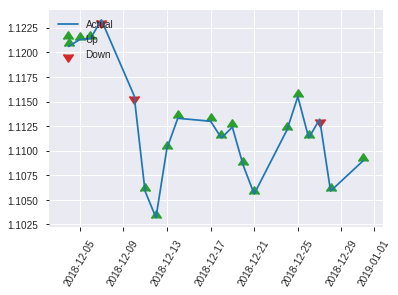


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16058498442176217
RMSE: 0.40073056337364904
LogLoss: 0.4902897522815063
Mean Per-Class Error: 0.22324102940277524
AUC: 0.8539641787395317
pr_auc: 0.8606922065174263
Gini: 0.7079283574790634
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4914498031139374: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   38   0.3089   (38.0/123.0)
1      20   113  0.1504   (20.0/133.0)
Total  105  151  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49145      0.795775  150
max f2                       0.265006     0.885135  207
max f0point5                 0.618559     0.808967  94
max accuracy                 0.583399     0.773438  108
max precision                0.960231     1         0
max recall                   0.0375138    1         253
max specificity              0.960231     1         0
max absolute_mcc             0.583399     0.559291  108
max min_per_class_accuracy   0.551431     0.766917  128
max mean_per_class_accuracy  0.583399     0.776759  108

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.941468           1.92481    1.92481            1                0.950147   1                           0.950147            0.0225564       0.0225564                  92.4812   92.4812
    2        0.0234375                   0.931505           1.92481    1.92481            1                0.937648   1                           0.943897            0.0225564       0.0451128                  92.4812   92.4812
    3        0.03125                     0.90774            1.92481    1.92481            1                0.91767    1                           0.937341            0.0150376       0.0601504                  92.4812   92.4812
    4        0.0429688                   0.896161           1.92481    1.92481            1                0.899881   1                           0.927124            0.0225564       0.0827068                  92.4812   92.4812
    5        0.0507812                   0.888392           1.92481    1.92481            1                0.89078    1                           0.921533            0.0150376       0.0977444                  92.4812   92.4812
    6        0.101562                    0.837153           1.92481    1.92481            1                0.861709   1                           0.891621            0.0977444       0.195489                   92.4812   92.4812
    7        0.152344                    0.792452           1.77675    1.87546            0.923077         0.810736   0.974359                    0.864659            0.0902256       0.285714                   77.675    87.5458
    8        0.203125                    0.751636           1.1845     1.70272            0.615385         0.767651   0.884615                    0.840407            0.0601504       0.345865                   18.45     70.2718
    9        0.300781                    0.668822           1.84782    1.74983            0.96             0.701041   0.909091                    0.795159            0.180451        0.526316                   84.782    74.9829
    10       0.402344                    0.600325           1.1845     1.60712            0.615385         0.633326   0.834951                    0.754308            0.120301        0.646617                   18.45     60.7125
    11       0.5                         0.551892           1.15489    1.5188             0.6              0.574459   0.789062                    0.719181            0.112782        0.759398                   15.4887   51.8797
    12       0.601562                    0.477601           0.888375   1.41236            0.461538         0.51487    0.733766                    0.684687            0.0902256       0.849624                   -11.1625  41.2362
    13       0.699219                    0.403852           0.538947   1.29038            0.28             0.446402   0.670391                    0.651407            0.0526316       0.902256                   -46.1053  29.0377
    14       0.800781                    0.301291           0.740312   1.22061            0.384615         0.359193   0.634146                    0.614346            0.075188        0.977444                   -25.9688  22.0613
    15       0.898438                    0.102716           0.0769925  1.09631            0.04             0.180099   0.569565                    0.567145            0.0075188       0.984962                   -92.3008  9.6306
    16       1                           0.0257863          0.148062   1                  0.0769231        0.0650863  0.519531  

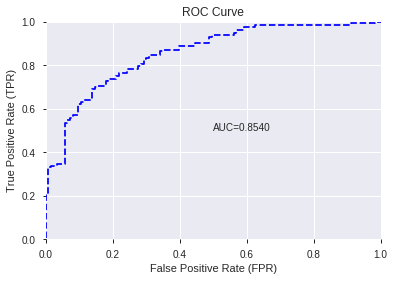

This function is available for GLM models only


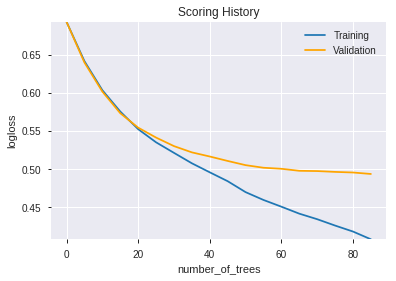

--2019-08-22 16:53:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

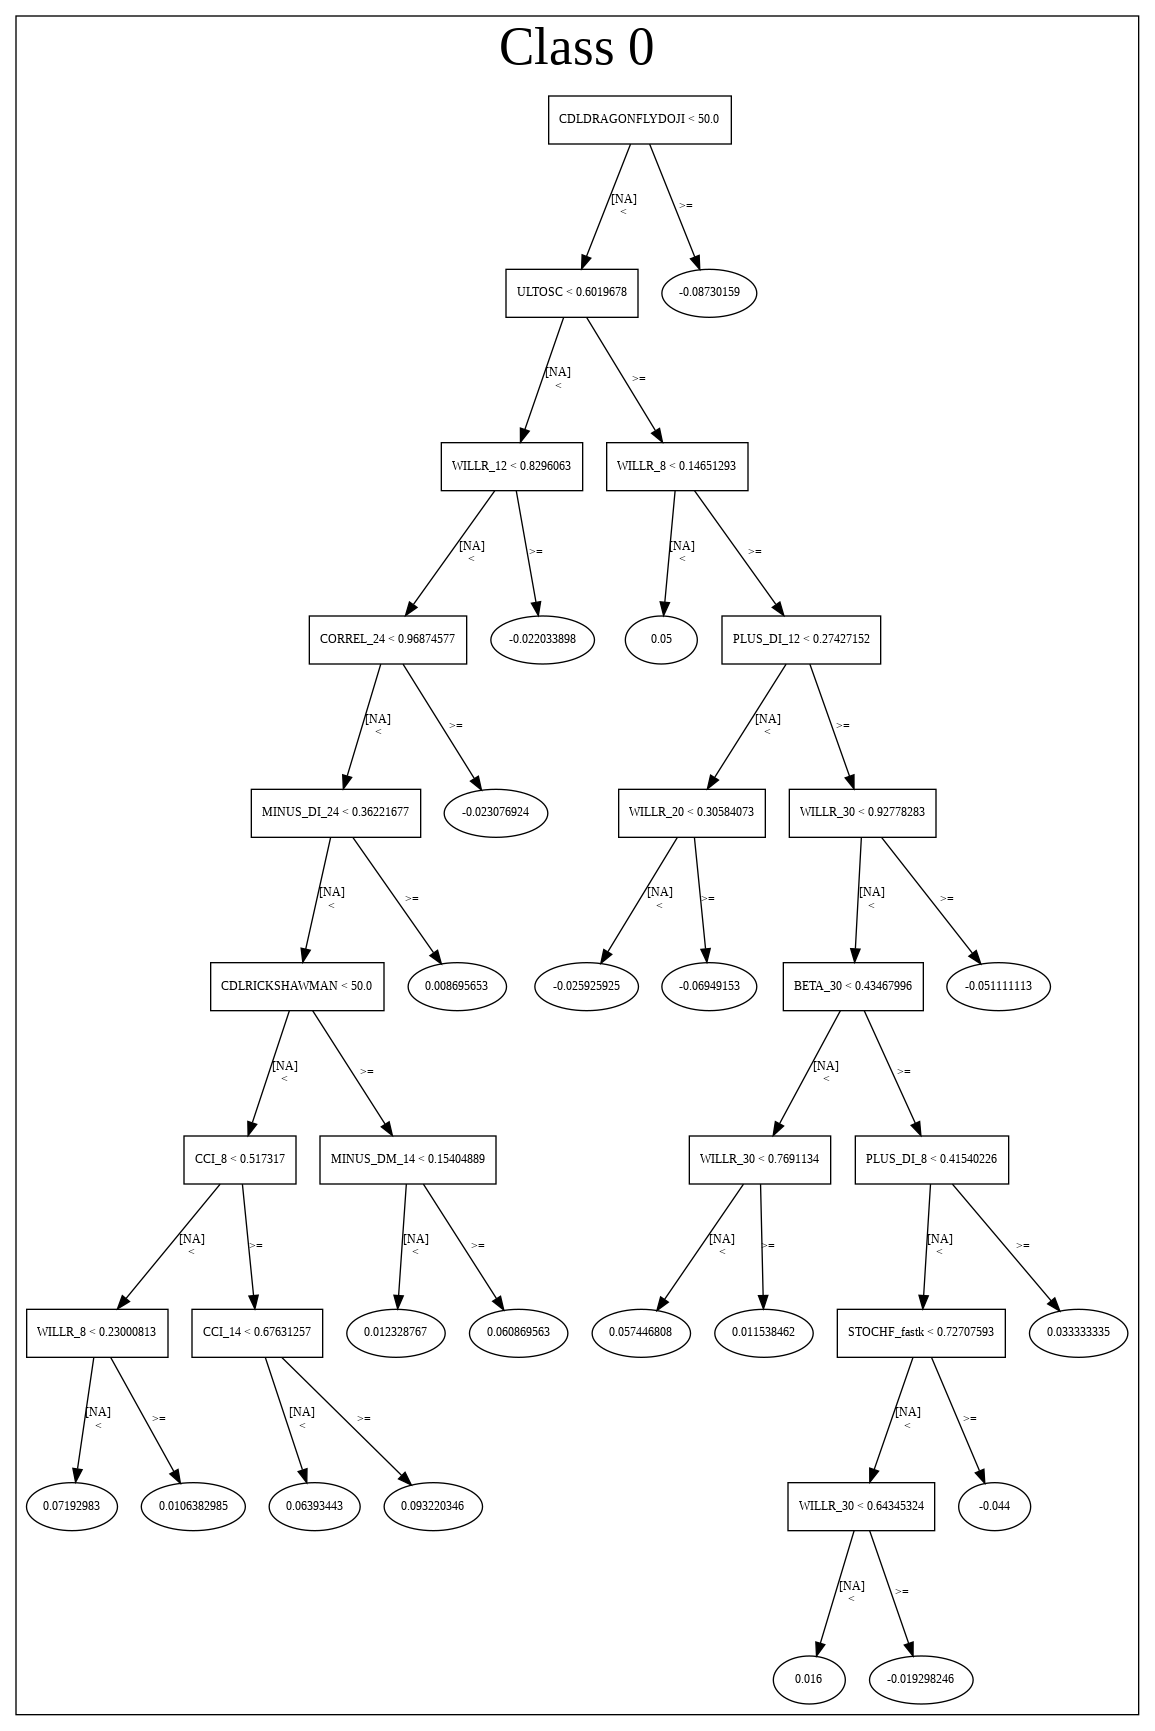

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_165334_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_165334_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9e4e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'ULTOSC',
 'MINUS_DI_8',
 'WILLR_12',
 'CORREL_20',
 'WILLR_24',
 'CCI_12',
 'PLUS_DM_8',
 'TRANGE',
 'LINEARREG_SLOPE_8',
 'BETA_8',
 'BOP',
 'aroonup_14',
 'CORREL_12',
 'PLUS_DI_8',
 'LINEARREG_ANGLE_12',
 'MACDFIX_hist_20',
 'MACDEXT_hist',
 'MINUS_DI_20',
 'CORREL_8',
 'BBANDS_upperband_14_5_2',
 'PLUS_DI_14',
 'ROCP_8',
 'RSI_30',
 'DX_20',
 'AROONOSC_8',
 'NATR_8',
 'CMO_14',
 'aroondown_14',
 'MAVP_20_1',
 'ROC_12',
 'HT_PHASOR_quadrature',
 'CCI_20',
 'STOCH_slowk',
 'STDDEV_8',
 'ROCR_30',
 'BBANDS_lowerband_24_3_3',
 'RSI_24',
 'PLUS_DM_20',
 'PLUS_DM_24',
 'AROONOSC_20',
 'BBANDS_lowerband_30_0_5',
 'ROC_20',
 'BBANDS_upperband_20_1_3',
 'VAR_12',
 'CDLRICKSHAWMAN',
 'WMA_20',
 'ROC_14',
 'CMO_8',
 'BBANDS_middleband_20_3_3',
 'aroonup_24',
 'PPO',
 'BBANDS_upperband_20_1_2',
 'ROCR_24',
 'STOCHF_fastd',
 'AROONOSC_30',
 'DX_14',
 'aroonup_20',
 'MOM_12',
 'ROCR100_24',
 'ROCR_12',
 'CDLSPINNINGTOP',
 'PLUS_DM_14',
 'BBA

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.785
GLM             0.809
XGBoost         0.789
dtype: float64

DeepLearning    GLM  XGBoost
All          0.777  0.785    0.785
DLF          0.777  0.773    0.789
Fwe          0.785  0.809    0.773
RFE          0.746  0.781    0.773
XGBF         0.777  0.773    0.789





F1


DeepLearning    0.807
GLM             0.829
XGBoost         0.799
dtype: float64

DeepLearning    GLM  XGBoost
All          0.804  0.815    0.790
DLF          0.800  0.807    0.797
Fwe          0.807  0.829    0.799
RFE          0.776  0.796    0.796
XGBF         0.801  0.807    0.797





auc


DeepLearning    0.861
GLM             0.863
XGBoost         0.854
dtype: float64

DeepLearning    GLM  XGBoost
All          0.841  0.846    0.849
DLF          0.861  0.848    0.850
Fwe          0.859  0.863    0.837
RFE          0.814  0.837    0.854
XGBF         0.854  0.848    0.850





logloss


DeepLearning    0.585
GLM             0.500
XGBoost         0.514
dtype: float64

DeepLearning    GLM  XGBoost
All          0.548  0.488    0.514
DLF          0.474  0.485    0.485
Fwe          0.501  0.474    0.502
RFE          0.585  0.500    0.490
XGBF         0.475  0.485    0.485





mean_per_class_error


DeepLearning    0.258
GLM             0.232
XGBoost         0.229
dtype: float64

DeepLearning    GLM  XGBoost
All          0.225  0.220    0.214
DLF          0.223  0.232    0.211
Fwe          0.215  0.194    0.229
RFE          0.258  0.220    0.223
XGBF         0.226  0.232    0.211





rmse


DeepLearning    0.433
GLM             0.405
XGBoost         0.412
dtype: float64

DeepLearning    GLM  XGBoost
All          0.433  0.400    0.412
DLF          0.393  0.400    0.399
Fwe          0.408  0.395    0.408
RFE          0.428  0.405    0.401
XGBF         0.395  0.400    0.399





mse


DeepLearning    0.187
GLM             0.164
XGBoost         0.170
dtype: float64

DeepLearning    GLM  XGBoost
All          0.187  0.160    0.170
DLF          0.154  0.160    0.159
Fwe          0.166  0.156    0.166
RFE          0.184  0.164    0.161
XGBF         0.156  0.160    0.159

{'F1':       DeepLearning    GLM  XGBoost
 All          0.804    NaN      NaN
 DLF          0.800    NaN      NaN
 DLF            NaN  0.807      NaN
 DLF            NaN    NaN    0.797
 All            NaN  0.815      NaN
 All            NaN    NaN    0.790
 XGBF         0.801    NaN      NaN
 XGBF           NaN  0.807      NaN
 XGBF           NaN    NaN    0.797
 Fwe          0.807    NaN      NaN
 Fwe            NaN  0.829      NaN
 Fwe            NaN    NaN    0.799
 RFE          0.776    NaN      NaN
 RFE            NaN  0.796      NaN
 RFE            NaN    NaN    0.796,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.777    NaN      NaN
 DLF          0.777    NaN      NaN
 DLF            NaN  0.773      NaN
 DLF            NaN    NaN    0.789
 All            NaN  0.785      NaN
 All            NaN    NaN    0.785
 XGBF         0.777    NaN      NaN
 XGBF           NaN  0.773      NaN
 XGBF           NaN    NaN    0.789
 Fwe          0.785    NaN      NaN
 Fwe     